In [6]:
import pandas as pd
import os

model_name = "musse"
extended_name = "_90614"
special_name = "_reordered"
trees_directory = "trees/"
num_states = 3
ss = "_ss"  # "" for cdv, "_ss" for ss

# part of the relative path for writing down the output files
chemin = './trained_models/SS/' + model_name + '/'

# the suffix of output files
expname= model_name + extended_name

In [2]:
import os
import numpy as np
from ete3 import Tree

class TreeEncoder:

    def encode_tree(self, tree_str):
        """
        Encode the tree structure into a format suitable for input into the neural network.
        """
        # Check if the tree is already encoded
        csv_file = tree_str[:-4] + '.csv'
        if os.path.exists(csv_file):
            return csv_file
        # Call the external script to get CDV encoding
        cmd = f"python -m CDV_full_tree -t {tree_str} -f {csv_file}" # > {tree_str[:-4]}.csv"
        os.system(cmd)
        

    def encode_all_trees(self, trees_directory):
        """
        Encode all the trees in the given directory.
        """
        tree_files = [os.path.join(trees_directory, file) for file in os.listdir(trees_directory) if file.endswith('.nwk')]
        for tree_file in tree_files:
            print(tree_file)
            self.encode_tree(tree_file)


In [3]:
import sys

encoder = TreeEncoder()
encoded_trees = encoder.encode_all_trees(trees_directory)

trees/bd.nwk
trees/bd_min.nwk
trees/bd_ss_min.nwk
trees/bisse.nwk
trees/bisseness.nwk
trees/bisse_min.nwk
trees/bisse_ss_min.nwk
trees/classe.nwk
trees/classe_2.nwk
trees/classe_2_min.nwk
trees/classe_2_ss_min.nwk
trees/geosse.nwk
trees/geosse_min.nwk
trees/geosse_ss_min.nwk
trees/musse.nwk
trees/musse_500k.nwk
trees/musse_90614.nwk
trees/musse_min.nwk
trees/musse_ss_min.nwk
trees/quasse.nwk


Check if the musse.csv is empty, in that case run
* python -m CDV_full_tree -t trees/musse.nwk -f trees/musse.csv

from linux terminal!

In [4]:
import pandas as pd
import os

# Load parameter values as a dataframe
tree_files = [os.path.join(trees_directory, file) for file in os.listdir(trees_directory) if file.endswith('.nwk')]


if model_name == "bd":
    column_names = ['lambda', 'mu']
elif model_name == "bisse":
    column_names = ['lambda1', 'lambda2', 'mu1', 'mu2', 'q12', 'q21']
elif model_name == "musse":
    '''
    λ1, . . . , λK, µ1, . . . , µK, qij
    Generalizing BiSSE to K
    character states with constant
    rates.
    '''
    if num_states == 3:
        column_names = ['lambda1', 'lambda2', 'lambda3', 'mu1', 'mu2', 'mu3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
    elif num_states == 4:
        column_names = ['lambda1', 'lambda2', 'lambda3', 'lambda4', 'mu1', 'mu2', 'mu3', 'mu4', 'q12', 'q13', 'q14', 'q21', 'q23', 'q24', 'q31', 'q32', 'q34', 'q41', 'q42', 'q43']
    else:
        print("Not implemented for more than 4 states")
elif model_name == "geosse":
    '''
    sA, sB, sAB, xA, xB, dA, dB    
    Accounts for geographical
    considerations with constant
    rates of speciation, extinction,
    and dispersal.'''
    column_names = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
elif model_name == "bisseness":
    '''
    λ0, λ1, µ0, µ1, q12, q21, p0c, p0a, p1c, p1a
    Estimates rates of change occurring along lineages and
    probabilities of change during
    speciation.
    '''
    column_names = ['lambda1', 'lambda2', 'mu1', 'mu2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
elif model_name == "classe":
    '''
    λklm (where 1 ≤ k, l, m ≤ n),
    µk (where 1 ≤ k ≤ n),
    qlm (where 1 ≤ l ̸= m ≤ n)
    Distinguishes between anagenetic and cladogenetic speciation with variable rates.
    There will be n^2 cladogenesis rates and n extinction rates
    plus n(n-1) transition rates, making a total of n^2+n+n(n-1) parameters.
    
    Two character states:
    • λ111: Rate of cladogenesis generating progeny inheriting the first character
    state if the parent already possessed said attribute.
    • λ112: Rate of cladogenesis leading to descendants adopting the second
    character state when parents initially bore the initial feature.
    • λ122: Analogous scenario but with reversed roles in character acquisition
    order.
    3
    Figure 2: Anagenesis and Cladogenesis.
    • λ211: Another case wherein children adopt the first characteristic after the
    parent had shifted to the second configuration.
    • λ212: Identical context as above except the final outcome reflects the emergence of the second character state in offspring.
    • λ222: Parallel situation to the preceding cases yet with both parents and
    descendants uniformly exhibiting the latter trait.
    • µ1: Extinction rate attributed to the primary character state.
    • µ2: Loss rate ascribed to the secondary character state.
    • q12: Shift rate towards obtaining the second character state starting from
    the first.
    • q21: Reverse transformation rate moving away from the first characteristic
    toward attaining the second.
    '''
    if num_states == 2:
        column_names = ['lambda111', 'lambda112', 'lambda122', 'lambda211', 'lambda212', 'lambda222', 'mu1', 'mu2', 'q12', 'q21']
    else:
        print("Not implemented yet for more than 2 states")
        
    


def process_params(param_file):
    # Reads the parameter file and saves the values in a csv file, one tree per row.
    # If the parameter file is already in the csv format, return
    if param_file.endswith('.csv'):
        return
    with open(param_file, 'r') as f:
        lines = f.readlines()
    param_values = []
    for line in lines:
        if model_name == 'musse':
            if line.startswith('num_states'):
                param_values.append([])
            else:
                param_values[-1].append(line.split()[1])
        elif model_name == 'bisse' or model_name == 'bisseness':
            if line.startswith('lambda1'):
                param_values.append([])
            param_values[-1].append(line.split()[1])
        elif model_name == 'geosse':
            if line.startswith('sp_a'):
                param_values.append([])
            param_values[-1].append(line.split()[1])
        elif model_name == 'bd':
            if line.startswith('lambda'):
                param_values.append([])
            param_values[-1].append(line.split()[1])
        elif model_name == 'classe':
            if line.startswith('lambda111'):
                param_values.append([])
            param_values[-1].append(line.split()[1])
        else:
            print("Model not implemented")
    param_df = pd.DataFrame(param_values)
    param_df.to_csv(param_file + '.csv', sep='\t', header=False, index=False)
        
        
    
    
param_file = trees_directory + model_name + extended_name + '.params'
process_params(param_file)


cutoff = 0.8  # Number of train trees
param = pd.read_csv(param_file + '.csv' , sep='\t', header=None)

# loading tree encodings/representations
# encoding has the following structure: 1 value of tree height, 500 values for tip states ('1' or '2')
# 1 value for tree height and 500 values for internal node heights
# + 2 values for nb of tips of each type (to be removed) and 1 value of rescaling (removed, but stocked for rescaling predicted values back to the original scale)

# split the encoding into train and test (cutoff is 0.8% of the data)
# read csv and know that there are empty rows for each row of the dataframe
encoding = pd.read_csv(trees_directory + model_name + extended_name + ss +'.csv', sep='\t', header=None, index_col=0)

# Loop over the rows of the dataframe and if you find NaN values, remove the corresponding row from the dataframe and from the parameter dataframe
lines_to_remove = []
for i in range(encoding.shape[0]):
    if encoding.iloc[i].isnull().values.any():
        lines_to_remove.append(i)
        print("Removing row ", i)
        
encoding = encoding.dropna()
param = param.drop(lines_to_remove)
# read model.sizes file and remove the corresponding lines from the dataframe
#model_sizes = pd.read_csv(trees_directory + model_name + '.sizes', sep='\t', header=None)
#model_sizes = model_sizes.drop(lines_to_remove)

print("encoding.shape", encoding.shape)
print("param.shape", param.shape)
        
# Check that the number of rows is correct
assert encoding.shape[0] == param.shape[0]
        
        
        
cutoff = int(cutoff * param.shape[0])

param_train = param.iloc[:cutoff, :]
param_test = param.iloc[cutoff:, :]

print(param_train.columns)
print(column_names)

# Check that the number of columns is correct
assert param_train.shape[1] == len(column_names)

print(param_train.shape)
print(param_test.shape)


def rename_columns(df, names):
    df = df.rename(columns={i: names[i] for i in df.columns})
    return df

param_train = rename_columns(param_train, column_names)
param_test = rename_columns(param_test, column_names)

encoding_train = encoding.iloc[:cutoff, :]
encoding_test = encoding.iloc[cutoff:, :]

print(encoding_train.shape)
print(encoding_test.shape)

print("Number of trees in parameters file: ", param.shape[0])
print("Number of trees in encoding file: ", encoding.shape[0])

if (param.shape[0] != encoding.shape[0]):
    print("Number of trees in parameters file and encoding file do not match, taking the last common number of trees")
    encoding = encoding.iloc[-param.shape[0]:, :]
    encoding_train = encoding.iloc[:cutoff, :]
    encoding_test = encoding.iloc[cutoff:, :]
    print("Number of trees in encoding file: ", encoding.shape[0])

# make sure there is correspondance between indexes of dataframe with parameter values and encodings
encoding_train.index = param_train.index
encoding_test.index = param_test.index

# check
param_test

# check
print(encoding_test.shape)
print(param_train)

# check
encoding_test

Removing row  374
Removing row  436
Removing row  522
Removing row  537
Removing row  633
Removing row  730
Removing row  746
Removing row  810
Removing row  930
Removing row  1011
Removing row  1185
Removing row  1218
Removing row  1346
Removing row  1487
Removing row  1555
Removing row  1821
Removing row  1843
Removing row  1852
Removing row  1887
Removing row  1899
Removing row  1941
Removing row  2102
Removing row  2246
Removing row  2340
Removing row  2407
Removing row  2436
Removing row  2457
Removing row  2556
Removing row  2700
Removing row  2847
Removing row  2935
Removing row  2939
Removing row  3040
Removing row  3051
Removing row  3088
Removing row  3102
Removing row  3317
Removing row  3338
Removing row  3346
Removing row  3585
Removing row  3894
Removing row  4046
Removing row  4095
Removing row  4431
Removing row  4483
Removing row  4648
Removing row  4669
Removing row  4704
Removing row  4713
Removing row  4886
Removing row  5007
Removing row  5010
Removing row  5165
Re

1    2         3         4         5         6         7   \
72502  13.011633  1.0  0.647714  1.051776  0.915945  0.573510  0.925951   
72503   9.003528  1.0  0.592260  0.994804  0.864069  0.536445  0.796747   
72504  25.940326  1.0  0.477128  2.151549  0.781479  0.361972  1.539155   
72505  11.257458  1.0  0.687496  1.115160  0.891301  0.658435  1.031869   
72506  10.681684  1.0  0.627312  1.407378  1.000892  0.719167  1.307912   
...          ...  ...       ...       ...       ...       ...       ...   
90609  19.299491  1.0  0.580866  1.405481  0.879633  0.506385  1.158345   
90610  14.470817  1.0  0.657954  1.257903  0.988461  0.659463  1.321318   
90611  18.733520  1.0  0.595018  1.448954  0.933470  0.555307  1.215372   
90612   9.362905  1.0  0.673351  0.960287  1.144756  0.696469  1.268814   
90613  11.816538  1.0  0.679771  1.193642  0.899103  0.643246  0.934338   

             8         9         10  ...        89        90        91  \
72502  1.534441  1.145573  1.708117  ...  2.282055  2.693327  3.024734   
72503  0.000000  0.000000  0.000000  ...  2.363746  2.772871  3.394446   
72504  1.799330  1.866820  2.551611  ...  2.208428  2.717857  3.110180   
72505  0.908642  0.834847  0.576629  ...  2.290411  2.729107  3.178908   
72506  0.000000  0.000000  0.000000  ...  2.115023  2.259510  2.341155   
...         ...       ...       ...  ...       ...       ...       ...   
90609  2.331522  2.626009  2.618269  ...  2.230176  2.594624  3.210572   
90610  0.938427  0.850805  0.407638  ...  2.226062  2.522211  2.972220   
90611  1.900033  2.401259  1.793654  ...  1.950958  2.236675  2.779646   
90612  1.381025  1.381025  1.907229  ...  1.683390  1.716679  1.904027   
90613  0.917451  0.682643  0.473906  ...  2.502111  2.936193  3.209558   

             92        93        94         95        96   97        98  
72502  3.279006  3.655870  4.258637   6.711758  1.444627  356  0.887170  
72503  3.549641  4.921283  5.175277   7.879648  3.162690   59  1.248254  
72504  3.682444  4.442602  6.573201  14.865849  7.218811  406  2.123436  
72505  3.793932  4.452565  5.287835   7.449770  2.777882  309  1.214100  
72506  2.447611  2.792735  3.930417  10.681684  3.939745   85  2.386648  
...         ...       ...       ...        ...       ...  ...       ...  
90609  3.856865  4.556690  5.678020  11.525831  3.550930  997  1.599951  
90610  3.368811  3.997729  4.997340   6.941171  2.236565  620  1.052325  
90611  3.408496  4.126890  5.270608  11.385200  3.682385  978  1.985297  
90612  2.089798  2.755703  4.270954   7.259203  2.221654   84  1.337621  
90613  3.536617  4.304294  4.655532   6.455984  1.811355  144  4.835868  

[17938 rows x 98 columns]

In [5]:
encoding_train.describe()

1             2             3             4             5   \
count  71749.000000  7.174900e+04  71749.000000  71749.000000  71749.000000   
mean      13.808354  1.000000e+00      0.620937      1.304944      0.922633   
std        3.626651  1.257807e-16      0.055686      0.262612      0.082807   
min        3.814848  1.000000e+00      0.203133      0.546828      0.328740   
25%       11.500006  1.000000e+00      0.591008      1.141672      0.875257   
50%       13.530966  1.000000e+00      0.625554      1.253408      0.928708   
75%       15.777639  1.000000e+00      0.655457      1.404668      0.975855   
max       61.176539  1.000000e+00      1.038869      8.182325      1.396306   

                 6             7             8             9             10  \
count  71749.000000  71749.000000  71749.000000  71749.000000  71749.000000   
mean       0.575697      1.118499      1.105903      0.886613      1.303811   
std        0.096244      0.230025      0.564317      0.664621      1.567397   
min        0.107989      0.112216      0.000000      0.000000      0.000000   
25%        0.517420      0.987236      0.755322      0.479470      0.449042   
50%        0.579335      1.097305      0.996912      0.722729      0.819650   
75%        0.636466      1.221419      1.341397      1.100764      1.549682   
max        1.525527      5.293049      6.845619      9.957123     33.985115   

       ...            89            90            91            92  \
count  ...  71749.000000  71749.000000  71749.000000  71749.000000   
mean   ...      2.160314      2.528329      2.942270      3.437063   
std    ...      0.267278      0.292744      0.330461      0.393532   
min    ...      0.580249      0.729807      0.890938      1.117367   
25%    ...      2.009695      2.360539      2.748099      3.194338   
50%    ...      2.144462      2.510516      2.919509      3.404533   
75%    ...      2.284775      2.667303      3.106224      3.638800   
max    ...      5.773730      6.178295      6.755599      7.559249   

                 93            94            95            96            97  \
count  71749.000000  71749.000000  71749.000000  71749.000000  71749.000000   
mean       4.084176      5.093795      8.760386      2.916541    509.741948   
std        0.506453      0.746713      2.360525      1.408236    283.254318   
min        1.456910      1.688383      1.709290      0.020969     21.000000   
25%        3.765503      4.620034      7.250359      2.084967    263.000000   
50%        4.030625      4.998819      8.450293      2.614974    510.000000   
75%        4.344657      5.466095      9.905115      3.369704    755.000000   
max       10.887679     11.564941     50.418451     33.002975   1000.000000   

                 98  
count  71749.000000  
mean       1.695398  
std        0.662504  
min        0.497916  
25%        1.237951  
50%        1.533156  
75%        1.967076  
max        9.390085  

[8 rows x 98 columns]

In [6]:
# if the model has transition rates (qij), set them to be symmetric: qij = qji
if model_name == "bisse":
    param_train['q21'] = param_train['q12']
    param_test['q21'] = param_test['q12']
elif model_name == "musse":
    if num_states == 3:
        param_train['q21'] = param_train['q12']
        param_train['q31'] = param_train['q13']
        param_train['q32'] = param_train['q23']
        param_test['q21'] = param_test['q12']
        param_test['q31'] = param_test['q13']
        param_test['q32'] = param_test['q23']
    elif num_states == 4:
        param_train['q21'] = param_train['q12']
        param_train['q31'] = param_train['q13']
        param_train['q32'] = param_train['q23']
        param_train['q41'] = param_train['q14']
        param_train['q42'] = param_train['q24']
        param_train['q43'] = param_train['q34']
        param_test['q21'] = param_test['q12']
        param_test['q31'] = param_test['q13']
        param_test['q32'] = param_test['q23']
        param_test['q41'] = param_test['q14']
        param_test['q42'] = param_test['q24']
        param_test['q43'] = param_test['q34']
    else:
        print("Not implemented for more than 4 states")
elif model_name == "classe":
    if num_states == 2:
        param_train['q21'] = param_train['q12']
        param_test['q21'] = param_test['q12']
    else:
        print("Not implemented yet for more than 2 states")
        
# check
param_train.head()

lambda1   lambda2   lambda3       mu1       mu2       mu3       q12  \
0  0.267270  0.334438  0.460898  0.242737  0.067450  0.414066  0.855740   
1  0.352334  0.391563  0.541256  0.118008  0.175253  0.042047  0.593497   
2  0.614129  0.169446  0.402505  0.084064  0.080953  0.237404  0.540157   
3  0.541851  0.240000  0.575899  0.388022  0.227043  0.016148  0.151547   
4  0.633238  0.462413  0.645760  0.509354  0.437419  0.003008  0.271211   

        q13       q21       q23       q31       q32  
0  0.628638  0.855740  0.149429  0.628638  0.149429  
1  0.736392  0.593497  0.724240  0.736392  0.724240  
2  0.319549  0.540157  0.505772  0.319549  0.505772  
3  0.509414  0.151547  0.386549  0.509414  0.386549  
4  0.211940  0.271211  0.220290  0.211940  0.220290

In [7]:
#correctly reshape parameters (rescaling) and encodings (remove nb of each type + rescale factor):

### TRAINING SET: PARAMETER VALUES
# rescaling factor
print(len(encoding_train.columns))
# get the normalization factor that is stored in the last column of the encoding
param_train['norm_factor'] = encoding_train.iloc[:, -1]
encoding_train = encoding_train.drop(encoding_train.columns[-1], axis =1)


print(param_train['norm_factor'])

# add to the parameter dataframe the net rate values, that are the difference between lambda and mu for each state
# and rescale target values according to scaling factor
if model_name == 'bd':
    param_train['mu_rescaled'] = param_train['mu']*param_train['norm_factor']
    param_train['lambda_rescaled'] = param_train['lambda']*param_train['norm_factor']

elif model_name == 'bisse':
    param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
    param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
    param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
    param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
    param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
    param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']

elif model_name == 'musse':
    if num_states == 3:
        param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
        param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
        param_train['mu3_rescaled'] = param_train['mu3']*param_train['norm_factor']
        param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
        param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
        param_train['lambda3_rescaled'] = param_train['lambda3']*param_train['norm_factor']
        param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
        param_train['q13_rescaled'] = param_train['q13']*param_train['norm_factor']
        param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']
        param_train['q23_rescaled'] = param_train['q23']*param_train['norm_factor']
        param_train['q31_rescaled'] = param_train['q31']*param_train['norm_factor']
        param_train['q32_rescaled'] = param_train['q32']*param_train['norm_factor']
        
    elif num_states == 4:
        param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
        param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
        param_train['mu3_rescaled'] = param_train['mu3']*param_train['norm_factor']
        param_train['mu4_rescaled'] = param_train['mu4']*param_train['norm_factor']
        param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
        param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
        param_train['lambda3_rescaled'] = param_train['lambda3']*param_train['norm_factor']
        param_train['lambda4_rescaled'] = param_train['lambda4']*param_train['norm_factor']
        param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
        param_train['q13_rescaled'] = param_train['q13']*param_train['norm_factor']
        param_train['q14_rescaled'] = param_train['q14']*param_train['norm_factor']
        param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']
        param_train['q23_rescaled'] = param_train['q23']*param_train['norm_factor']
        param_train['q24_rescaled'] = param_train['q24']*param_train['norm_factor']
        param_train['q31_rescaled'] = param_train['q31']*param_train['norm_factor']
        param_train['q32_rescaled'] = param_train['q32']*param_train['norm_factor']
        param_train['q34_rescaled'] = param_train['q34']*param_train['norm_factor']
        param_train['q41_rescaled'] = param_train['q41']*param_train['norm_factor']
        param_train['q42_rescaled'] = param_train['q42']*param_train['norm_factor']
        param_train['q43_rescaled'] = param_train['q43']*param_train['norm_factor']
    else:
        print("Not implemented for more than 4 states")

elif model_name == 'geosse':
    param_train['xA_rescaled'] = param_train['xA']*param_train['norm_factor']
    param_train['xB_rescaled'] = param_train['xB']*param_train['norm_factor']
    param_train['sA_rescaled'] = param_train['sA']*param_train['norm_factor']
    param_train['sB_rescaled'] = param_train['sB']*param_train['norm_factor']
    param_train['sAB_rescaled'] = param_train['sAB']*param_train['norm_factor']
    param_train['dA_rescaled'] = param_train['dA']*param_train['norm_factor']
    param_train['dB_rescaled'] = param_train['dB']*param_train['norm_factor']

elif model_name == 'bisseness':
    param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
    param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
    param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
    param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']
    param_train['p1c_rescaled'] = param_train['p1c']*param_train['norm_factor']
    param_train['p1a_rescaled'] = param_train['p1a']*param_train['norm_factor']
    param_train['p2c_rescaled'] = param_train['p2c']*param_train['norm_factor']
    param_train['p2a_rescaled'] = param_train['p2a']*param_train['norm_factor']
    param_train['lambda1_rescaled'] = param_train['lambda1']*param_train['norm_factor']
    param_train['lambda2_rescaled'] = param_train['lambda2']*param_train['norm_factor']
    

elif model_name == 'classe':
    param_train['lambda111_rescaled'] = param_train['lambda111']*param_train['norm_factor']
    param_train['lambda112_rescaled'] = param_train['lambda112']*param_train['norm_factor']
    param_train['lambda122_rescaled'] = param_train['lambda122']*param_train['norm_factor']
    param_train['lambda211_rescaled'] = param_train['lambda211']*param_train['norm_factor']
    param_train['lambda212_rescaled'] = param_train['lambda212']*param_train['norm_factor']
    param_train['lambda222_rescaled'] = param_train['lambda222']*param_train['norm_factor']
    param_train['mu1_rescaled'] = param_train['mu1']*param_train['norm_factor']
    param_train['mu2_rescaled'] = param_train['mu2']*param_train['norm_factor']
    param_train['q12_rescaled'] = param_train['q12']*param_train['norm_factor']
    param_train['q21_rescaled'] = param_train['q21']*param_train['norm_factor']
    



### TESTING SET: PARAMETER VALUES
# rescaling factor
param_test['norm_factor'] = encoding_test.iloc[:, -1]
encoding_test = encoding_test.drop(encoding_test.columns[-1], axis =1)

if model_name == 'bd':
    param_test['mu_rescaled'] = param_test['mu']*param_test['norm_factor']
    param_test['lambda_rescaled'] = param_test['lambda']*param_test['norm_factor']

elif model_name == 'bisse':
    param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
    param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
    param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
    param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
    param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
    param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']

elif model_name == 'musse':
    if num_states == 3:
        param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
        param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
        param_test['mu3_rescaled'] = param_test['mu3']*param_test['norm_factor']
        param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
        param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
        param_test['lambda3_rescaled'] = param_test['lambda3']*param_test['norm_factor']
        param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
        param_test['q13_rescaled'] = param_test['q13']*param_test['norm_factor']
        param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']
        param_test['q23_rescaled'] = param_test['q23']*param_test['norm_factor']
        param_test['q31_rescaled'] = param_test['q31']*param_test['norm_factor']
        param_test['q32_rescaled'] = param_test['q32']*param_test['norm_factor']
        
    elif num_states == 4:
        param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
        param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
        param_test['mu3_rescaled'] = param_test['mu3']*param_test['norm_factor']
        param_test['mu4_rescaled'] = param_test['mu4']*param_test['norm_factor']
        param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
        param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
        param_test['lambda3_rescaled'] = param_test['lambda3']*param_test['norm_factor']
        param_test['lambda4_rescaled'] = param_test['lambda4']*param_test['norm_factor']
        param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
        param_test['q13_rescaled'] = param_test['q13']*param_test['norm_factor']
        param_test['q14_rescaled'] = param_test['q14']*param_test['norm_factor']
        param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']
        param_test['q23_rescaled'] = param_test['q23']*param_test['norm_factor']
        param_test['q24_rescaled'] = param_test['q24']*param_test['norm_factor']
        param_test['q31_rescaled'] = param_test['q31']*param_test['norm_factor']
        param_test['q32_rescaled'] = param_test['q32']*param_test['norm_factor']
        param_test['q34_rescaled'] = param_test['q34']*param_test['norm_factor']
        param_test['q41_rescaled'] = param_test['q41']*param_test['norm_factor']
        param_test['q42_rescaled'] = param_test['q42']*param_test['norm_factor']
        param_test['q43_rescaled'] = param_test['q43']*param_test['norm_factor']
    else:
        print("Not implemented for more than 4 states")

elif model_name == 'geosse':
    param_test['xA_rescaled'] = param_test['xA']*param_test['norm_factor']
    param_test['xB_rescaled'] = param_test['xB']*param_test['norm_factor']
    param_test['sA_rescaled'] = param_test['sA']*param_test['norm_factor']
    param_test['sB_rescaled'] = param_test['sB']*param_test['norm_factor']
    param_test['sAB_rescaled'] = param_test['sAB']*param_test['norm_factor']
    param_test['dA_rescaled'] = param_test['dA']*param_test['norm_factor']
    param_test['dB_rescaled'] = param_test['dB']*param_test['norm_factor']
    
elif model_name == 'bisseness':
    param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
    param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
    param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
    param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']
    param_test['p1c_rescaled'] = param_test['p1c']*param_test['norm_factor']
    param_test['p1a_rescaled'] = param_test['p1a']*param_test['norm_factor']
    param_test['p2c_rescaled'] = param_test['p2c']*param_test['norm_factor']
    param_test['p2a_rescaled'] = param_test['p2a']*param_test['norm_factor']
    param_test['lambda1_rescaled'] = param_test['lambda1']*param_test['norm_factor']
    param_test['lambda2_rescaled'] = param_test['lambda2']*param_test['norm_factor']
    

elif model_name == 'classe':
    param_test['lambda111_rescaled'] = param_test['lambda111']*param_test['norm_factor']
    param_test['lambda112_rescaled'] = param_test['lambda112']*param_test['norm_factor']
    param_test['lambda122_rescaled'] = param_test['lambda122']*param_test['norm_factor']
    param_test['lambda211_rescaled'] = param_test['lambda211']*param_test['norm_factor']
    param_test['lambda212_rescaled'] = param_test['lambda212']*param_test['norm_factor']
    param_test['lambda222_rescaled'] = param_test['lambda222']*param_test['norm_factor']
    param_test['mu1_rescaled'] = param_test['mu1']*param_test['norm_factor']
    param_test['mu2_rescaled'] = param_test['mu2']*param_test['norm_factor']
    param_test['q12_rescaled'] = param_test['q12']*param_test['norm_factor']
    param_test['q21_rescaled'] = param_test['q21']*param_test['norm_factor']
    
    
#Reshape features
encoding_train = encoding_train.drop(encoding_train.columns[0], axis =1)
encoding_test = encoding_test.drop(encoding_test.columns[0], axis =1)

98
0        2.245747
1        1.124976
2        1.034038
3        1.382177
4        1.025651
           ...   
72497    2.243223
72498    1.975772
72499    1.721300
72500    1.411999
72501    1.085165
Name: norm_factor, Length: 71749, dtype: float64


In [8]:
encoding

1    2         3         4         5         6         7   \
0                                                                         
0      20.175489  1.0  0.584749  1.408860  0.868150  0.484331  1.248645   
1      13.962162  1.0  0.681298  1.080662  0.980840  0.642748  1.060087   
2       3.988637  1.0  0.826634  0.841076  1.105657  0.736279  1.068394   
3      12.679489  1.0  0.657758  1.160696  0.934812  0.589317  1.175127   
4      15.928528  1.0  0.600748  1.262353  0.939162  0.556055  1.161972   
...          ...  ...       ...       ...       ...       ...       ...   
90609  19.299491  1.0  0.580866  1.405481  0.879633  0.506385  1.158345   
90610  14.470817  1.0  0.657954  1.257903  0.988461  0.659463  1.321318   
90611  18.733520  1.0  0.595018  1.448954  0.933470  0.555307  1.215372   
90612   9.362905  1.0  0.673351  0.960287  1.144756  0.696469  1.268814   
90613  11.816538  1.0  0.679771  1.193642  0.899103  0.643246  0.934338   

             8         9         10  ...        89        90        91  \
0                                    ...                                 
0      3.223502  3.571675  6.259900  ...  2.484356  2.885328  3.474723   
1      0.800260  0.545961  0.615340  ...  2.311399  2.547785  2.892598   
2      0.373395  0.155854  0.142748  ...  2.351922  2.357114  2.679070   
3      1.261394  0.686070  1.581381  ...  2.158807  2.541093  2.833062   
4      0.925686  0.829444  0.694388  ...  2.173948  2.489988  2.811536   
...         ...       ...       ...  ...       ...       ...       ...   
90609  2.331522  2.626009  2.618269  ...  2.230176  2.594624  3.210572   
90610  0.938427  0.850805  0.407638  ...  2.226062  2.522211  2.972220   
90611  1.900033  2.401259  1.793654  ...  1.950958  2.236675  2.779646   
90612  1.381025  1.381025  1.907229  ...  1.683390  1.716679  1.904027   
90613  0.917451  0.682643  0.473906  ...  2.502111  2.936193  3.209558   

             92        93        94         95        96   97        98  
0                                                                        
0      4.044927  4.590335  5.377759  10.994145  3.012962  691  2.245747  
1      3.282238  3.702092  4.515903   8.199874  1.875790  653  1.124976  
2      3.001025  3.327330  3.657984   3.988637  0.429859   22  1.034038  
3      3.533680  4.073064  4.938996   6.505015  2.324907  527  1.382177  
4      3.357765  4.073621  5.299889   9.292143  2.520917  696  1.025651  
...         ...       ...       ...        ...       ...  ...       ...  
90609  3.856865  4.556690  5.678020  11.525831  3.550930  997  1.599951  
90610  3.368811  3.997729  4.997340   6.941171  2.236565  620  1.052325  
90611  3.408496  4.126890  5.270608  11.385200  3.682385  978  1.985297  
90612  2.089798  2.755703  4.270954   7.259203  2.221654   84  1.337621  
90613  3.536617  4.304294  4.655532   6.455984  1.811355  144  4.835868  

[89687 rows x 98 columns]

In [9]:
print(encoding_train.shape)
print(encoding_test.shape)

assert encoding_train.shape[1] == encoding_test.shape[1]

(71749, 96)
(17938, 96)


In [10]:
"""# Drop all information on tip states, excluding the tip state count
columns_to_drop = [i for i in range(2,1003)]
#Reshape features
encoding_train.drop(columns=columns_to_drop, axis=1, inplace=True)
encoding_test.drop(columns=columns_to_drop, axis=1, inplace=True)
#first_line = pd.DataFrame(table_eigenValues.columns).T"""

'# Drop all information on tip states, excluding the tip state count\ncolumns_to_drop = [i for i in range(2,1003)]\n#Reshape features\nencoding_train.drop(columns=columns_to_drop, axis=1, inplace=True)\nencoding_test.drop(columns=columns_to_drop, axis=1, inplace=True)\n#first_line = pd.DataFrame(table_eigenValues.columns).T'

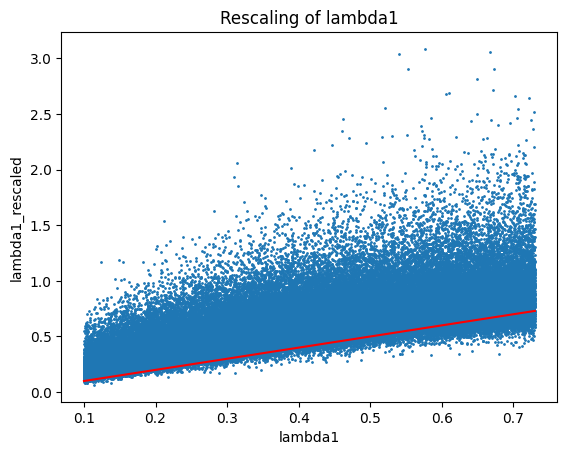

In [11]:
# plot lambda and lambda_rescaled in a way to see where it is rescaling
import matplotlib.pyplot as plt
if model_name == 'bd':
    plt.scatter(param_train['lambda'], param_train['lambda_rescaled'], s=1)
    plt.plot([min(param_train['lambda']), max(param_train['lambda'])], [min(param_train['lambda']), max(param_train['lambda'])], color='red')
else:
    plt.scatter(param_train['lambda1'], param_train['lambda1_rescaled'], s=1)

    plt.plot([min(param_train['lambda1']), max(param_train['lambda1'])], [min(param_train['lambda1']), max(param_train['lambda1'])], color='red')
plt.xlabel('lambda1')
plt.ylabel('lambda1_rescaled')
plt.title('Rescaling of lambda1')
plt.show()

In [12]:
encoding_train.shape

(71749, 96)

In [13]:
# Write to csv
param_train.to_csv(chemin + '/param_train' + expname + ss + '.csv')
param_test.to_csv(chemin + '/param_test' + expname + ss + '.csv')
encoding_train.to_csv(chemin + '/encoding_train' + expname + ss + '.csv')
encoding_test.to_csv(chemin + '/encoding_test' + expname + ss + '.csv')

## Read

In [7]:
import pandas as pd
import os



# Read the data
param_train = pd.read_csv(chemin + '/param_train' + expname + ss + '.csv', index_col=0)
param_test = pd.read_csv(chemin + '/param_test' + expname + ss + '.csv', index_col=0)
encoding_train = pd.read_csv(chemin + '/encoding_train' + expname + ss + '.csv', index_col=0)
encoding_test = pd.read_csv(chemin + '/encoding_test' + expname + ss + '.csv', index_col=0)

## Reorder values

In [8]:
#Choice of the parameters to predict

if model_name == "musse":
    if num_states == 3:
        target1 = 'lambda1_rescaled'
        target2 = 'lambda2_rescaled'
        target3 = 'lambda3_rescaled'
        target4 = 'mu1_rescaled'
        target5 = 'mu2_rescaled'
        target6 = 'mu3_rescaled'
        target7 = 'q12_rescaled'
        target8 = 'q13_rescaled'
        target9 = 'q21_rescaled'
        target10 = 'q23_rescaled'
        target11 = 'q31_rescaled'
        target12 = 'q32_rescaled'
        
        targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12]])
        targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12]])
        
        #targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12]])
        #targets2 = pd.DataFrame(param_train[[target7, target8, target9, target10, target11, target12]])
        #targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12]])
        #targets_test2 = pd.DataFrame(param_test[[target7, target8, target9, target10, target11, target12]])


        
    elif num_states == 4:
        target1 = 'lambda1_rescaled'
        target2 = 'lambda2_rescaled'
        target3 = 'lambda3_rescaled'
        target4 = 'lambda4_rescaled'
        target5 = 'mu1_rescaled'
        target6 = 'mu2_rescaled'
        target7 = 'mu3_rescaled'
        target8 = 'mu4_rescaled'
        target9 = 'q12_rescaled'
        target10 = 'q13_rescaled'
        target11 = 'q14_rescaled'
        target12 = 'q21_rescaled'
        target13 = 'q23_rescaled'
        target14 = 'q24_rescaled'
        target15 = 'q31_rescaled'
        target16 = 'q32_rescaled'
        target17 = 'q34_rescaled'
        target18 = 'q41_rescaled'
        target19 = 'q42_rescaled'
        target20 = 'q43_rescaled'
        
        targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20]])
        targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20]])

        # select the columns of the dataframe that correspond to the target values
        #target = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20]])
        #targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10, target11, target12, target13, target14, target15, target16, target17, target18, target19, target20]])
        
elif model_name == "bd":
    target1 = 'lambda_rescaled'
    target2 = 'mu_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2]])
    targets_test = pd.DataFrame(param_test[[target1, target2]])
    
elif model_name == "bisse":
    target1 = 'lambda1_rescaled'
    target2 = 'lambda2_rescaled'
    target3 = 'mu1_rescaled'
    target4 = 'mu2_rescaled'
    target5 = 'q12_rescaled'
    target6 = 'q21_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6]])
    
elif model_name == "geosse":
    target1 = 'sA_rescaled'
    target2 = 'sB_rescaled'
    target3 = 'sAB_rescaled'
    target4 = 'xA_rescaled'
    target5 = 'xB_rescaled'
    target6 = 'dA_rescaled'
    target7 = 'dB_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7]])
    
elif model_name == "bisseness":
    target1 = 'lambda1_rescaled'
    target2 = 'lambda2_rescaled'
    target3 = 'mu1_rescaled'
    target4 = 'mu2_rescaled'
    target5 = 'q12_rescaled'
    target6 = 'q21_rescaled'
    target7 = 'p1c_rescaled'
    target8 = 'p1a_rescaled'
    target9 = 'p2c_rescaled'
    target10 = 'p2a_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target7, target8, target9, target10]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target7, target8, target9, target10]])
    
elif model_name == "classe":
    target1 = 'lambda111_rescaled'
    target2 = 'lambda112_rescaled'
    target3 = 'lambda122_rescaled'
    target4 = 'lambda211_rescaled'
    target5 = 'lambda212_rescaled'
    target6 = 'lambda222_rescaled'
    target7 = 'mu1_rescaled'
    target8 = 'mu2_rescaled'
    target9 = 'q12_rescaled'
    target10 = 'q21_rescaled'
    
    targets = pd.DataFrame(param_train[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10]])
    targets_test = pd.DataFrame(param_test[[target1, target2, target3, target4, target5, target6, target7, target8, target9, target10]])
    
features = encoding_train
features_test = encoding_test

# how large is the validation set in percentage of the total number of trees
valid_frac = 0.2
train_size_frac = 1 - valid_frac

print(targets.shape)
print(features.shape)
print(targets_test.shape)
print(features_test.shape)


(71749, 12)
(71749, 96)
(17938, 12)
(17938, 96)


In [9]:
import numpy as np

# For each target vector, reorder the states based on lambdas: find the order of lambdas and reorder all the states and their parameters accordingly (also mu and qij)
# First, get the order of lambdas
if model_name == 'bd':
    lambdas = ['lambda_rescaled']
    mus = ['mu_rescaled']
    qij = []
elif model_name == 'bisse':
    lambdas = ['lambda1_rescaled', 'lambda2_rescaled']
    mus = ['mu1_rescaled', 'mu2_rescaled']
    qij = ['q12_rescaled', 'q21_rescaled']
elif model_name == 'musse':
    if num_states == 3:
        lambdas = ['lambda1_rescaled', 'lambda2_rescaled', 'lambda3_rescaled']
        mus = ['mu1_rescaled', 'mu2_rescaled', 'mu3_rescaled']
        qij = ['q12_rescaled', 'q13_rescaled', 'q21_rescaled', 'q23_rescaled', 'q31_rescaled', 'q32_rescaled']
    elif num_states == 4:
        lambdas = ['lambda1_rescaled', 'lambda2_rescaled', 'lambda3_rescaled', 'lambda4_rescaled']
        mus = ['mu1_rescaled', 'mu2_rescaled', 'mu3_rescaled', 'mu4_rescaled']
        qij = ['q12_rescaled', 'q13_rescaled', 'q14_rescaled', 'q21_rescaled', 'q23_rescaled', 'q24_rescaled', 'q31_rescaled', 'q32_rescaled', 'q34_rescaled', 'q41_rescaled', 'q42_rescaled', 'q43_rescaled']
elif model_name == 'geosse':
    lambdas = ['sA_rescaled', 'sB_rescaled', 'sAB_rescaled', 'xA_rescaled', 'xB_rescaled', 'dA_rescaled', 'dB_rescaled']
    mus = []
    qij = []
elif model_name == 'bisseness':
    lambdas = ['lambda1_rescaled', 'lambda2_rescaled']
    mus = ['mu1_rescaled', 'mu2_rescaled']
    qij = ['q12_rescaled', 'q21_rescaled', 'p1c_rescaled', 'p1a_rescaled', 'p2c_rescaled', 'p2a_rescaled']
elif model_name == 'classe':
    lambdas = ['lambda111_rescaled', 'lambda112_rescaled', 'lambda122_rescaled', 'lambda211_rescaled', 'lambda212_rescaled', 'lambda222_rescaled']
    mus = ['mu1_rescaled', 'mu2_rescaled']
    qij = ['q12_rescaled', 'q21_rescaled']
    
# Check that the number of columns is correct
assert len(lambdas) + len(mus) + len(qij) == targets.shape[1]

# For each row, reorder the states based on the order of lambdas, so that lambdas are in increasing order, and their corresponding mu and qij are also reordered

# First, get the order of lambdas
order = np.argsort(targets[lambdas].values, axis=1)
order_test = np.argsort(targets_test[lambdas].values, axis=1)

# Check that the order is correct
assert order.shape == targets[lambdas].values.shape
assert order_test.shape == targets_test[lambdas].values.shape

# Reorder lambdas, mus and qij
targets[lambdas] = np.take_along_axis(targets[lambdas].values, order, axis=1)
targets[mus] = np.take_along_axis(targets[mus].values, order, axis=1)

# qij is a bit more complicated, because it is a square matrix
qij_values = targets[qij].values
qij_values = qij_values.reshape(qij_values.shape[0], int(qij_values.shape[1] / 2), 2)
qij_values = np.take_along_axis(qij_values, order[:, :, None], axis=1)
qij_values = qij_values.reshape(qij_values.shape[0], qij_values.shape[1] * qij_values.shape[2])
targets[qij] = qij_values

# Check that the order is correct
assert order.shape == targets[lambdas].values.shape
assert order_test.shape == targets_test[lambdas].values.shape

# Check that the reordering is correct
print(targets.head())

# Reorder lambdas, mus and qij
targets_test[lambdas] = np.take_along_axis(targets_test[lambdas].values, order_test, axis=1)
targets_test[mus] = np.take_along_axis(targets_test[mus].values, order_test, axis=1)

# qij is a bit more complicated, because it is a square matrix
qij_values_test = targets_test[qij].values
qij_values_test = qij_values_test.reshape(qij_values_test.shape[0], int(qij_values_test.shape[1] / 2), 2)
qij_values_test = np.take_along_axis(qij_values_test, order_test[:, :, None], axis=1)
qij_values_test = qij_values_test.reshape(qij_values_test.shape[0], qij_values_test.shape[1] * qij_values_test.shape[2])
targets_test[qij] = qij_values_test

# Check that the order is correct
assert order_test.shape == targets_test[lambdas].values.shape

# Check that the reordering is correct
print(targets_test.head())


   lambda1_rescaled  lambda2_rescaled  lambda3_rescaled  mu1_rescaled  \
0          0.600222          0.751063          1.035059      0.545126   
1          0.396367          0.440498          0.608900      0.132756   
2          0.175214          0.416206          0.635032      0.083709   
3          0.331723          0.748934          0.795995      0.313814   
4          0.474275          0.649481          0.662325      0.448639   

   mu2_rescaled  mu3_rescaled  q12_rescaled  q13_rescaled  q21_rescaled  \
0      0.151476      0.929887      1.921776      1.411762      1.921776   
1      0.197156      0.047302      0.667669      0.828423      0.667669   
2      0.245484      0.086926      0.558544      0.522988      0.330426   
3      0.536315      0.022320      0.209465      0.534279      0.209465   
4      0.522419      0.003085      0.278167      0.225941      0.278167   

   q23_rescaled  q31_rescaled  q32_rescaled  
0      0.335580      1.411762      0.335580  
1      0.814753   

In [10]:
#Add the known sampling fraction into the representation (both train and test sets)
add_target = "sampling_frac"
added_targets = 1 #pd.DataFrame(param_train[add_target])
features['399'] = added_targets
print(features.shape)

add_target_2 = "sampling_frac"
added_targets_2 = 1 #pd.DataFrame(param_test[add_target])
features_test['399'] = added_targets_2
print(features_test.shape)

(71749, 97)
(17938, 97)


In [11]:
print("Validation set fraction: ", valid_frac)
print("Training set fraction: ", train_size_frac)

Validation set fraction:  0.2
Training set fraction:  0.8


In [12]:
'''
#Add the known sampling fraction as 3*2 matrix into the representation (both train and test sets)
add_target = "sampling_frac"
added_targets = pd.DataFrame(param_train[add_target])
features['1003'] = added_targets
features['1004'] = added_targets
features['1005'] = added_targets
features['1006'] = added_targets
features['1007'] = added_targets
features['1008'] = added_targets

added_targets2 = pd.DataFrame(param_test[add_target])
features_test['1003'] = added_targets2
features_test['1004'] = added_targets2
features_test['1005'] = added_targets2
features_test['1006'] = added_targets2
features_test['1007'] = added_targets2
features_test['1008'] = added_targets2
'''

'\n#Add the known sampling fraction as 3*2 matrix into the representation (both train and test sets)\nadd_target = "sampling_frac"\nadded_targets = pd.DataFrame(param_train[add_target])\nfeatures[\'1003\'] = added_targets\nfeatures[\'1004\'] = added_targets\nfeatures[\'1005\'] = added_targets\nfeatures[\'1006\'] = added_targets\nfeatures[\'1007\'] = added_targets\nfeatures[\'1008\'] = added_targets\n\nadded_targets2 = pd.DataFrame(param_test[add_target])\nfeatures_test[\'1003\'] = added_targets2\nfeatures_test[\'1004\'] = added_targets2\nfeatures_test[\'1005\'] = added_targets2\nfeatures_test[\'1006\'] = added_targets2\nfeatures_test[\'1007\'] = added_targets2\nfeatures_test[\'1008\'] = added_targets2\n'

In [13]:
# explore the data
print(features.shape)
print(targets.shape)
print(features_test.shape)

# print keys of target
print(targets.keys())
print(targets_test.keys())

(71749, 97)
(71749, 12)
(17938, 97)
Index(['lambda1_rescaled', 'lambda2_rescaled', 'lambda3_rescaled',
       'mu1_rescaled', 'mu2_rescaled', 'mu3_rescaled', 'q12_rescaled',
       'q13_rescaled', 'q21_rescaled', 'q23_rescaled', 'q31_rescaled',
       'q32_rescaled'],
      dtype='object')
Index(['lambda1_rescaled', 'lambda2_rescaled', 'lambda3_rescaled',
       'mu1_rescaled', 'mu2_rescaled', 'mu3_rescaled', 'q12_rescaled',
       'q13_rescaled', 'q21_rescaled', 'q23_rescaled', 'q31_rescaled',
       'q32_rescaled'],
      dtype='object')


In [14]:
features.describe()

2             3             4             5             6  \
count  7.174900e+04  71749.000000  71749.000000  71749.000000  71749.000000   
mean   1.000000e+00      0.620937      1.304944      0.922633      0.575697   
std    1.257807e-16      0.055686      0.262612      0.082807      0.096244   
min    1.000000e+00      0.203133      0.546828      0.328740      0.107989   
25%    1.000000e+00      0.591008      1.141672      0.875257      0.517420   
50%    1.000000e+00      0.625554      1.253408      0.928708      0.579335   
75%    1.000000e+00      0.655457      1.404668      0.975855      0.636466   
max    1.000000e+00      1.038869      8.182325      1.396306      1.525527   

                  7             8             9            10            11  \
count  71749.000000  71749.000000  71749.000000  71749.000000  71749.000000   
mean       1.118499      1.105903      0.886613      1.303811      1.224022   
std        0.230025      0.564317      0.664621      1.567397      0.689134   
min        0.112216      0.000000      0.000000      0.000000      0.000000   
25%        0.987236      0.755322      0.479470      0.449042      0.798970   
50%        1.097305      0.996912      0.722729      0.819650      1.078393   
75%        1.221419      1.341397      1.100764      1.549682      1.489286   
max        5.293049      6.845619      9.957123     33.985115     10.580956   

       ...            89            90            91            92  \
count  ...  71749.000000  71749.000000  71749.000000  71749.000000   
mean   ...      2.160314      2.528329      2.942270      3.437063   
std    ...      0.267278      0.292744      0.330461      0.393532   
min    ...      0.580249      0.729807      0.890938      1.117367   
25%    ...      2.009695      2.360539      2.748099      3.194338   
50%    ...      2.144462      2.510516      2.919509      3.404533   
75%    ...      2.284775      2.667303      3.106224      3.638800   
max    ...      5.773730      6.178295      6.755599      7.559249   

                 93            94            95            96            97  \
count  71749.000000  71749.000000  71749.000000  71749.000000  71749.000000   
mean       4.084176      5.093795      8.760386      2.916541    509.741948   
std        0.506453      0.746713      2.360525      1.408236    283.254318   
min        1.456910      1.688383      1.709290      0.020969     21.000000   
25%        3.765503      4.620034      7.250359      2.084967    263.000000   
50%        4.030625      4.998819      8.450293      2.614974    510.000000   
75%        4.344657      5.466095      9.905115      3.369704    755.000000   
max       10.887679     11.564941     50.418451     33.002975   1000.000000   

           399  
count  71749.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0  

[8 rows x 97 columns]

In [15]:
targets.describe()

lambda1_rescaled  lambda2_rescaled  lambda3_rescaled  mu1_rescaled  \
count      71749.000000      71749.000000      71749.000000  71749.000000   
mean           0.396590          0.643588          0.917669      0.186070   
std            0.147009          0.177722          0.259972      0.146623   
min            0.064675          0.098086          0.331414      0.000004   
25%            0.282733          0.533534          0.737415      0.071799   
50%            0.388514          0.628728          0.860084      0.152974   
75%            0.497008          0.737378          1.032619      0.266003   
max            1.385888          2.230258          3.445192      1.349252   

       mu2_rescaled  mu3_rescaled  q12_rescaled  q13_rescaled  q21_rescaled  \
count  71749.000000  71749.000000  71749.000000  71749.000000  71749.000000   
mean       0.298936      0.424964      0.852040      0.841470      0.846792   
std        0.231400      0.356174      0.542799      0.531307      0.538933   
min        0.000016      0.000003      0.066521      0.078914      0.075931   
25%        0.113362      0.143976      0.447580      0.451597      0.446289   
50%        0.250884      0.338271      0.758176      0.750460      0.753756   
75%        0.437443      0.623415      1.121094      1.096769      1.111545   
max        2.157437      3.292270      7.041778      6.652009      7.041778   

       q23_rescaled  q31_rescaled  q32_rescaled  
count  71749.000000  71749.000000  71749.000000  
mean       0.847575      0.845374      0.851753  
std        0.534786      0.527826      0.544199  
min        0.070526      0.070555      0.066521  
25%        0.450952      0.454400      0.446090  
50%        0.754360      0.756358      0.757506  
75%        1.111747      1.104828      1.121809  
max        5.682737      5.789247      6.652009

In [16]:
if model_name == "musse" and len(targets.columns) <= 6:
    targets2.describe()

In [17]:
#Standardization of the input features: done for summary statistics
import sklearn
from sklearn.preprocessing import StandardScaler

#Standardization of the input features

old_features = features
old_features_test = features_test

scale = StandardScaler()
features = scale.fit_transform(features)
features_test = scale.transform(features_test)


X = features
Y = targets

Y_test = targets_test
X_test = features_test

if model_name == "musse" and len(targets.columns) <= 6:
    Y2 = targets2
    Y2_test = targets_test2
    
    



In [18]:
print(old_features["399"])
print(features[:, -1])

0        1
1        1
2        1
3        1
4        1
        ..
72497    1
72498    1
72499    1
72500    1
72501    1
Name: 399, Length: 71749, dtype: int64
[0. 0. 0. ... 0. 0. 0.]


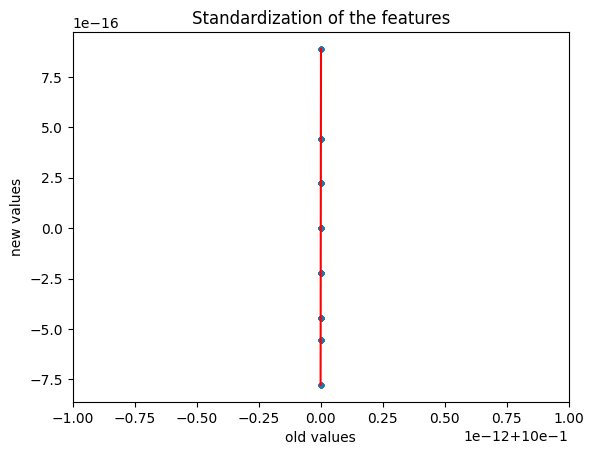

[0.00000000e+00 0.00000000e+00 2.22044605e-16 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
72497    1.0
72498    1.0
72499    1.0
72500    1.0
72501    1.0
Name: 2, Length: 71749, dtype: float64
2.0559914881314658e-17
1.240880649258644e-16
1.0
1.2577979947898008e-16


In [19]:
# Plot the old and new values of the features to see the effect of standardization
import matplotlib.pyplot as plt
plt.scatter(x=old_features.iloc[:, 0], y=features[:, 0], s=10)
plt.plot([min(old_features.iloc[:, 0]), max(old_features.iloc[:, 0])], [min(features[:, 0]), max(features[:, 0])], color='red')
plt.xlabel('old values')
plt.ylabel('new values')
plt.title('Standardization of the features')
plt.show()

print(features[:, 0])
print(old_features.iloc[:, 0])

import numpy as np
print(np.mean(features[:, 0]))
print(np.std(features[:, 0]))

print(np.mean(old_features.iloc[:, 0]))
print(np.std(old_features.iloc[:, 0]))

In [20]:
X_test

array([[ 0.        ,  0.48085956, -0.96404545, ..., -1.04522555,
        -0.54277379,  0.        ],
       [ 0.        , -0.51497548, -1.1809906 , ...,  0.17479398,
        -1.5913088 ,  0.        ],
       [ 0.        , -2.58251071,  3.22380755, ...,  3.05509809,
        -0.36625274,  0.        ],
       ...,
       [ 0.        , -0.46544541,  0.54837874, ...,  0.54383612,
         1.65314802,  0.        ],
       [ 0.        ,  0.94124534, -1.31242982, ..., -0.49344855,
        -1.50304828,  0.        ],
       [ 0.        ,  1.05653086, -0.42382857, ..., -0.78480684,
        -1.29122302,  0.        ]])

In [21]:
print(features.shape)

(71749, 97)


In [22]:
"""
%pip install keras --upgrade -q
#%pip install --upgrade protobuf
%pip install --upgrade pandas -q
%pip install protobuf==3.20 -q
%pip install tensorflow -q
"""

'\n%pip install keras --upgrade -q\n#%pip install --upgrade protobuf\n%pip install --upgrade pandas -q\n%pip install protobuf==3.20 -q\n%pip install tensorflow -q\n'

## Models

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from tensorflow.keras import layers, Model
from keras.layers import LeakyReLU

# Input shape: (71749, 97)

# CNN + FFNN
def build_model_cnn(output_size = targets.shape[1]):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='linear', input_shape=(features.shape[1], 1)))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(32, 3, activation='linear'))
    model.add(MaxPooling1D(3))
    
    model.add(Flatten())
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Fully connected layers
    model.add(Dense(64, activation='linear', kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='linear', kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='linear', kernel_regularizer='l2'))
    model.add(Dropout(0.3))
    model.add(Dense(output_size, activation='linear', kernel_regularizer='l2'))
    return model

# FFNN
def build_model_ffnn(output_size = targets.shape[1]):
    model = Sequential()
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation="linear", kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation="linear", kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation="linear", kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation="linear", kernel_regularizer='l2'))
    return model

# GRU

def build_model_gru(output_size = targets.shape[1]):
    model = Sequential()
    model.add(layers.GRU(64, return_sequences=True, input_shape=(features.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(layers.GRU(32))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='relu'))
    model.summary()
    return model
    

# CNN + LSTM
def build_model_lstm(output_size = targets.shape[1]):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='linear',kernel_regularizer='l2', input_shape=(features.shape[1], 1)))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(32, 3, activation='linear',kernel_regularizer='l2'))
    model.add(MaxPooling1D(3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='linear',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='linear',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='linear',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='linear',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='linear',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='linear',kernel_regularizer='l2'))
    model.summary()
    return model

def build_model_dense(output_size = targets.shape[1]):
    model = Sequential()
    model.add(Dense(output_size, input_dim=X.shape[1]))
    model.add(Activation('relu'))
    return model



In [96]:
## Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

model = RandomForestRegressor(n_estimators=1000, max_depth=100, random_state=0, n_jobs=-1, verbose=1)
model.fit(X, Y)
y_pred = model.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
acc = model.score(X_test, Y_test)
print("Mean squared error: ", mse)
print("Accuracy: ", acc)
# save
import pickle
filename = chemin + '/model' + expname + ss + '.sav'
pickle.dump(model, open(filename, 'wb'))

# feature importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

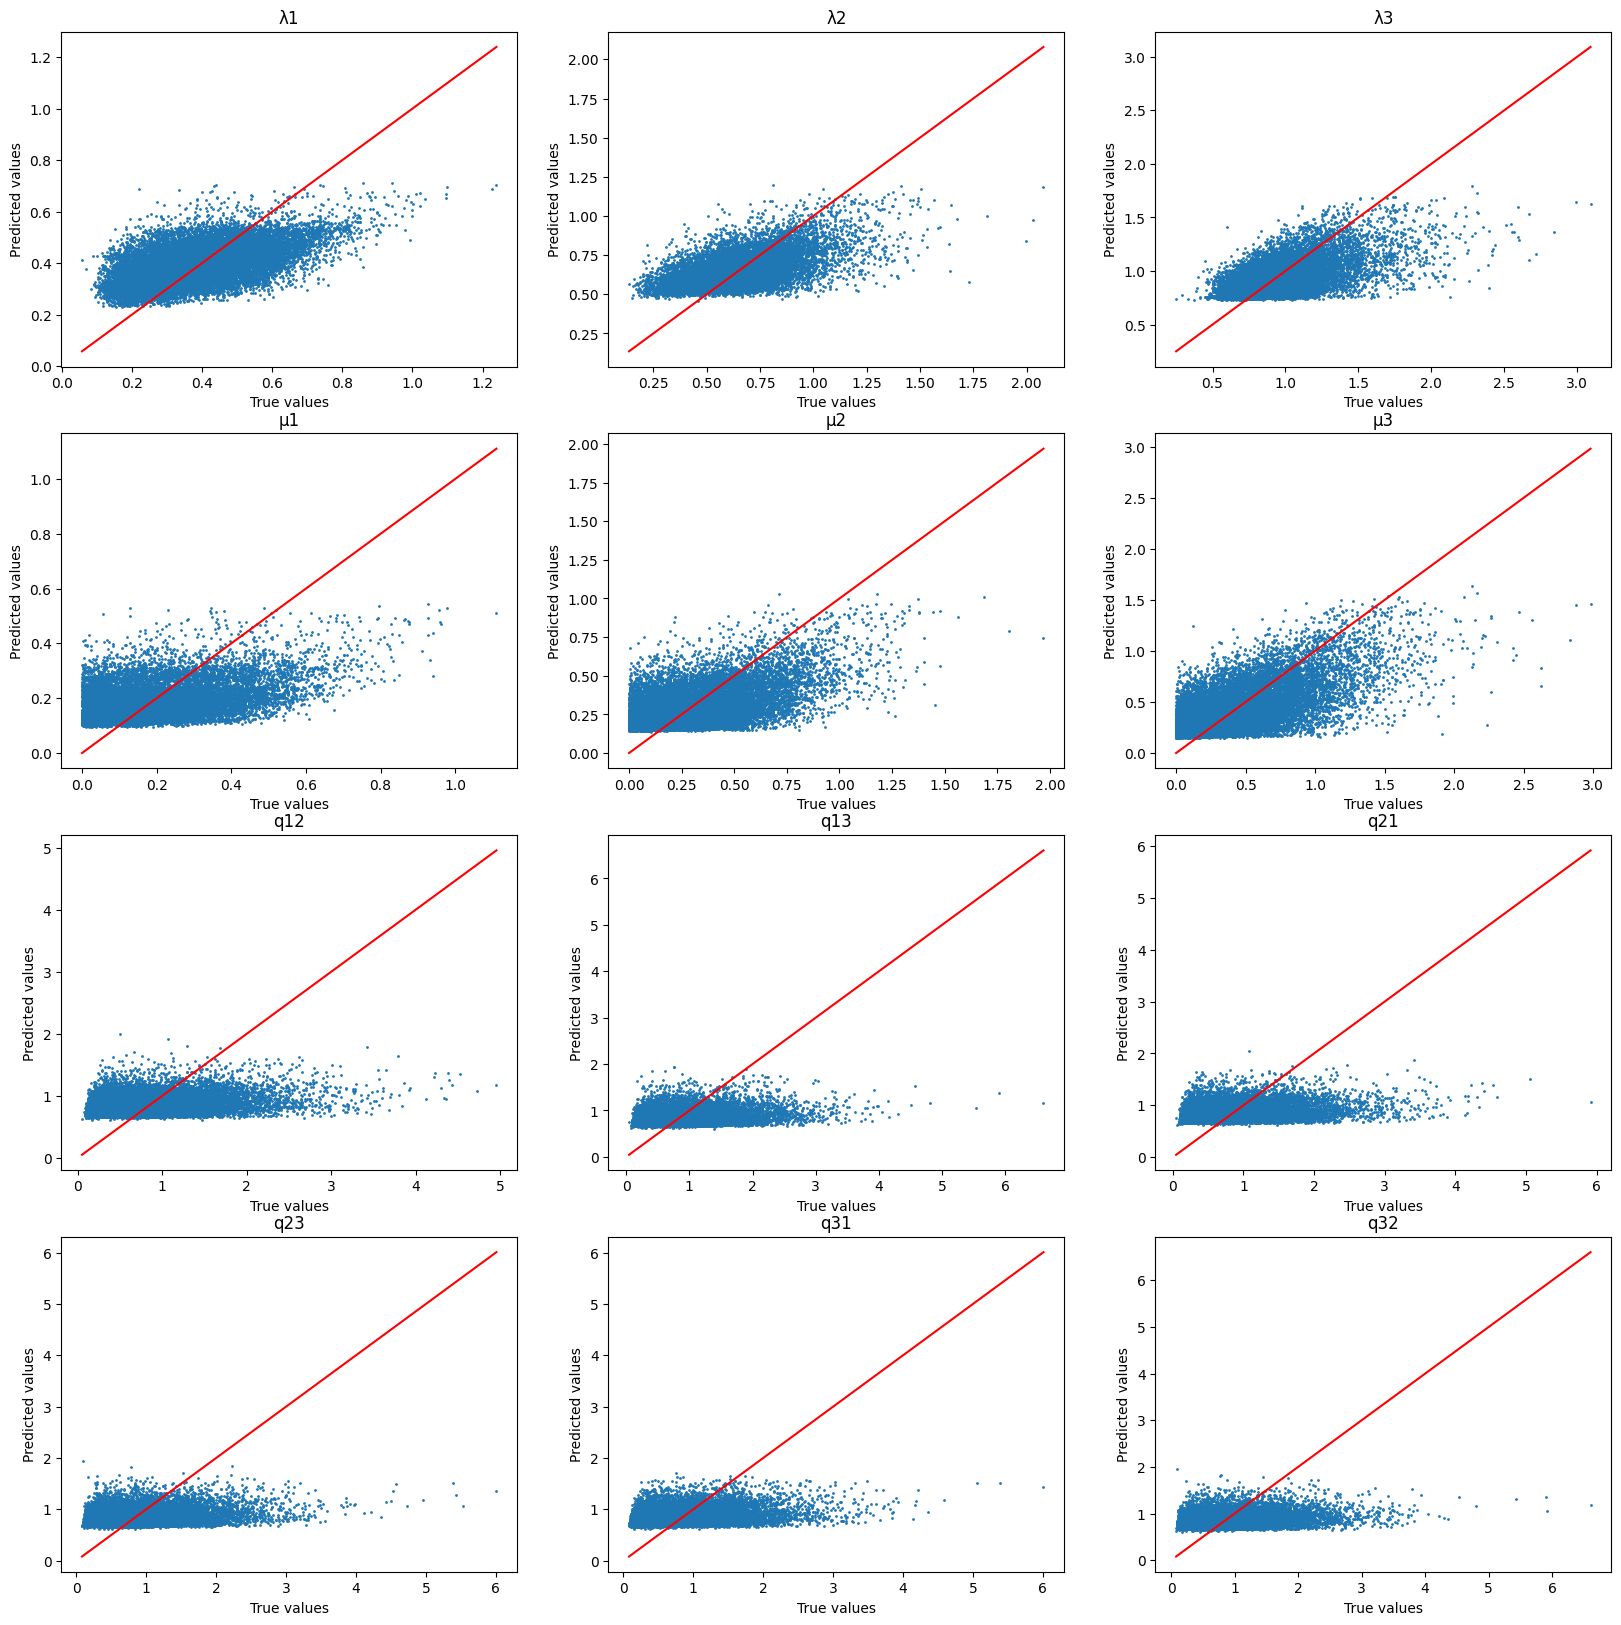

In [ ]:
# plot true vs predicted values for random forest
# rename columns with symbols
Y_test.columns = ['λ1', 'λ2', 'λ3', 'μ1', 'μ2', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
ax, fig = plt.subplots(4, 3, figsize=(20, 20))
for i in range(Y_test.shape[1]):
    ax = plt.subplot(4, 3, i+1)
    ax.scatter(Y_test.iloc[:, i], y_pred[:, i], s=1)
    ax.plot([min(Y_test.iloc[:, i]), max(Y_test.iloc[:, i])], [min(Y_test.iloc[:, i]), max(Y_test.iloc[:, i])], color='red')
    ax.set_xlabel('True values')
    ax.set_ylabel('Predicted values')
    ax.set_title(Y_test.columns[i])
plt.show()


In [87]:
#Possibility of using a "multi gpu" estimator (but doesn't work quite well for me...), and other optimizers (the default Adam optimizer seems to be the better one, though)
'''
parallel_estimator = multi_gpu_model(model, gpus=2)
optimizer = tf.train.RMSPropOptimizer(0.001)
'''
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_cnn = build_model_cnn()
model_ffnn = build_model_ffnn(targets.shape[1])
model_lstm = build_model_lstm()
model_gru = build_model_gru()
model_dense = build_model_dense()

model_names_list = ['cnn', 'ffnn', 'dense']

temp_targets = targets

for model_n in model_names_list:
    if model_n == 'cnn':
        model = model_cnn
    elif model_n == 'ffnn':
        model = model_ffnn
    elif model_n == 'lstm':
        model = model_lstm
    elif model_n == 'gru':
        model = model_gru
    elif model_n == 'dense':
        model = model_dense

    # Compiling the model with a custom initial learning rate for Adam optimizer
    initial_learning_rate = 0.0001  # Custom initial learning rate
    #adam_optimizer = Adam(initial_learning_rate=initial_learning_rate)


    adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
    SGD = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    #model.compile(optimizer = SGD, loss = "categorical_crossentropy", metrics=['accuracy'])
    model.compile(optimizer="adam", loss='mean_squared_error', metrics=['accuracy'])


    # Learning rate scheduler function
    def lr_scheduler(epoch, lr):
        if epoch % 100 == 0 and epoch:
            return lr * 0.8
        return lr

    
    # Learning rate scheduler callback
    lr_schedule = LearningRateScheduler(lr_scheduler)

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10)

    #display training progress for each completed epoch.
    class PrintDot(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,logs):
            if epoch % 10 == 0: print('')
            print('.', end='')


    # Check if GPU is available
    if tf.test.is_gpu_available():
        print("GPU is available")
    else:
        print("GPU is NOT available")

    # Force TensorFlow to use GPU if available
    if tf.test.is_gpu_available():
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        session = tf.compat.v1.Session(config=config)
        tf.compat.v1.keras.backend.set_session(session)
        
    # model checkpoint
    checkpoint = ModelCheckpoint(chemin + '/model_' + model_n + ss + special_name + '.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


    if model_name != "musse":
        # Training the model on GPU
        with tf.device('/GPU:0'):
            history = model.fit(X, Y, epochs=1000, validation_split=valid_frac, batch_size=128, callbacks=[early_stop, PrintDot(), checkpoint])
            
        # Save the model based on the model name
        model.save(chemin + '/model_' + model_n + ss + special_name + '.h5')
    
        
    ## Musse couples
        
    elif model_name == "musse":
        # rename columns for the model
        Y.columns = ['lambda1_rescaled', 'lambda2_rescaled', 'lambda3_rescaled', 'mu1_rescaled', 'mu2_rescaled', 'mu3_rescaled', 'q12_rescaled', 'q13_rescaled', 'q21_rescaled', 'q23_rescaled', 'q31_rescaled', 'q32_rescaled']
        Y_test.columns = ['lambda1_rescaled', 'lambda2_rescaled', 'lambda3_rescaled', 'mu1_rescaled', 'mu2_rescaled', 'mu3_rescaled', 'q12_rescaled', 'q13_rescaled', 'q21_rescaled', 'q23_rescaled', 'q31_rescaled', 'q32_rescaled']
        
        couples_list = [False] #, False]
        for couples in couples_list:
            if couples:
                # predict only lambda1 and mu1, then lambda2 and mu2, then lambda3 and mu3, then q12, q13, q21, q23, q31, q32
                Y1 = Y[['lambda1_rescaled', 'mu1_rescaled']]
                Y2 = Y[['lambda2_rescaled', 'mu2_rescaled']]
                Y3 = Y[['lambda3_rescaled', 'mu3_rescaled']]
                Y4 = Y[['q12_rescaled', 'q13_rescaled', 'q23_rescaled']]
                
                Y1_test = Y_test[['lambda1_rescaled', 'mu1_rescaled']]
                Y2_test = Y_test[['lambda2_rescaled', 'mu2_rescaled']]
                Y3_test = Y_test[['lambda3_rescaled', 'mu3_rescaled']]
                Y4_test = Y_test[['q12_rescaled', 'q13_rescaled', 'q21_rescaled', 'q23_rescaled', 'q31_rescaled', 'q32_rescaled']]
                
                if model_n == 'ffnn':
                    
                    model1 = build_model_ffnn(2)
                    model2 = build_model_ffnn(2)
                    model3 = build_model_ffnn(2)
                    model4 = build_model_ffnn(6)
                    
                elif model_n == 'cnn':
                    
                    model1 = build_model_cnn(2)
                    model2 = build_model_cnn(2)
                    model3 = build_model_cnn(2)
                    model4 = build_model_cnn(6)
                    
                elif model_n == 'lstm':
                    
                    model1 = build_model_lstm(2)
                    model2 = build_model_lstm(2)
                    model3 = build_model_lstm(2)
                    model4 = build_model_lstm(6)
                    
                elif model_n == 'gru':
                    
                    model1 = build_model_gru(2)
                    model2 = build_model_gru(2)
                    model3 = build_model_gru(2)
                    model4 = build_model_gru(6)
                    
                elif model_n == 'dense':
                    
                    model1 = build_model_dense(2)
                    model2 = build_model_dense(2)
                    model3 = build_model_dense(2)
                    model4 = build_model_dense(6)
                    
                
                adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
                
                model1.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
                model2.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
                model3.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
                model4.compile(optimizer=adam, loss='mean_squared_error', metrics=['accuracy'])
                
                
                checkpoint1 = ModelCheckpoint(chemin + '/model_' + model_n + ss + special_name + '_1.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
                checkpoint2 = ModelCheckpoint(chemin + '/model_' + model_n + ss + special_name + '_2.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
                checkpoint3 = ModelCheckpoint(chemin + '/model_' + model_n + ss + special_name + '_3.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
                checkpoint4 = ModelCheckpoint(chemin + '/model_' + model_n + ss + special_name + '_4.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
                
                with tf.device('/GPU:0'):
                    history1 = model1.fit(X, Y1, epochs=1000, validation_split=valid_frac, batch_size=128, callbacks=[early_stop, PrintDot(), checkpoint1])
                    history2 = model2.fit(X, Y2, epochs=1000, validation_split=valid_frac, batch_size=128, callbacks=[early_stop, PrintDot(), checkpoint2])
                    history3 = model3.fit(X, Y3, epochs=1000, validation_split=valid_frac, batch_size=128, callbacks=[early_stop, PrintDot(), checkpoint3])
                    history4 = model4.fit(X, Y4, epochs=1000, validation_split=valid_frac, batch_size=128, callbacks=[early_stop, PrintDot(), checkpoint4])
                    

            else:
                
                targets = temp_targets
                
                if model_n == 'ffnn':
                    model = build_model_ffnn(targets.shape[1])
                elif model_n == 'cnn':
                    model = build_model_cnn(targets.shape[1])
                elif model_n == 'lstm':
                    model = build_model_lstm(targets.shape[1])
                elif model_n == 'gru':
                    model = build_model_gru(targets.shape[1])
                elif model_n == 'dense':
                    model = build_model_dense(targets.shape[1])
                    
                adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
                model.compile(optimizer="adam", loss='mean_squared_error', metrics=['accuracy'])

                # Training the model on GPU
                with tf.device('/GPU:0'):  # Specify GPU device
                    history = model.fit(X, Y, epochs=1000, validation_split=valid_frac, batch_size=128, callbacks=[early_stop, PrintDot(), checkpoint])
            
        # Save the model based on the model name
        if couples:
            model1.save(chemin + '/model_' + model_n + ss + special_name + '_1.h5')
            model2.save(chemin + '/model_' + model_n + ss + special_name + '_2.h5')
            model3.save(chemin + '/model_' + model_n + ss + special_name + '_3.h5')
            model4.save(chemin + '/model_' + model_n + ss + special_name + '_4.h5')
        else:
            model.save(chemin + '/model_' + model_n + ss + special_name + '.h5')
    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 95, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 31, 64)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 29, 32)            6176      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 9, 32)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 9, 64)             24832     
                                                                 
 dropout_7 (Dropout)         (None, 9, 64)            

c:\Users\matti\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)



Epoch 1/1000
449/449 [==============================] - ETA: 0s - loss: 1.9144 - accuracy: 0.1282
.
Epoch 1: val_loss improved from inf to 1.10125, saving model to ./trained_models/SS/musse\model_cnn_ss_reordered.h5
449/449 [==============================] - 15s 13ms/step - loss: 1.9144 - accuracy: 0.1282 - val_loss: 1.1013 - val_accuracy: 0.2088
Epoch 2/1000
447/449 [============================>.] - ETA: 0s - loss: 0.7962 - accuracy: 0.1579.
Epoch 2: val_loss improved from 1.10125 to 0.50820, saving model to ./trained_models/SS/musse\model_cnn_ss_reordered.h5
449/449 [==============================] - 5s 12ms/step - loss: 0.7953 - accuracy: 0.1579 - val_loss: 0.5082 - val_accuracy: 0.2388
Epoch 3/1000
446/449 [============================>.] - ETA: 0s - loss: 0.3727 - accuracy: 0.1735.
Epoch 3: val_loss improved from 0.50820 to 0.26293, saving model to ./trained_models/SS/musse\model_cnn_ss_reordered.h5
449/449 [==============================] - 5s 10ms/step - loss: 0.3719 - accurac

c:\Users\matti\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/1000
447/449 [============================>.] - ETA: 0s - loss: 1.8909 - accuracy: 0.1207
.
Epoch 1: val_loss improved from inf to 0.63659, saving model to ./trained_models/SS/musse\model_ffnn_ss_reordered.h5
449/449 [==============================] - 9s 16ms/step - loss: 1.8873 - accuracy: 0.1208 - val_loss: 0.6366 - val_accuracy: 0.2463
Epoch 2/1000
445/449 [============================>.] - ETA: 0s - loss: 0.4397 - accuracy: 0.1553.
Epoch 2: val_loss improved from 0.63659 to 0.23989, saving model to ./trained_models/SS/musse\model_ffnn_ss_reordered.h5
449/449 [==============================] - 6s 14ms/step - loss: 0.4386 - accuracy: 0.1556 - val_loss: 0.2399 - val_accuracy: 0.2449
Epoch 3/1000
449/449 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.2176.
Epoch 3: val_loss improved from 0.23989 to 0.17401, saving model to ./trained_models/SS/musse\model_ffnn_ss_reordered.h5
449/449 [==============================] - 6s 13ms/step - loss: 0.2071 - accura

c:\Users\matti\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


444/449 [============================>.] - ETA: 0s - loss: 0.4067 - accuracy: 0.1212
.
Epoch 1: val_loss improved from inf to 0.27691, saving model to ./trained_models/SS/musse\model_dense_ss_reordered.h5
449/449 [==============================] - 5s 6ms/step - loss: 0.4054 - accuracy: 0.1215 - val_loss: 0.2769 - val_accuracy: 0.1379
Epoch 2/1000
447/449 [============================>.] - ETA: 0s - loss: 0.2397 - accuracy: 0.1584.
Epoch 2: val_loss improved from 0.27691 to 0.21135, saving model to ./trained_models/SS/musse\model_dense_ss_reordered.h5
449/449 [==============================] - 2s 5ms/step - loss: 0.2396 - accuracy: 0.1586 - val_loss: 0.2114 - val_accuracy: 0.1678
Epoch 3/1000
445/449 [============================>.] - ETA: 0s - loss: 0.1820 - accuracy: 0.1752.
Epoch 3: val_loss improved from 0.21135 to 0.16479, saving model to ./trained_models/SS/musse\model_dense_ss_reordered.h5
449/449 [==============================] - 2s 5ms/step - loss: 0.1821 - accuracy: 0.1751 - 

In [88]:
# Load the models and predict the targets for each model, then save the predictions
from tensorflow.keras.models import load_model

model_cnn = load_model(chemin + '/model_' + 'cnn' + ss + special_name + '.h5')

model_ffnn = load_model(chemin + '/model_' + 'ffnn' + ss + special_name + '.h5')

model_dense = load_model(chemin + '/model_' + 'dense' + ss + special_name + '.h5')

model_names_list = ['cnn', 'ffnn', 'dense']

for model_n in model_names_list:
    if model_n == 'cnn':
        model = model_cnn
    elif model_n == 'ffnn':
        model = model_ffnn
    elif model_n == 'lstm':
        model = model_lstm
    elif model_n == 'gru':
        model = model_gru
    elif model_n == 'dense':
        model = model_dense
    if model_name != "musse":
        Y_pred = model.predict(X_test)
        Y_pred = pd.DataFrame(Y_pred, columns=targets.columns)
        Y_pred.to_csv(chemin + '/Y_pred_' + model_n + ss + special_name + '.csv')
    elif model_name == "musse":
        # couples_list = [False] #, False]
        # for couples in couples_list:
        #     if couples:
        #         model1 = load_model(chemin + '/model_ffnn' + ss + special_name + '_1.h5')
        #         model2 = load_model(chemin + '/model_ffnn' + ss + special_name + '_2.h5')
        #         model3 = load_model(chemin + '/model_ffnn' + ss + special_name + '_3.h5')
        #         model4 = load_model(chemin + '/model_ffnn' + ss + special_name + '_4.h5')
        #         Y1_pred = model1.predict(X_test)
        #         Y1_pred = pd.DataFrame(Y1_pred, columns=['lambda1_rescaled', 'mu1_rescaled'])
        #         Y1_pred.to_csv(chemin + '/Y1_pred_' + model_n + ss + special_name + '.csv')
        #         Y2_pred = model2.predict(X_test)
        #         Y2_pred = pd.DataFrame(Y2_pred, columns=['lambda2_rescaled', 'mu2_rescaled'])
        #         Y2_pred.to_csv(chemin + '/Y2_pred_' + model_n + ss + special_name + '.csv')
        #         Y3_pred = model3.predict(X_test)
        #         Y3_pred = pd.DataFrame(Y3_pred, columns=['lambda3_rescaled', 'mu3_rescaled'])
        #         Y3_pred.to_csv(chemin + '/Y3_pred_' + model_n + ss + special_name + '.csv')
        #         Y4_pred = model4.predict(X_test)
        #         Y4_pred = pd.DataFrame(Y4_pred, columns=['q12_rescaled', 'q13_rescaled', 'q21_rescaled', 'q23_rescaled', 'q31_rescaled', 'q32_rescaled'])
        #         Y4_pred.to_csv(chemin + '/Y4_pred_' + model_n + ss + special_name + '.csv')
        #     else:
        Y_pred = model.predict(X_test)
        Y_pred = pd.DataFrame(Y_pred, columns=targets.columns)
        
        Y_pred.to_csv(chemin + '/Y_pred_' + model_n + ss + special_name + '.csv')
                

561/561 [==============================] - 1s 2ms/step


In [ ]:
# check that the predictions are different
Y_pred_cnn = pd.read_csv(chemin + '/Y_pred_cnn' + ss + special_name + '.csv')
Y_pred_ffnn = pd.read_csv(chemin + '/Y_pred_ffnn' + ss + special_name + '.csv')
Y_pred_dense = pd.read_csv(chemin + '/Y_pred_dense' + ss + special_name + '.csv')

print(Y_pred_cnn.head())
print(Y_pred_ffnn.head())
print(Y_pred_dense.head())

In [89]:
model_names_list = ['cnn', 'ffnn', 'dense']

for model_n in model_names_list:
    if model_name == "musse":
            couples_list = [False] #, False]
            for couples in couples_list:
                if couples:
                    model1 = load_model(chemin + '/model_ffnn' + ss + special_name + '_1.h5')
                    model2 = load_model(chemin + '/model_ffnn' + ss + special_name + '_2.h5')
                    model3 = load_model(chemin + '/model_ffnn' + ss + special_name + '_3.h5')
                    model4 = load_model(chemin + '/model_ffnn' + ss + special_name + '_4.h5')
                    Y1_pred = model1.predict(X_test)
                    Y1_pred = pd.DataFrame(Y1_pred, columns=['lambda1_rescaled', 'mu1_rescaled'])
                    Y1_pred.to_csv(chemin + '/Y1_pred_' + model_n + ss + special_name + '.csv')
                    Y2_pred = model2.predict(X_test)
                    Y2_pred = pd.DataFrame(Y2_pred, columns=['lambda2_rescaled', 'mu2_rescaled'])
                    Y2_pred.to_csv(chemin + '/Y2_pred_' + model_n + ss + special_name + '.csv')
                    Y3_pred = model3.predict(X_test)
                    Y3_pred = pd.DataFrame(Y3_pred, columns=['lambda3_rescaled', 'mu3_rescaled'])
                    Y3_pred.to_csv(chemin + '/Y3_pred_' + model_n + ss + special_name + '.csv')
                    Y4_pred = model4.predict(X_test)
                    Y4_pred = pd.DataFrame(Y4_pred, columns=['q12_rescaled', 'q13_rescaled', 'q23_rescaled'])
                    Y4_pred.to_csv(chemin + '/Y4_pred_' + model_n + ss + special_name + '.csv')
                else:
                    Y_pred = model.predict(X_test)
                    Y_pred = pd.DataFrame(Y_pred, columns=targets.columns)
                    
                    Y_pred.to_csv(chemin + '/Y_pred_' + model_n + ss + special_name + '.csv')


561/561 [==============================] - 1s 1ms/step


In [90]:
# write Y test to csv
Y_test.to_csv(chemin + '/Y_test' + ss + special_name + '.csv')

In [91]:
import pandas as pd
# read Y test from csv
Y_test = pd.read_csv(chemin + '/Y_test' + ss + special_name + '.csv', index_col=0)

## Plotting

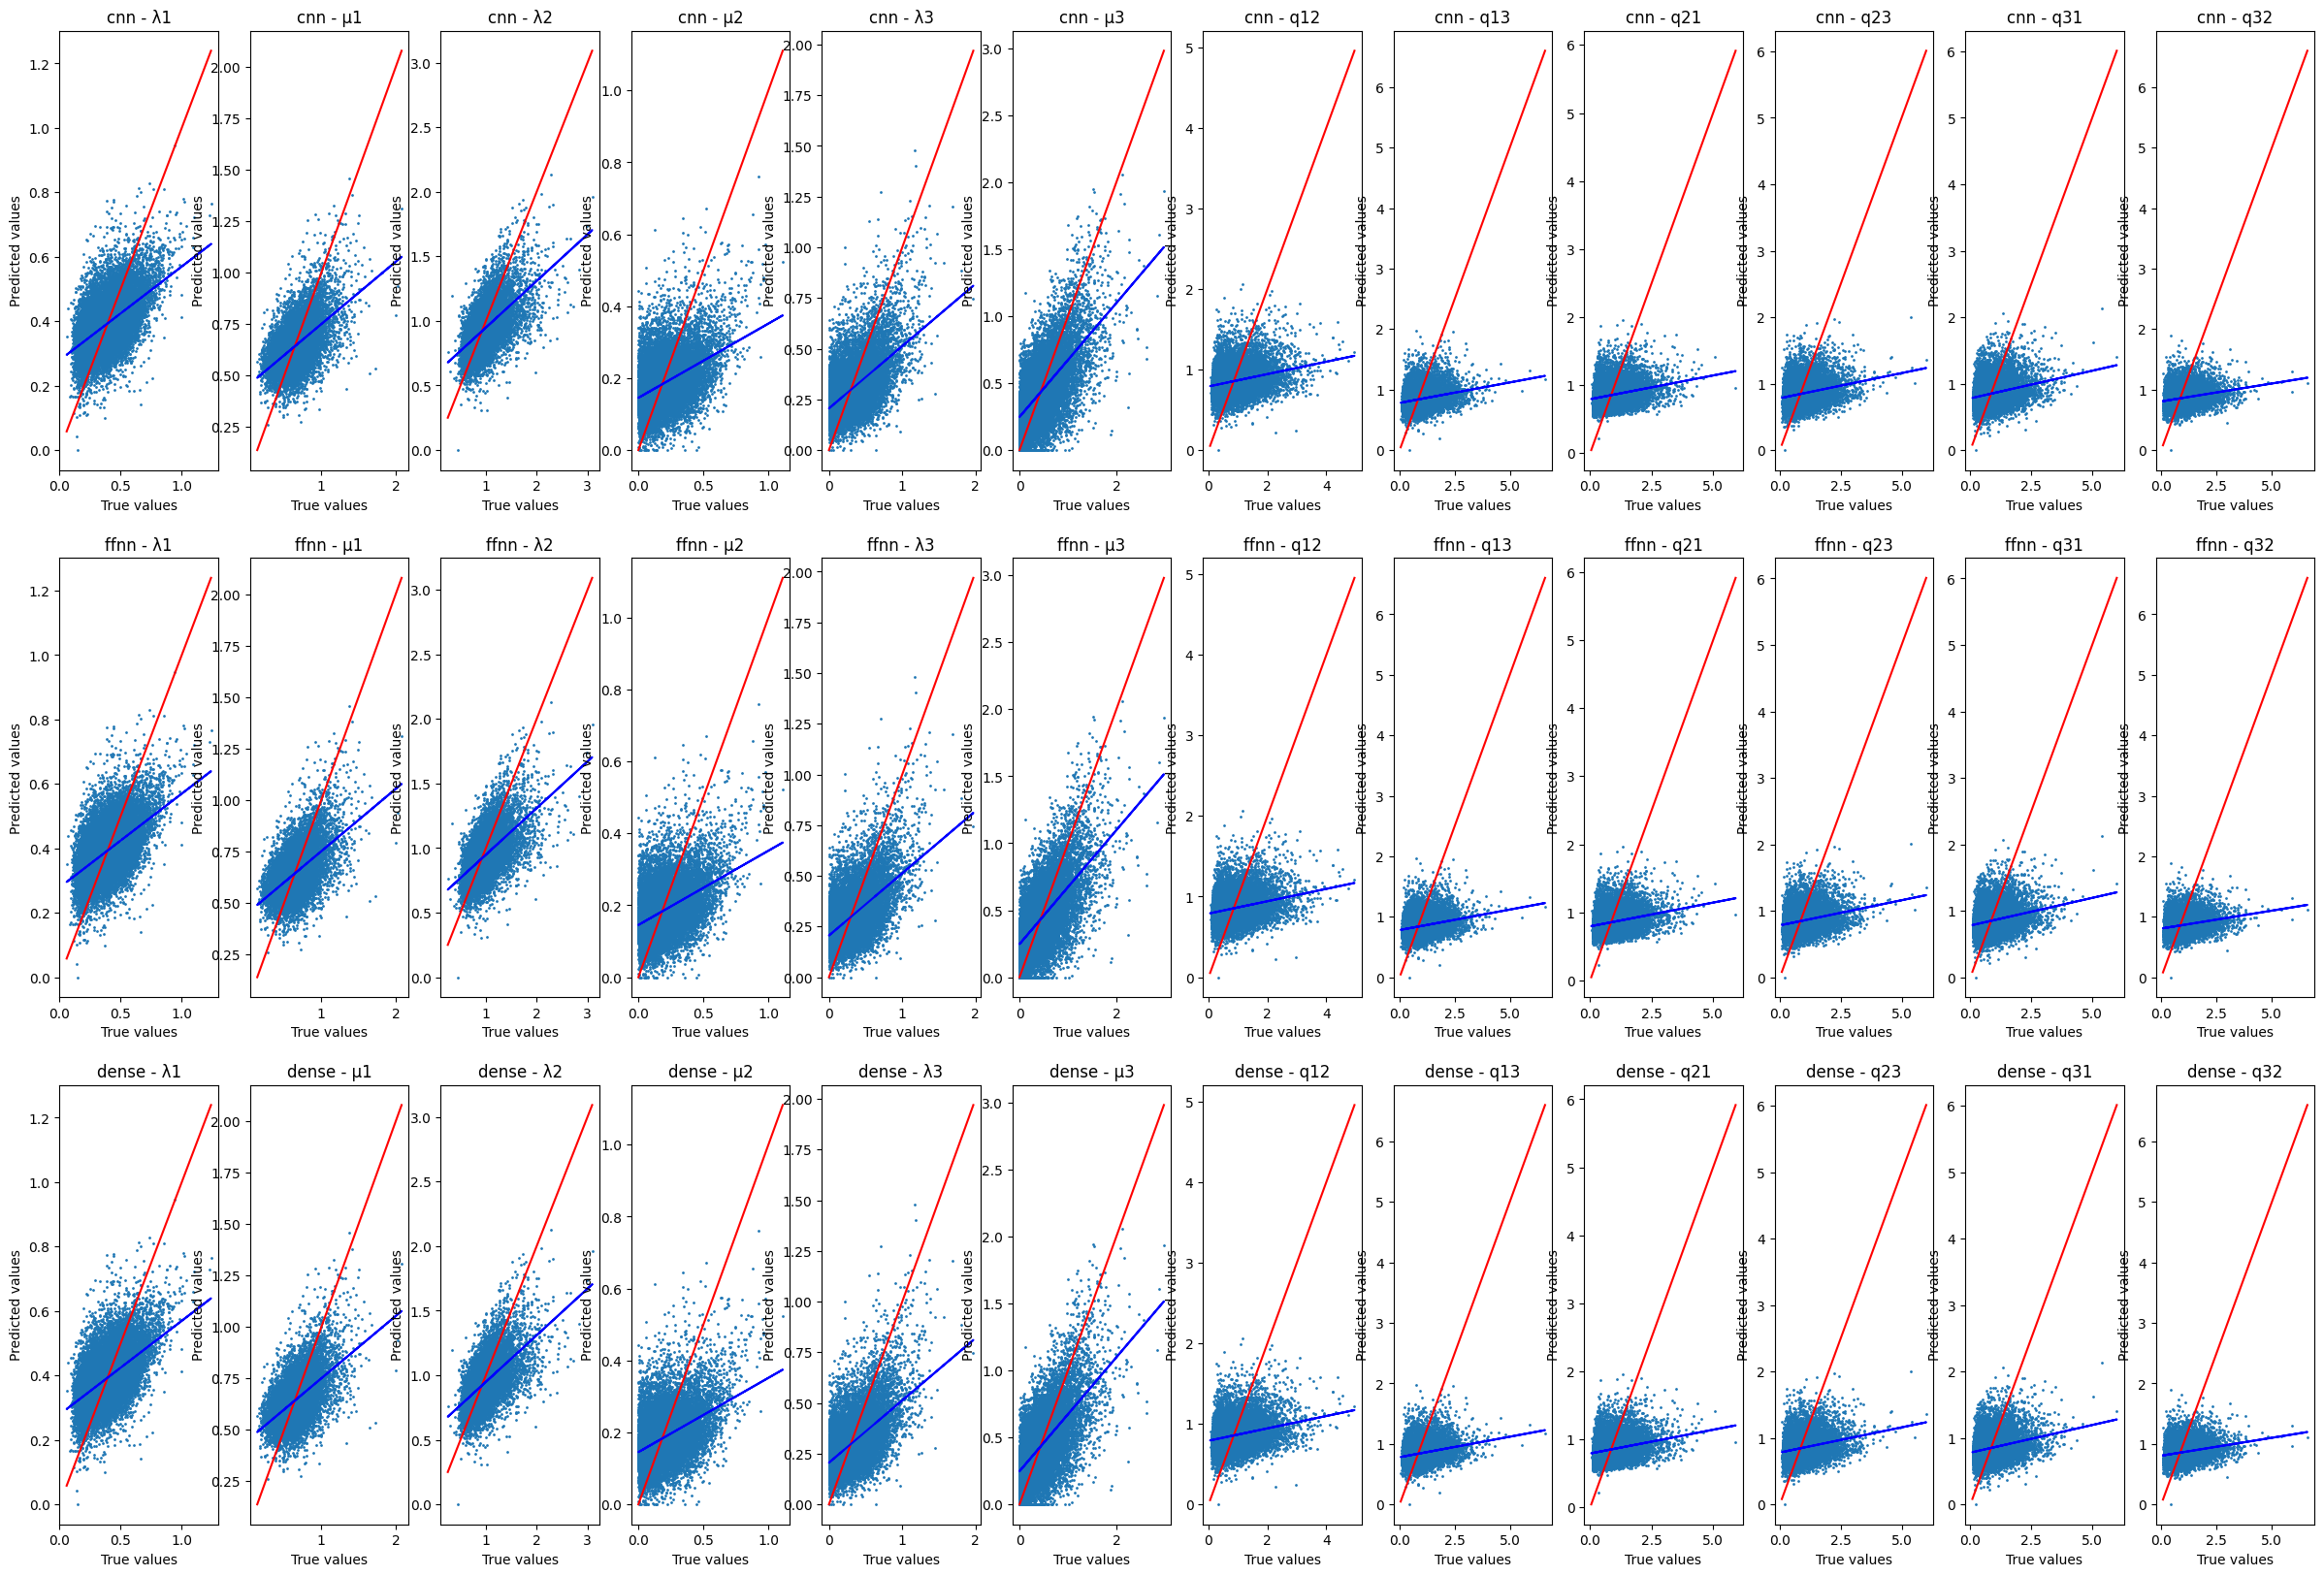

In [92]:
# plot true values vs predicted values for each model in the same figure 3x2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

model_names_list = ['cnn', 'ffnn', 'dense']

fig, ax = plt.subplots(len(model_names_list), Y_test.shape[1] , figsize=(30, 20))

for i, model_n in enumerate(model_names_list):
    if model_n == 'cnn':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'ffnn':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'lstm':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'gru':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'dense':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
        
    
    # read the predictions
    Y_pred = pd.read_csv(chemin + '/Y_pred_' + model_n + ss + special_name + '.csv', index_col=0)
    
    # rename mae columns into λ, μ
    if model_name == "musse":
        Y_pred.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
        Y_test.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
        targets.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
    elif model_name == "bisse":
        Y_pred.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
        Y_test.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
        targets.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
    elif model_name == "geosse":
        Y_pred.columns = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
        Y_test.columns = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
        targets.columns = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
    elif model_name == "classe":
        Y_pred.columns = ['λ111', 'λ112', 'λ122', 'λ211', 'λ212', 'λ222', 'μ1', 'μ2', 'q12', 'q21']
        Y_test.columns = ['λ111', 'λ112', 'λ122', 'λ211', 'λ212', 'λ222', 'μ1', 'μ2', 'q12', 'q21']
        targets.columns = ['λ111', 'λ112', 'λ122', 'λ211', 'λ212', 'λ222', 'μ1', 'μ2', 'q12', 'q21']
    elif model_name == "bisseness":
        Y_pred.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
        Y_test.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
        targets.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
    
    # plot true values vs predicted values for each target with different colors
    # only for lambda1, mu1, q12
    for j in range(Y_test.shape[1]):
        ax[i, j].scatter(Y_test.iloc[:, j], Y_pred.iloc[:, j], s=1, label=targets.columns[j])
        # true values
        ax[i, j].plot([min(Y_test.iloc[:, j]), max(Y_test.iloc[:, j])], [min(Y_test.iloc[:, j]), max(Y_test.iloc[:, j])], color='red', label='True values')
        # trend line for each target, with same color of scatter
        z = np.polyfit(Y_test.iloc[:, j], Y_pred.iloc[:, j], 1)
        ax[i, j].plot(Y_test.iloc[:, j], z[0]*Y_test.iloc[:, j] + z[1], label='Trend line for ' + targets.columns[j], color='blue')
        ax[i, j].set_xlabel('True values')
        ax[i, j].set_ylabel('Predicted values')
        title = model_n + ' - ' + Y_test.columns[j]
        ax[i, j].set_title(title)
        # remove duplicates from the legend
        handles, labels = ax[i, j].get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        #ax[i, j].legend(by_label.values(), by_label.keys())
        
plt.show()
    
    

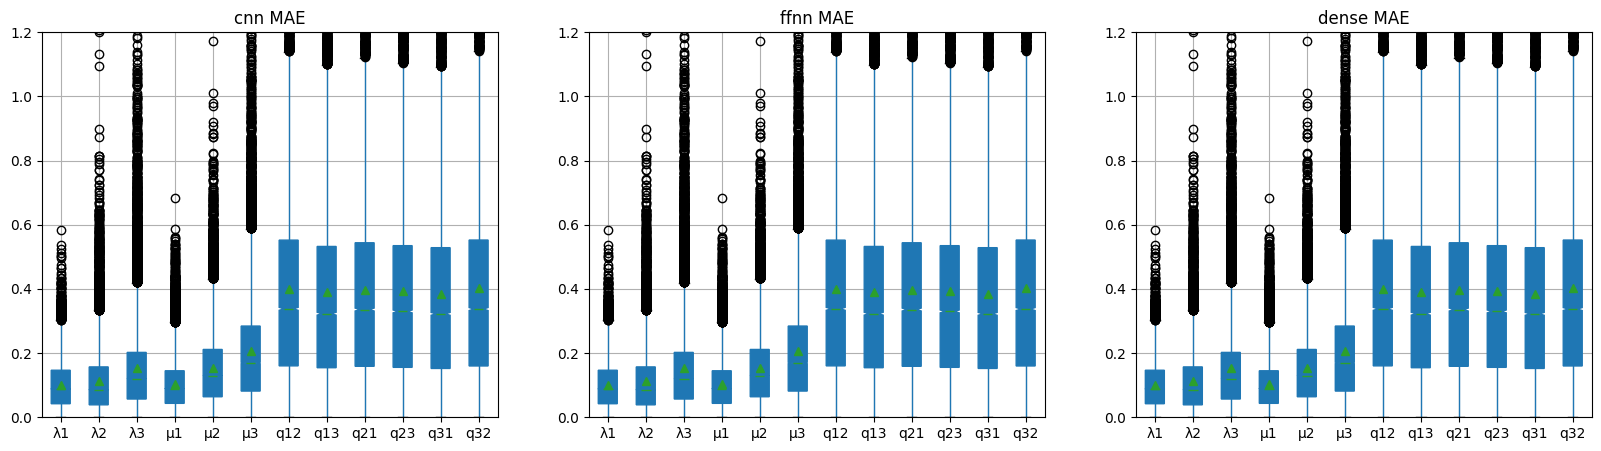

In [94]:
# boxplot of the MAE and total error for each target for each model
import matplotlib.pyplot as plt
import numpy as np


# boxplot mae for each feature, one plot for each model, all in the same figure
fig, ax = plt.subplots(1, len(model_names_list), figsize=(20, 5))

for i, model_n in enumerate(model_names_list):
    if model_n == 'cnn':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'ffnn':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'lstm':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'gru':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'dense':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    
    # read the predictions
    Y_pred = pd.read_csv(chemin + '/Y_pred_' + model_n + ss + special_name + '.csv', index_col=0)

    # rename the columns
    Y_pred.columns = targets.columns

    
    # MAE
    mae = np.abs(Y_pred - Y_test) # It outputs all NaNs: check the shapes of Y_pred and Y_test

    
    # rename mae columns into λ, μ
    if model_name == "musse":
        Y_pred.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
        Y_test.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
        targets.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
    elif model_name == "bisse":
        Y_pred.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
        Y_test.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
        targets.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
    elif model_name == "geosse":
        Y_pred.columns = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
        Y_test.columns = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
        targets.columns = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
    elif model_name == "classe":
        Y_pred.columns = ['λ111', 'λ112', 'λ122', 'λ211', 'λ212', 'λ222', 'μ1', 'μ2', 'q12', 'q21']
        Y_test.columns = ['λ111', 'λ112', 'λ122', 'λ211', 'λ212', 'λ222', 'μ1', 'μ2', 'q12', 'q21']
        targets.columns = ['λ111', 'λ112', 'λ122', 'λ211', 'λ212', 'λ222', 'μ1', 'μ2', 'q12', 'q21']
    elif model_name == "bisseness":
        Y_pred.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
        Y_test.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
        targets.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
 
    
    # MAE
    # Y_test indices start from 72502, so we need to reset the index
    Y_test = Y_test.reset_index(drop=True)
    mae = np.abs(Y_pred - Y_test)
    
    
    
    
    # rename mae columns into λ, μ
    if model_name == 'musse':
        if num_states == 3:
            mae.columns = ['λ1', 'λ2', 'λ3', 'μ1', 'μ2', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
        elif num_states == 4:
            mae.columns = ['λ1', 'λ2', 'λ3', 'λ4', 'μ1', 'μ2', 'μ3', 'μ4', 'q12', 'q13', 'q14', 'q21', 'q23', 'q24', 'q31', 'q32', 'q34', 'q41', 'q42', 'q43']
    elif model_name == 'bd':
        mae.columns = ['λ', 'μ']
    elif model_name == 'bisse':
        mae.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
        
    
    
    # boxplot of the mae for each target, setting ylim to 0, 1.2
    mae.boxplot(ax=ax[i], notch=True, patch_artist=True, showmeans=True)
    ax[i].set_ylim(0, 1.2)
    ax[i].set_title(model_n + ' MAE')
    
plt.show()

# boxplot of the total error for each model


(15643, 2)
(15643, 2)
(15643, 2)
(15643, 3)
(15643, 9)
(15643, 2)
(15643, 2)
(15643, 2)
(15643, 3)
(15643, 9)
(15643, 2)
(15643, 2)
(15643, 2)
(15643, 3)
(15643, 9)


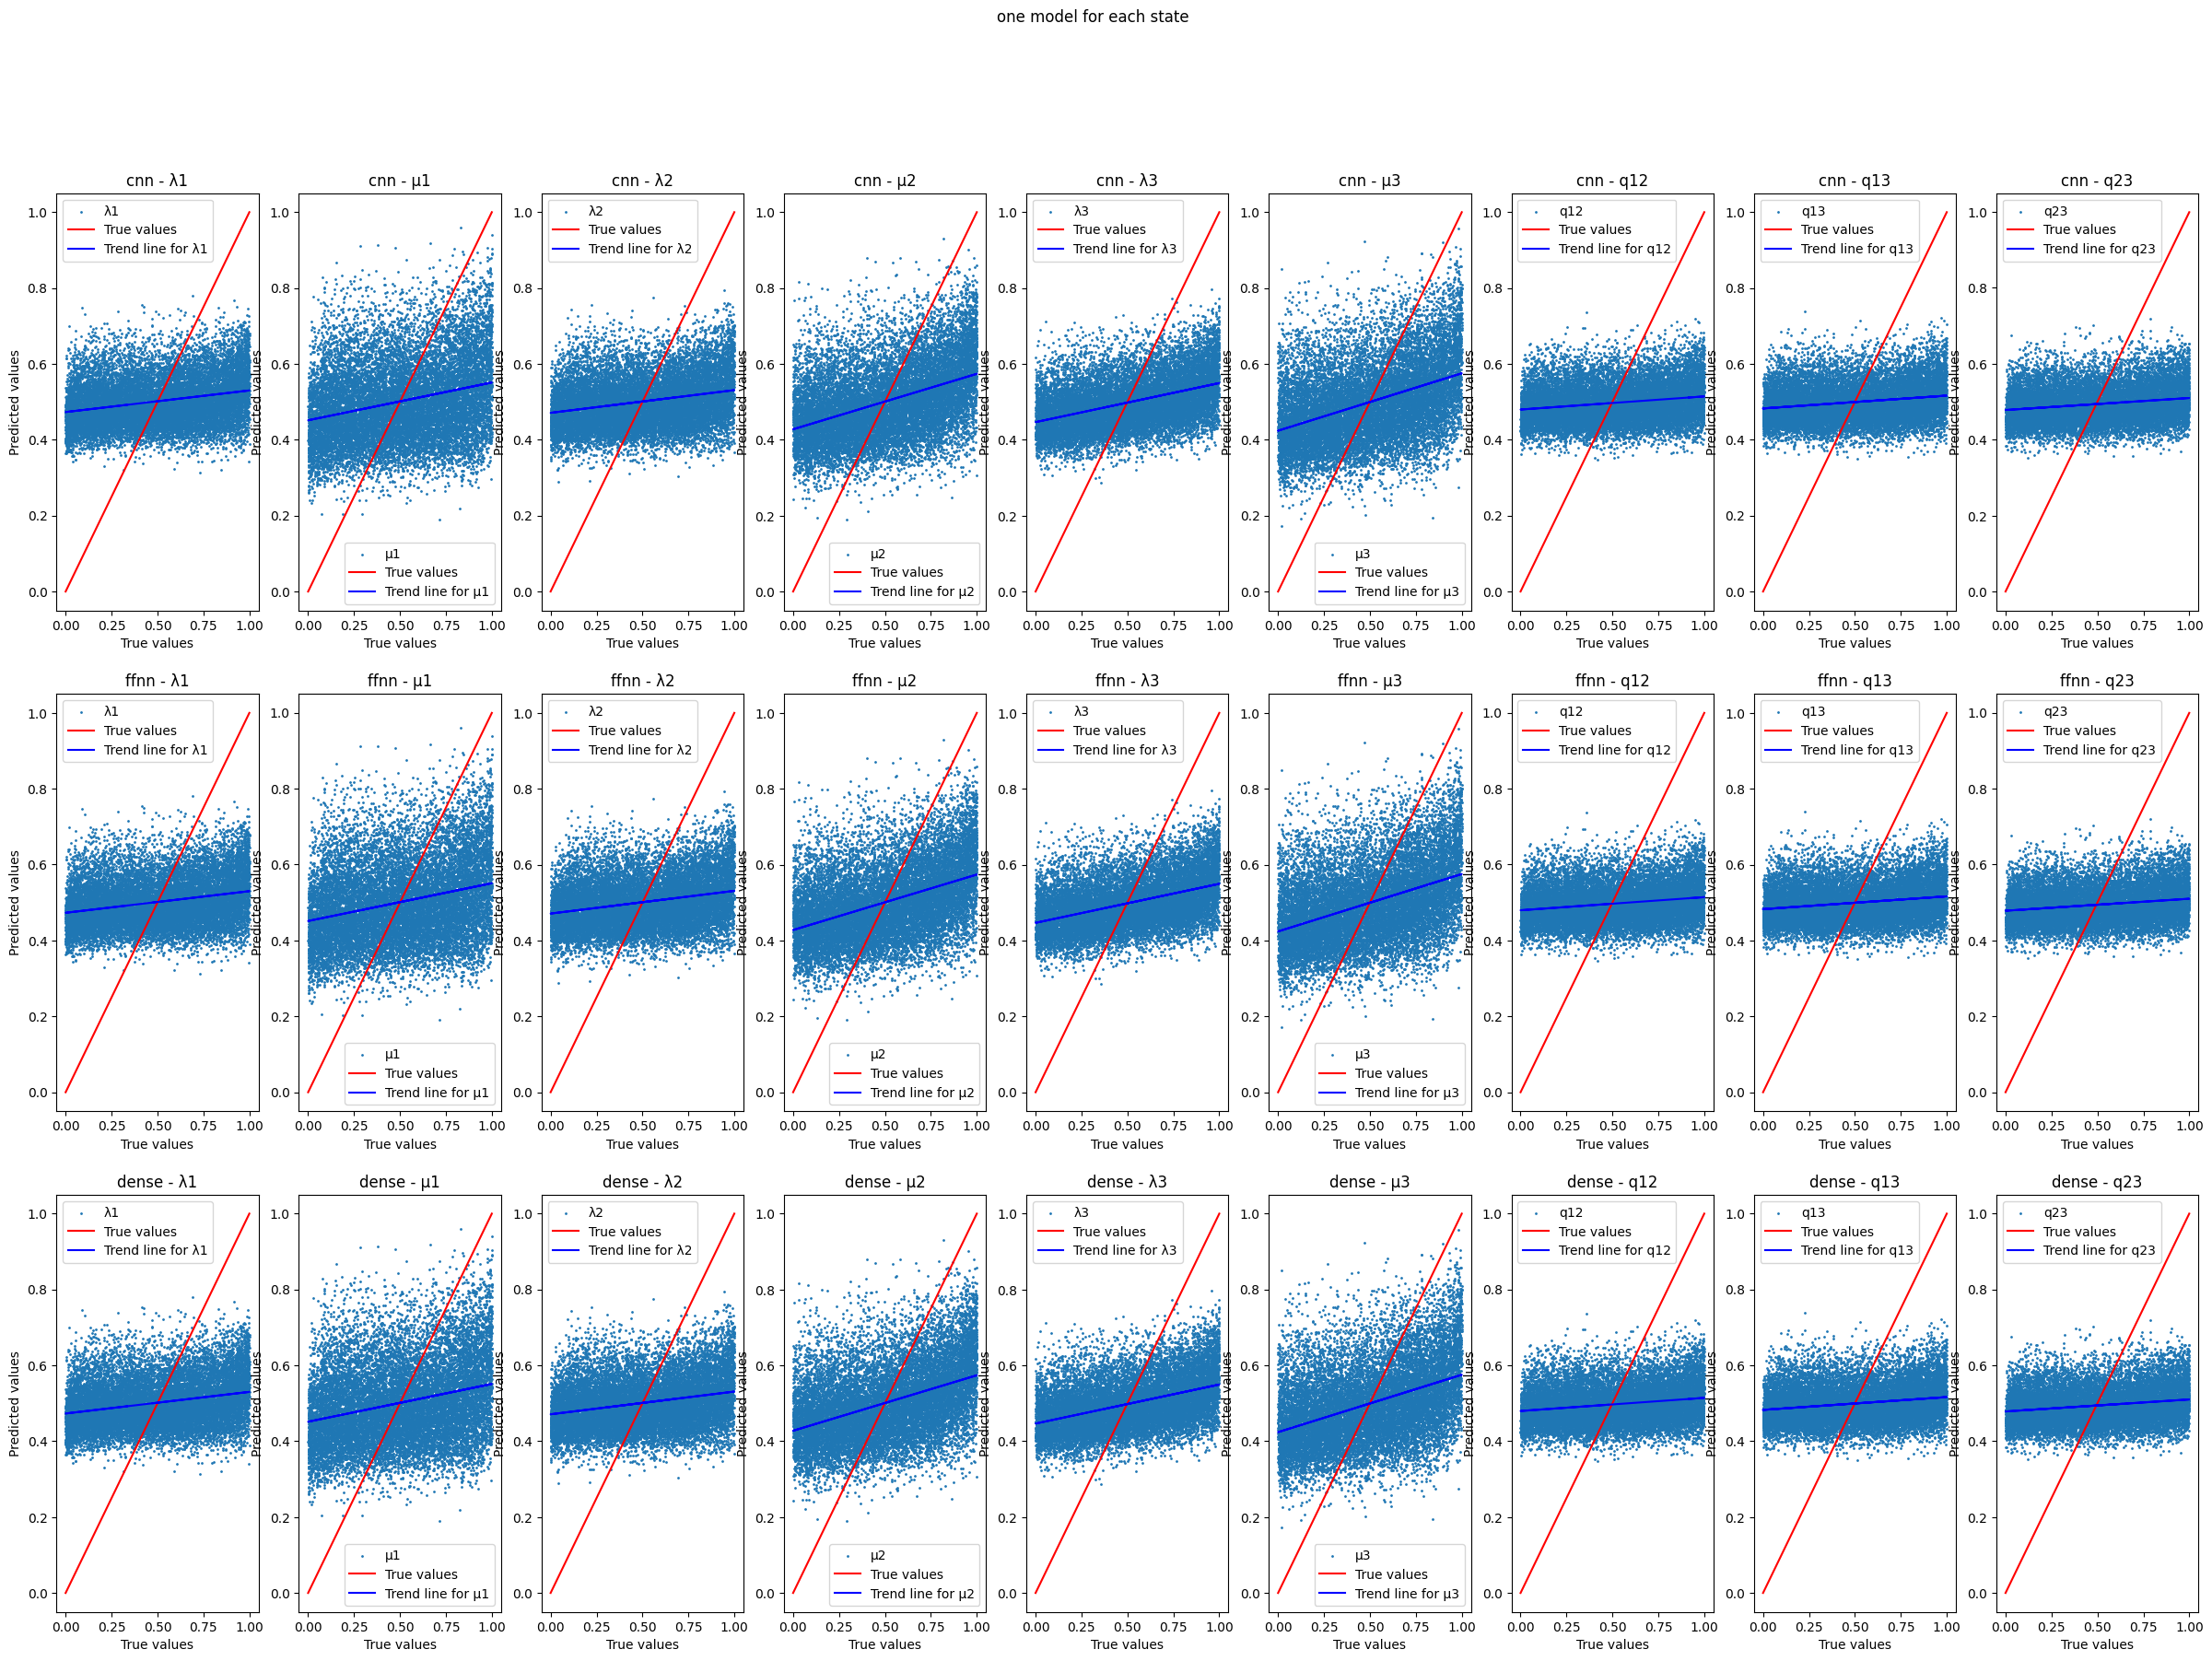

In [68]:
# with couples for musse
if model_name == "musse":
    fig, ax = plt.subplots(len(model_names_list), Y_test.shape[1] , figsize=(30, 20))

    for i, model_n in enumerate(model_names_list):
        if model_n == 'cnn':
            model1 = load_model(chemin + '/model_cnn' + ss + special_name + '_1.h5')
            model2 = load_model(chemin + '/model_cnn' + ss + special_name + '_2.h5')
            model3 = load_model(chemin + '/model_cnn' + ss + special_name + '_3.h5')
            model4 = load_model(chemin + '/model_cnn' + ss + special_name + '_4.h5')
        elif model_n == 'ffnn':
            model1 = load_model(chemin + '/model_ffnn' + ss + special_name + '_1.h5')
            model2 = load_model(chemin + '/model_ffnn' + ss + special_name + '_2.h5')
            model3 = load_model(chemin + '/model_ffnn' + ss + special_name + '_3.h5')
            model4 = load_model(chemin + '/model_ffnn' + ss + special_name + '_4.h5')
        elif model_n == 'lstm':
            model1 = load_model(chemin + '/model_lstm' + ss + special_name + '_1.h5')
            model2 = load_model(chemin + '/model_lstm' + ss + special_name + '_2.h5')
            model3 = load_model(chemin + '/model_lstm' + ss + special_name + '_3.h5')
            model4 = load_model(chemin + '/model_lstm' + ss + special_name + '_4.h5')
        elif model_n == 'gru':
            model1 = load_model(chemin + '/model_gru' + ss + special_name + '_1.h5')
            model2 = load_model(chemin + '/model_gru' + ss + special_name + '_2.h5')
            model3 = load_model(chemin + '/model_gru' + ss + special_name + '_3.h5')
            model4 = load_model(chemin + '/model_gru' + ss + special_name + '_4.h5')
        elif model_n == 'dense':
            model1 = load_model(chemin + '/model_dense' + ss + special_name + '_1.h5')
            model2 = load_model(chemin + '/model_dense' + ss + special_name + '_2.h5')
            model3 = load_model(chemin + '/model_dense' + ss + special_name + '_3.h5')
            model4 = load_model(chemin + '/model_dense' + ss + special_name + '_4.h5')

        # read the predictions
        Y1_pred = pd.read_csv(chemin + '/Y1_pred_' + model_n + ss + special_name + '.csv', index_col=0)
        Y2_pred = pd.read_csv(chemin + '/Y2_pred_' + model_n + ss + special_name + '.csv', index_col=0)
        Y3_pred = pd.read_csv(chemin + '/Y3_pred_' + model_n + ss + special_name + '.csv', index_col=0)
        Y4_pred = pd.read_csv(chemin + '/Y4_pred_' + model_n + ss + special_name + '.csv', index_col=0)
        print(Y1_pred.shape)
        print(Y2_pred.shape)
        print(Y3_pred.shape)
        print(Y4_pred.shape)
        
        print(Y_test.shape)
        
        # rename mae columns into λ, μ
        Y1_pred.columns = ['λ1', 'μ1']
        Y2_pred.columns = ['λ2', 'μ2']
        Y3_pred.columns = ['λ3', 'μ3']
        Y4_pred.columns = ['q12', 'q13', 'q23']
        Y_test.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q23']
        targets.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q23']
        
        # plot true values vs predicted values for each target with different colors
        # only for lambda1, mu1, q12
        
        ax[i, 0].scatter(Y_test.iloc[:, 0], Y1_pred.iloc[:, 0], s=1, label='λ1')
        ax[i, 0].plot([min(Y_test.iloc[:, 0]), max(Y_test.iloc[:, 0])], [min(Y_test.iloc[:, 0]), max(Y_test.iloc[:, 0])], color='red', label='True values')
        ax[i, 0].set_xlabel('True values')
        ax[i, 0].set_ylabel('Predicted values')
        title = model_n + ' - ' + 'λ1'
        ax[i, 0].set_title(title)
        # trend line for each target, blue
        z = np.polyfit(Y_test.iloc[:, 0], Y1_pred.iloc[:, 0], 1)
        ax[i, 0].plot(Y_test.iloc[:, 0], z[0]*Y_test.iloc[:, 0] + z[1], label='Trend line for λ1', color='blue')
        
        
        
        ax[i, 1].scatter(Y_test.iloc[:, 1], Y1_pred.iloc[:, 1], s=1, label='μ1')
        ax[i, 1].plot([min(Y_test.iloc[:, 1]), max(Y_test.iloc[:, 1])], [min(Y_test.iloc[:, 1]), max(Y_test.iloc[:, 1])], color='red', label='True values')
        ax[i, 1].set_xlabel('True values')
        ax[i, 1].set_ylabel('Predicted values')
        title = model_n + ' - ' + 'μ1'
        ax[i, 1].set_title(title)
        z = np.polyfit(Y_test.iloc[:, 1], Y1_pred.iloc[:, 1], 1)
        ax[i, 1].plot(Y_test.iloc[:, 1], z[0]*Y_test.iloc[:, 1] + z[1], label='Trend line for μ1', color='blue')
        
        ax[i, 2].scatter(Y_test.iloc[:, 2], Y2_pred.iloc[:, 0], s=1, label='λ2')
        ax[i, 2].plot([min(Y_test.iloc[:, 2]), max(Y_test.iloc[:, 2])], [min(Y_test.iloc[:, 2]), max(Y_test.iloc[:, 2])], color='red', label='True values')
        ax[i, 2].set_xlabel('True values')
        ax[i, 2].set_ylabel('Predicted values')
        title = model_n + ' - ' + 'λ2'
        ax[i, 2].set_title(title)
        z = np.polyfit(Y_test.iloc[:, 2], Y2_pred.iloc[:, 0], 1)
        ax[i, 2].plot(Y_test.iloc[:, 2], z[0]*Y_test.iloc[:, 2] + z[1], label='Trend line for λ2', color='blue')
        
        ax[i, 3].scatter(Y_test.iloc[:, 3], Y2_pred.iloc[:, 1], s=1, label='μ2')
        ax[i, 3].plot([min(Y_test.iloc[:, 3]), max(Y_test.iloc[:, 3])], [min(Y_test.iloc[:, 3]), max(Y_test.iloc[:, 3])], color='red', label='True values')
        ax[i, 3].set_xlabel('True values')
        ax[i, 3].set_ylabel('Predicted values')
        title = model_n + ' - ' + 'μ2'
        ax[i, 3].set_title(title)
        z = np.polyfit(Y_test.iloc[:, 3], Y2_pred.iloc[:, 1], 1)
        ax[i, 3].plot(Y_test.iloc[:, 3], z[0]*Y_test.iloc[:, 3] + z[1], label='Trend line for μ2', color='blue')
        
        ax[i, 4].scatter(Y_test.iloc[:, 4], Y3_pred.iloc[:, 0], s=1, label='λ3')
        ax[i, 4].plot([min(Y_test.iloc[:, 4]), max(Y_test.iloc[:, 4])], [min(Y_test.iloc[:, 4]), max(Y_test.iloc[:, 4])], color='red', label='True values')
        ax[i, 4].set_xlabel('True values')
        ax[i, 4].set_ylabel('Predicted values')
        title = model_n + ' - ' + 'λ3'
        ax[i, 4].set_title(title)
        z = np.polyfit(Y_test.iloc[:, 4], Y3_pred.iloc[:, 0], 1)
        ax[i, 4].plot(Y_test.iloc[:, 4], z[0]*Y_test.iloc[:, 4] + z[1], label='Trend line for λ3', color='blue')
        
        ax[i, 5].scatter(Y_test.iloc[:, 5], Y3_pred.iloc[:, 1], s=1, label='μ3')
        ax[i, 5].plot([min(Y_test.iloc[:, 5]), max(Y_test.iloc[:, 5])], [min(Y_test.iloc[:, 5]), max(Y_test.iloc[:, 5])], color='red', label='True values')
        ax[i, 5].set_xlabel('True values')
        ax[i, 5].set_ylabel('Predicted values')
        title = model_n + ' - ' + 'μ3'
        ax[i, 5].set_title(title)
        z = np.polyfit(Y_test.iloc[:, 5], Y3_pred.iloc[:, 1], 1)
        ax[i, 5].plot(Y_test.iloc[:, 5], z[0]*Y_test.iloc[:, 5] + z[1], label='Trend line for μ3', color='blue')
        
        ax[i, 6].scatter(Y_test.iloc[:, 6], Y4_pred.iloc[:, 0], s=1, label='q12')
        ax[i, 6].plot([min(Y_test.iloc[:, 6]), max(Y_test.iloc[:, 6])], [min(Y_test.iloc[:, 6]), max(Y_test.iloc[:, 6])], color='red', label='True values')
        ax[i, 6].set_xlabel('True values')
        ax[i, 6].set_ylabel('Predicted values')
        title = model_n + ' - ' + 'q12'
        ax[i, 6].set_title(title)
        z = np.polyfit(Y_test.iloc[:, 6], Y4_pred.iloc[:, 0], 1)
        ax[i, 6].plot(Y_test.iloc[:, 6], z[0]*Y_test.iloc[:, 6] + z[1], label='Trend line for q12', color='blue')
        
        ax[i, 7].scatter(Y_test.iloc[:, 7], Y4_pred.iloc[:, 1], s=1, label='q13')
        ax[i, 7].plot([min(Y_test.iloc[:, 7]), max(Y_test.iloc[:, 7])], [min(Y_test.iloc[:, 7]), max(Y_test.iloc[:, 7])], color='red', label='True values')
        ax[i, 7].set_xlabel('True values')
        ax[i, 7].set_ylabel('Predicted values')
        title = model_n + ' - ' + 'q13'
        ax[i, 7].set_title(title)
        z = np.polyfit(Y_test.iloc[:, 7], Y4_pred.iloc[:, 1], 1)
        ax[i, 7].plot(Y_test.iloc[:, 7], z[0]*Y_test.iloc[:, 7] + z[1], label='Trend line for q13', color='blue')
        
        ax[i, 8].scatter(Y_test.iloc[:, 8], Y4_pred.iloc[:, 2], s=1, label='q23')
        ax[i, 8].plot([min(Y_test.iloc[:, 8]), max(Y_test.iloc[:, 8])], [min(Y_test.iloc[:, 8]), max(Y_test.iloc[:, 8])], color='red', label='True values')
        ax[i, 8].set_xlabel('True values')
        ax[i, 8].set_ylabel('Predicted values')
        title = model_n + ' - ' + 'q23'
        ax[i, 8].set_title(title)
        z = np.polyfit(Y_test.iloc[:, 8], Y4_pred.iloc[:, 2], 1)
        ax[i, 8].plot(Y_test.iloc[:, 8], z[0]*Y_test.iloc[:, 8] + z[1], label='Trend line for q23', color='blue')
        
        ax[i, 0].legend()
        ax[i, 1].legend()
        ax[i, 2].legend()
        ax[i, 3].legend()
        ax[i, 4].legend()
        ax[i, 5].legend()
        ax[i, 6].legend()
        ax[i, 7].legend()
        ax[i, 8].legend()
        
    title = "one model for each state"
    fig.suptitle(title)  
    plt.show()

(15643, 2)
(15643, 2)
(15643, 2)
(15643, 3)
(17938, 12)


ValueError: Length mismatch: Expected axis has 12 elements, new values have 9 elements

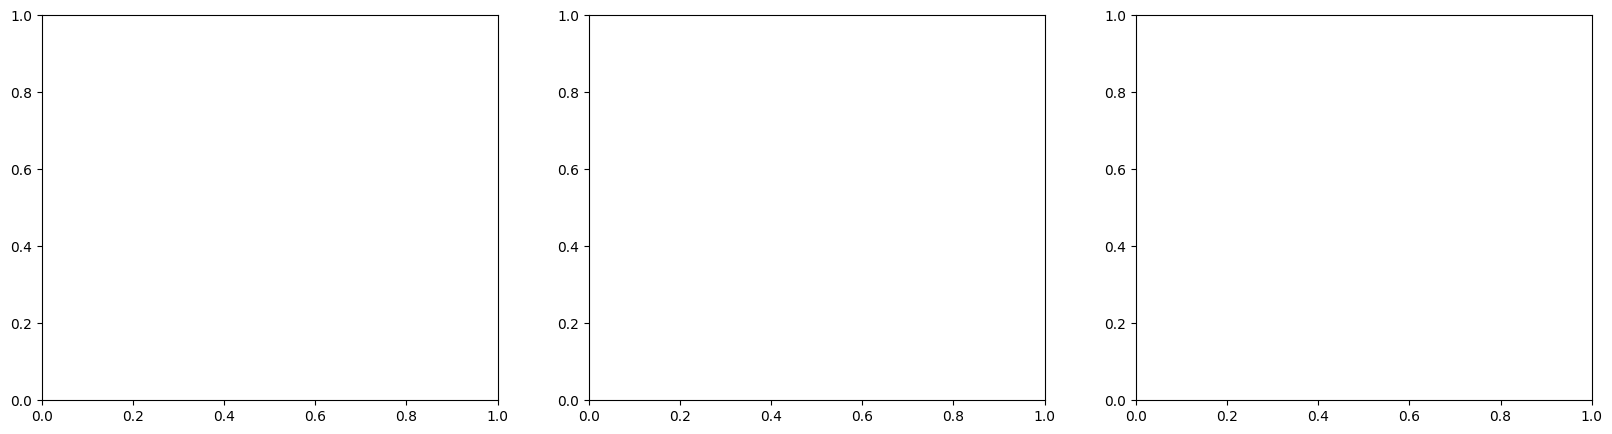

In [43]:
# individuals (couples) boxplots

if model_name == "musse":
    fig, ax = plt.subplots(1, len(model_names_list), figsize=(20, 5))

    for i, model_n in enumerate(model_names_list):
        if model_n == 'cnn':
            model1 = load_model(chemin + '/model_cnn' + ss + '_1.h5')
            model2 = load_model(chemin + '/model_cnn' + ss + '_2.h5')
            model3 = load_model(chemin + '/model_cnn' + ss + '_3.h5')
            model4 = load_model(chemin + '/model_cnn' + ss + '_4.h5')
        elif model_n == 'ffnn':
            model1 = load_model(chemin + '/model_ffnn' + ss + '_1.h5')
            model2 = load_model(chemin + '/model_ffnn' + ss + '_2.h5')
            model3 = load_model(chemin + '/model_ffnn' + ss + '_3.h5')
            model4 = load_model(chemin + '/model_ffnn' + ss + '_4.h5')
        elif model_n == 'lstm':
            model1 = load_model(chemin + '/model_lstm' + ss + '_1.h5')
            model2 = load_model(chemin + '/model_lstm' + ss + '_2.h5')
            model3 = load_model(chemin + '/model_lstm' + ss + '_3.h5')
            model4 = load_model(chemin + '/model_lstm' + ss + '_4.h5')
        elif model_n == 'gru':
            model1 = load_model(chemin + '/model_gru' + ss + '_1.h5')
            model2 = load_model(chemin + '/model_gru' + ss + '_2.h5')
            model3 = load_model(chemin + '/model_gru' + ss + '_3.h5')
            model4 = load_model(chemin + '/model_gru' + ss + '_4.h5')
        elif model_n == 'dense':
            model1 = load_model(chemin + '/model_dense' + ss + '_1.h5')
            model2 = load_model(chemin + '/model_dense' + ss + '_2.h5')
            model3 = load_model(chemin + '/model_dense' + ss + '_3.h5')
            model4 = load_model(chemin + '/model_dense' + ss + '_4.h5')
            
        # read the predictions
        Y1_pred = pd.read_csv(chemin + '/Y1_pred_' + model_n + ss + '.csv', index_col=0)
        Y2_pred = pd.read_csv(chemin + '/Y2_pred_' + model_n + ss + '.csv', index_col=0)
        Y3_pred = pd.read_csv(chemin + '/Y3_pred_' + model_n + ss + '.csv', index_col=0)
        Y4_pred = pd.read_csv(chemin + '/Y4_pred_' + model_n + ss + '.csv', index_col=0)
        print(Y1_pred.shape)
        print(Y2_pred.shape)
        print(Y3_pred.shape)
        print(Y4_pred.shape)
        
        print(Y_test.shape)
        
        # rename mae columns into λ, μ
        Y1_pred.columns = ['λ1', 'μ1']
        Y2_pred.columns = ['λ2', 'μ2']
        Y3_pred.columns = ['λ3', 'μ3']
        Y4_pred.columns = ['q12', 'q13', 'q23']
        Y_test.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
        targets.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
        
        # boxplot for each target for each model of the 4 models
        # i is the index of the model
        # j is the index of the target
        
        mae1 = np.abs(Y1_pred - Y_test[['λ1', 'μ1']])
        mae2 = np.abs(Y2_pred - Y_test[['λ2', 'μ2']])
        mae3 = np.abs(Y3_pred - Y_test[['λ3', 'μ3']])
        mae4 = np.abs(Y4_pred - Y_test[['q12', 'q13', 'q23']])
        
        mae = pd.concat([mae1, mae2, mae3, mae4], axis=1)
        
        mae.boxplot(ax=ax[i], notch=True, patch_artist=True, showmeans=True)
        ax[i].set_ylim(0, 1.2)
        ax[i].set_title(model_n + ' MAE')
        
        title = model_n
        
            
    title = "one model for each state"
    fig.suptitle(title)
        

         λ1        μ1        λ2        μ2        λ3        μ3       q12  \
0  0.428369  0.597574  0.764586  0.187583  0.226487  0.284513  0.764351   
1  0.405109  0.574747  0.704324  0.144481  0.250216  0.323397  0.743645   
2  0.563248  0.997883  1.359165  0.339388  0.740672  1.196966  1.398988   
3  0.435023  0.625712  0.839682  0.199404  0.257639  0.336189  0.810489   
4  0.257308  0.516157  0.872150  0.080405  0.187902  0.247303  0.776371   

        q13       q21       q23       q31       q32  
0  0.779211  0.756590  0.762332  0.780749  0.768504  
1  0.686339  0.727853  0.740112  0.671804  0.749140  
2  1.181997  1.377146  1.197404  1.342776  1.205761  
3  0.843081  0.784326  0.821040  0.790229  0.840555  
4  0.691767  0.737099  0.744951  0.701590  0.754350  
             λ1        μ1        λ2        μ2        λ3        μ3       q12  \
72502  0.486449  0.487145  0.608351  0.152823  0.190819  0.038861  0.730696   
72503  0.137901  0.630291  0.761544  0.015325  0.124358  0.493225  

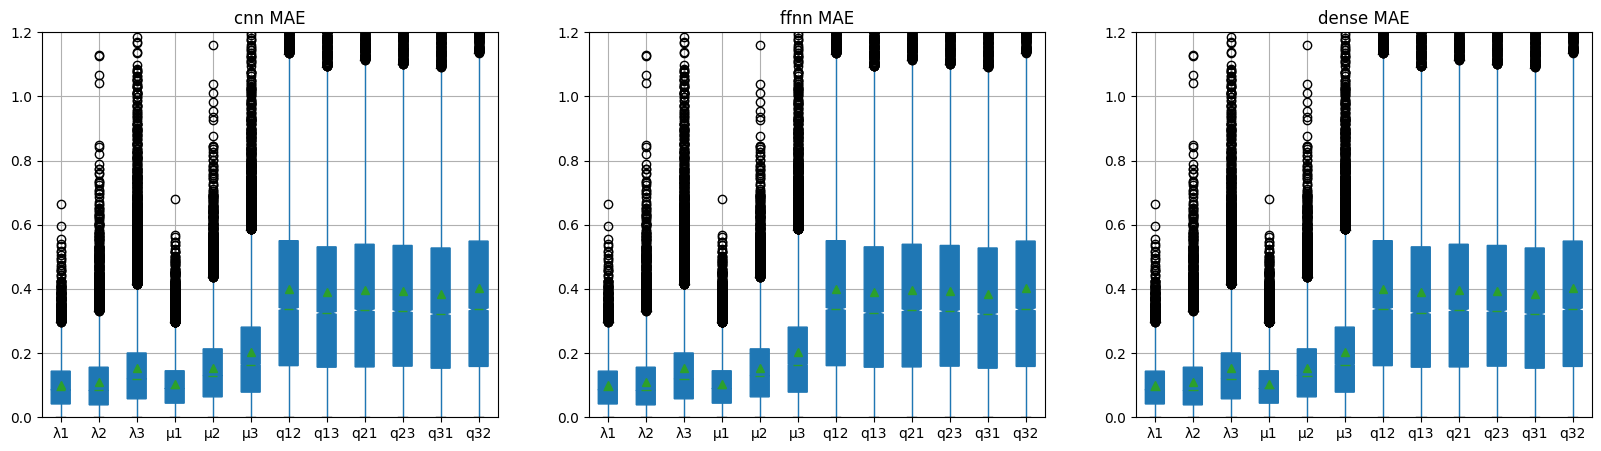

In [59]:
# boxplot of the MAE and total error for each target for each model
import matplotlib.pyplot as plt
import numpy as np


# boxplot mae for each feature, one plot for each model, all in the same figure
fig, ax = plt.subplots(1, len(model_names_list), figsize=(20, 5))

for i, model_n in enumerate(model_names_list):
    if model_n == 'cnn':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'ffnn':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'lstm':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'gru':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    elif model_n == 'dense':
        model = load_model(chemin + '/model_' + model_n + ss + special_name + '.h5')
    
    # read the predictions
    Y_pred = pd.read_csv(chemin + '/Y_pred_' + model_n + ss + special_name + '.csv', index_col=0)

    # rename the columns
    Y_pred.columns = targets.columns
    print(Y_pred.head())
    
    print(Y_test.head())
    
    # MAE
    mae = np.abs(Y_pred - Y_test) # It outputs all NaNs: check the shapes of Y_pred and Y_test
    print(Y_pred.shape)
    print(Y_test.shape)
    print(mae)
    
    # rename mae columns into λ, μ
    if model_name == "musse":
        Y_pred.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
        Y_test.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
        targets.columns = ['λ1', 'μ1', 'λ2', 'μ2', 'λ3', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
    elif model_name == "bisse":
        Y_pred.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
        Y_test.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
        targets.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
    elif model_name == "geosse":
        Y_pred.columns = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
        Y_test.columns = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
        targets.columns = ['sA', 'sB', 'sAB', 'xA', 'xB', 'dA', 'dB']
    elif model_name == "classe":
        Y_pred.columns = ['λ111', 'λ112', 'λ122', 'λ211', 'λ212', 'λ222', 'μ1', 'μ2', 'q12', 'q21']
        Y_test.columns = ['λ111', 'λ112', 'λ122', 'λ211', 'λ212', 'λ222', 'μ1', 'μ2', 'q12', 'q21']
        targets.columns = ['λ111', 'λ112', 'λ122', 'λ211', 'λ212', 'λ222', 'μ1', 'μ2', 'q12', 'q21']
    elif model_name == "bisseness":
        Y_pred.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
        Y_test.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
        targets.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21', 'p1c', 'p1a', 'p2c', 'p2a']
 
    
    # MAE
    # Y_test indices start from 72502, so we need to reset the index
    Y_test = Y_test.reset_index(drop=True)
    mae = np.abs(Y_pred - Y_test)
    
    
    
    
    # rename mae columns into λ, μ
    if model_name == 'musse':
        if num_states == 3:
            mae.columns = ['λ1', 'λ2', 'λ3', 'μ1', 'μ2', 'μ3', 'q12', 'q13', 'q21', 'q23', 'q31', 'q32']
        elif num_states == 4:
            mae.columns = ['λ1', 'λ2', 'λ3', 'λ4', 'μ1', 'μ2', 'μ3', 'μ4', 'q12', 'q13', 'q14', 'q21', 'q23', 'q24', 'q31', 'q32', 'q34', 'q41', 'q42', 'q43']
    elif model_name == 'bd':
        mae.columns = ['λ', 'μ']
    elif model_name == 'bisse':
        mae.columns = ['λ1', 'λ2', 'μ1', 'μ2', 'q12', 'q21']
        
    print(mae)
        
    
    
    # boxplot of the mae for each target, setting ylim to 0, 1.2
    mae.boxplot(ax=ax[i], notch=True, patch_artist=True, showmeans=True)
    ax[i].set_ylim(0, 1.2)
    ax[i].set_title(model_n + ' MAE')
    
plt.show()

# boxplot of the total error for each model


KeyError: 'lambda1_rescaled'

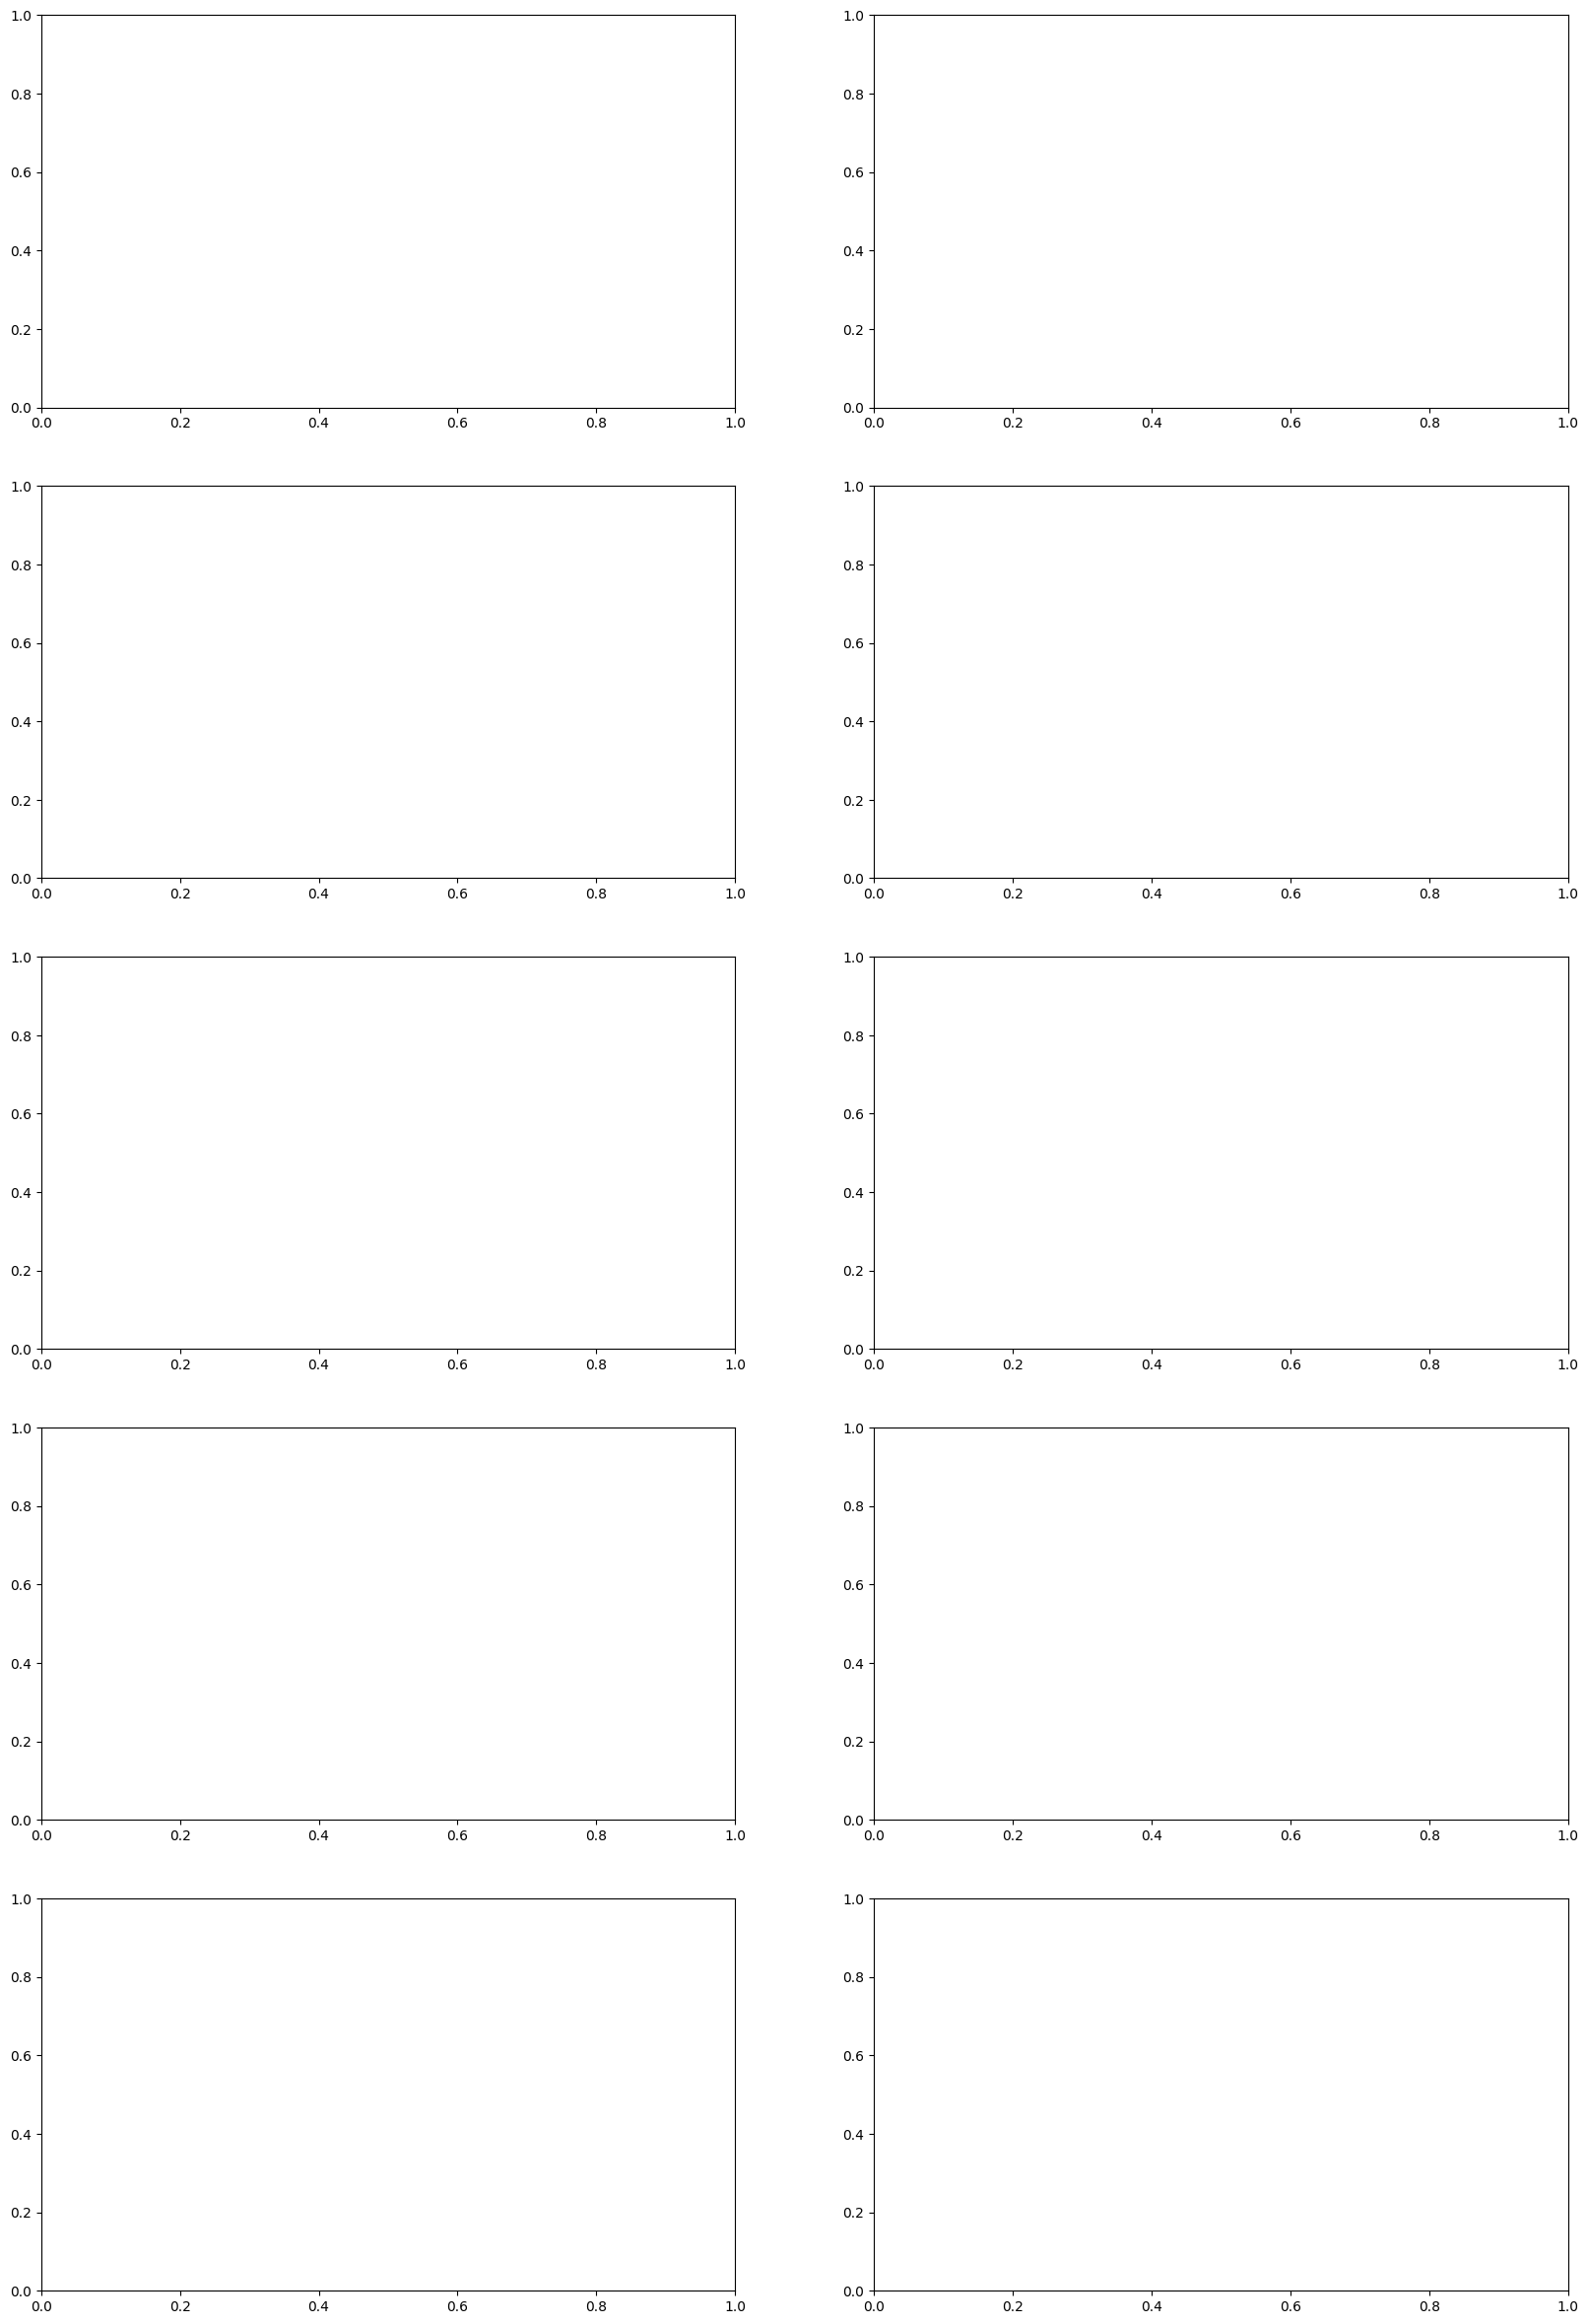

In [ ]:
# plot true values vs predicted values for each model in the same figure 3x2
import matplotlib.pyplot as plt
import numpy as np

model_names_list = ['cnn', 'ffnn', 'lstm', 'gru', 'dense']

fig, ax = plt.subplots(5, 2, figsize=(20, 30))

for i, model_n in enumerate(model_names_list):
    if model_n == 'cnn':
        model = load_model(chemin + '/model_cnn.h5')
    elif model_n == 'ffnn':
        model = load_model(chemin + '/model_ffnn.h5')
    elif model_n == 'lstm':
        model = load_model(chemin + '/model_lstm.h5')
    elif model_n == 'gru':
        model = load_model(chemin + '/model_gru.h5')
    elif model_n == 'dense':
        model = load_model(chemin + '/model_dense.h5')
    
    # read the predictions
    Y_pred = pd.read_csv(chemin + '/Y_pred_' + model_n + '.csv', index_col=0)
    
    target_list = ['lambda1_rescaled', 'mu1_rescaled', 'q12_rescaled']
    
    Y_pred.columns = Y_test.columns
    
    # plot true values vs predicted values for each target with different colors
    # only for lambda1, mu1, q12
    for j in range(len(target_list)):
        ax[i, 0].scatter(Y_test[target_list[j]], Y_pred[target_list[j]], s=1, label=target_list[j])
        # true values
        ax[i, 0].plot([min(Y_test[target_list[j]]), max(Y_test[target_list[j]])], [min(Y_test[target_list[j]]), max(Y_test[target_list[j]])], color='red')
        # trend line for each target, with same color of scatter
        z = np.polyfit(Y_test[target_list[j]], Y_pred[target_list[j]], 1)
        ax[i, 0].plot(Y_test[target_list[j]], z[0]*Y_test[target_list[j]] + z[1])
        ax[i, 0].set_xlabel('True values')
        ax[i, 0].set_ylabel('Predicted values')
        ax[i, 0].set_title(model_n)
        ax[i, 0].legend()
    
    
    
    # then with couples
    # read the predictions
    Y_pred = pd.read_csv(chemin + '/Y_pred_' + model_n + '_couples.csv', index_col=0)
    
    # transform the column names of Y_pred to the same as Y_test
    Y_pred.columns = Y_test.columns
    
    
    # plot true values vs predicted values for each target with different colors
    for j in range(len(target_list)):
        ax[i, 1].scatter(Y_test[target_list[j]], Y_pred[target_list[j]], s=1, label=target_list[j])
        # true values
        ax[i, 1].plot([min(Y_test[target_list[j]]), max(Y_test[target_list[j]])], [min(Y_test[target_list[j]]), max(Y_test[target_list[j]])], color='red')
        # trend line for each target, with same color of scatter
        z = np.polyfit(Y_test[target_list[j]], Y_pred[target_list[j]], 1)
        ax[i, 1].plot(Y_test[target_list[j]], z[0]*Y_test[target_list[j]] + z[1])
        ax[i, 1].set_xlabel('True values')
        ax[i, 1].set_ylabel('Predicted values')
        ax[i, 1].set_title(model_n + ' with couples')
        ax[i, 1].legend()
        
plt.show()
    
    

561/561 [==============================] - 1s 1ms/step


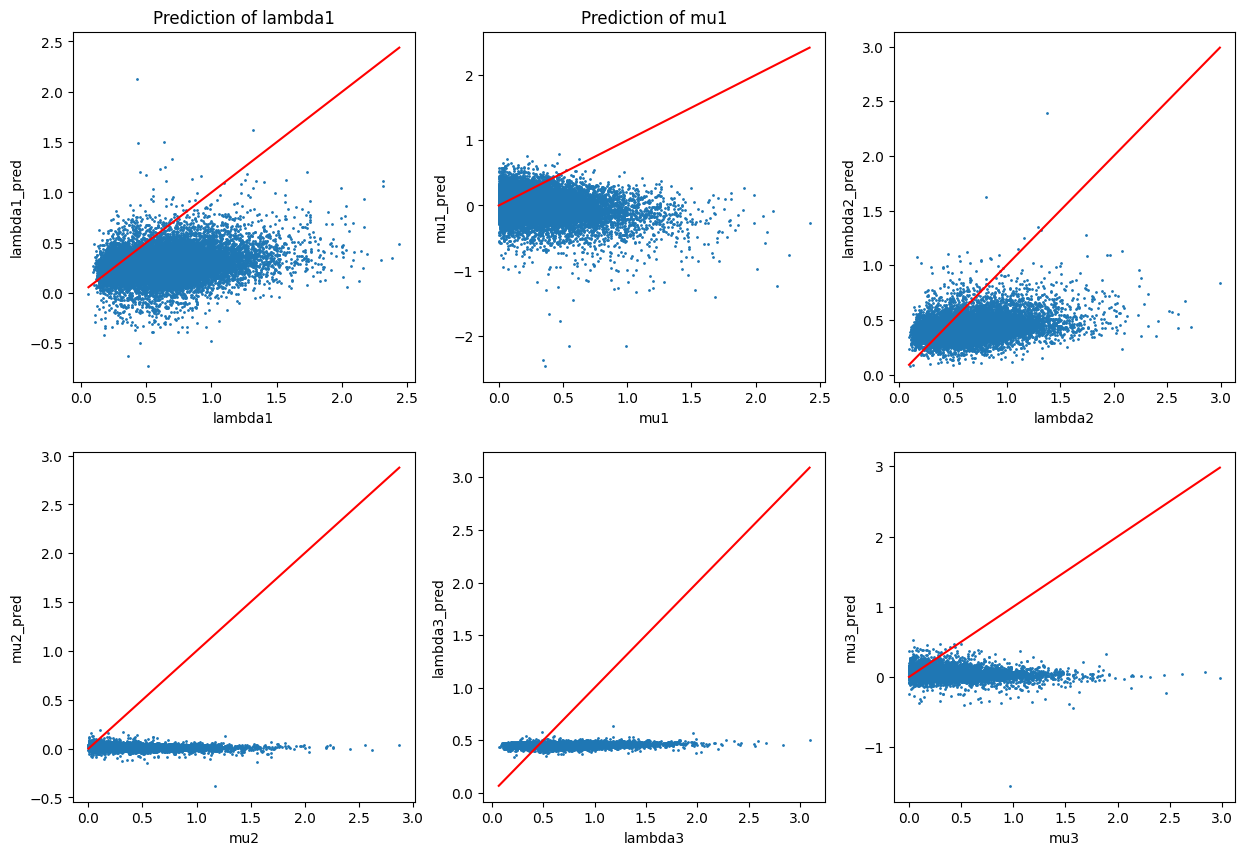

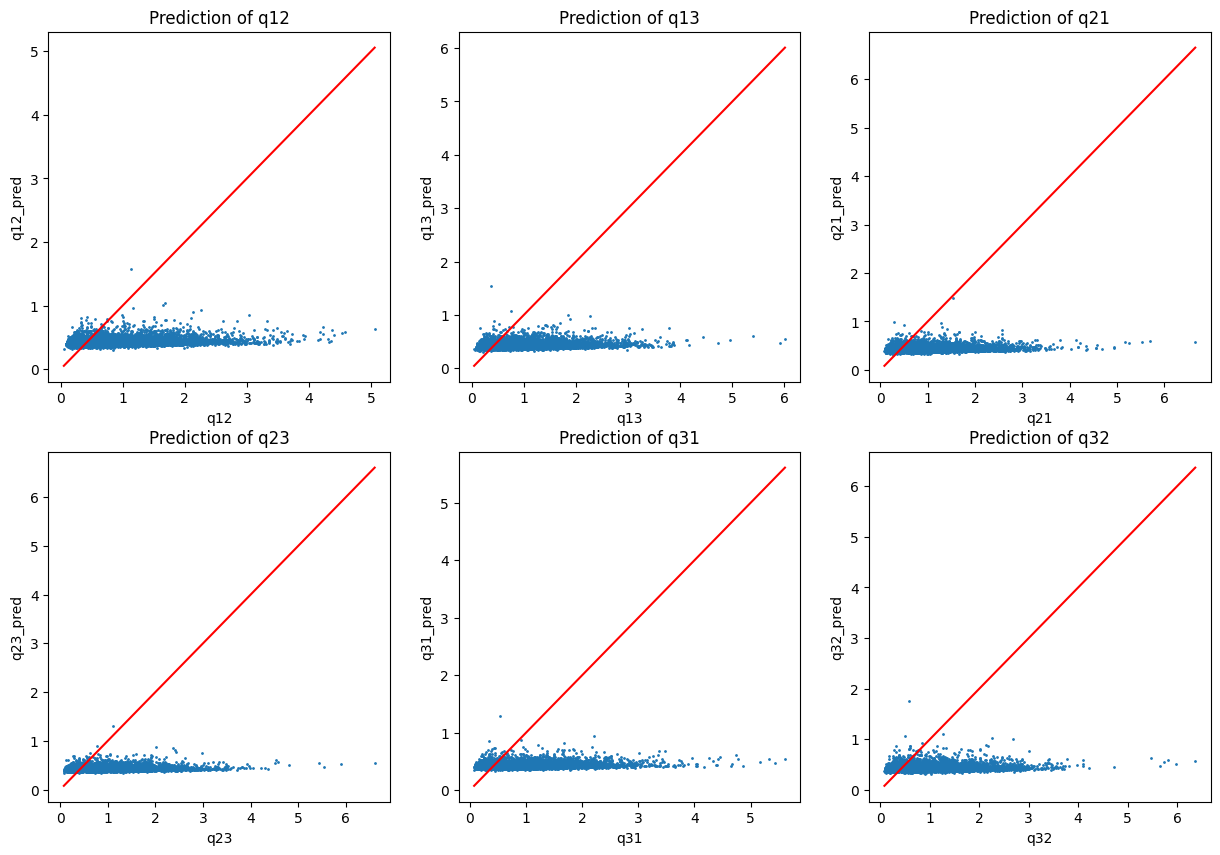

In [ ]:
if couples:
    # test the model on the test set
    lambda1_mu1 = model1.predict(X_test)
    lambda2_mu2 = model2.predict(X_test)
    lambda3_mu3 = model3.predict(X_test)
    q12_q13_q21_q23_q31_q32 = model4.predict(X_test)
    
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax[0, 0].scatter(Y1_test['lambda1_rescaled'], lambda1_mu1[:, 0], s=1)
    ax[0, 0].plot([min(Y1_test['lambda1_rescaled']), max(Y1_test['lambda1_rescaled'])], [min(Y1_test['lambda1_rescaled']), max(Y1_test['lambda1_rescaled'])], color='red')
    ax[0, 0].set_xlabel('lambda1')
    ax[0, 0].set_ylabel('lambda1_pred')
    ax[0, 0].set_title('Prediction of lambda1')
    
    ax[0, 1].scatter(Y1_test['mu1_rescaled'], lambda1_mu1[:, 1], s=1)
    ax[0, 1].plot([min(Y1_test['mu1_rescaled']), max(Y1_test['mu1_rescaled'])], [min(Y1_test['mu1_rescaled']), max(Y1_test['mu1_rescaled'])], color='red')
    ax[0, 1].set_xlabel('mu1')
    ax[0, 1].set_ylabel('mu1_pred')
    ax[0, 1].set_title('Prediction of mu1')
    
    ax[0, 2].scatter(Y2_test['lambda2_rescaled'], lambda2_mu2[:, 0], s=1)
    ax[0, 2].plot([min(Y2_test['lambda2_rescaled']), max(Y2_test['lambda2_rescaled'])], [min(Y2_test['lambda2_rescaled']), max(Y2_test['lambda2_rescaled'])], color='red')
    ax[0, 2].set_xlabel('lambda2')
    ax[0, 2].set_ylabel('lambda2_pred')
    
    ax[1, 0].scatter(Y2_test['mu2_rescaled'], lambda2_mu2[:, 1], s=1)
    ax[1, 0].plot([min(Y2_test['mu2_rescaled']), max(Y2_test['mu2_rescaled'])], [min(Y2_test['mu2_rescaled']), max(Y2_test['mu2_rescaled'])], color='red')
    ax[1, 0].set_xlabel('mu2')
    ax[1, 0].set_ylabel('mu2_pred')
    
    ax[1, 1].scatter(Y3_test['lambda3_rescaled'], lambda3_mu3[:, 0], s=1)
    ax[1, 1].plot([min(Y3_test['lambda3_rescaled']), max(Y3_test['lambda3_rescaled'])], [min(Y3_test['lambda3_rescaled']), max(Y3_test['lambda3_rescaled'])], color='red')
    ax[1, 1].set_xlabel('lambda3')
    ax[1, 1].set_ylabel('lambda3_pred')
    
    ax[1, 2].scatter(Y3_test['mu3_rescaled'], lambda3_mu3[:, 1], s=1)
    ax[1, 2].plot([min(Y3_test['mu3_rescaled']), max(Y3_test['mu3_rescaled'])], [min(Y3_test['mu3_rescaled']), max(Y3_test['mu3_rescaled'])], color='red')
    ax[1, 2].set_xlabel('mu3')
    ax[1, 2].set_ylabel('mu3_pred')
    
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax[0, 0].scatter(Y4_test['q12_rescaled'], q12_q13_q21_q23_q31_q32[:, 0], s=1)
    ax[0, 0].plot([min(Y4_test['q12_rescaled']), max(Y4_test['q12_rescaled'])], [min(Y4_test['q12_rescaled']), max(Y4_test['q12_rescaled'])], color='red')
    ax[0, 0].set_xlabel('q12')
    ax[0, 0].set_ylabel('q12_pred')
    ax[0, 0].set_title('Prediction of q12')
    
    ax[0, 1].scatter(Y4_test['q13_rescaled'], q12_q13_q21_q23_q31_q32[:, 1], s=1)
    ax[0, 1].plot([min(Y4_test['q13_rescaled']), max(Y4_test['q13_rescaled'])], [min(Y4_test['q13_rescaled']), max(Y4_test['q13_rescaled'])], color='red')
    ax[0, 1].set_xlabel('q13')
    ax[0, 1].set_ylabel('q13_pred')
    ax[0, 1].set_title('Prediction of q13')
    
    ax[0, 2].scatter(Y4_test['q21_rescaled'], q12_q13_q21_q23_q31_q32[:, 2], s=1)
    ax[0, 2].plot([min(Y4_test['q21_rescaled']), max(Y4_test['q21_rescaled'])], [min(Y4_test['q21_rescaled']), max(Y4_test['q21_rescaled'])], color='red')
    ax[0, 2].set_xlabel('q21')
    ax[0, 2].set_ylabel('q21_pred')
    ax[0, 2].set_title('Prediction of q21')
    
    ax[1, 0].scatter(Y4_test['q23_rescaled'], q12_q13_q21_q23_q31_q32[:, 3], s=1)
    ax[1, 0].plot([min(Y4_test['q23_rescaled']), max(Y4_test['q23_rescaled'])], [min(Y4_test['q23_rescaled']), max(Y4_test['q23_rescaled'])], color='red')
    ax[1, 0].set_xlabel('q23')
    ax[1, 0].set_ylabel('q23_pred')
    ax[1, 0].set_title('Prediction of q23')
    
    ax[1, 1].scatter(Y4_test['q31_rescaled'], q12_q13_q21_q23_q31_q32[:, 4], s=1)
    ax[1, 1].plot([min(Y4_test['q31_rescaled']), max(Y4_test['q31_rescaled'])], [min(Y4_test['q31_rescaled']), max(Y4_test['q31_rescaled'])], color='red')
    ax[1, 1].set_xlabel('q31')
    ax[1, 1].set_ylabel('q31_pred')
    ax[1, 1].set_title('Prediction of q31')
    
    ax[1, 2].scatter(Y4_test['q32_rescaled'], q12_q13_q21_q23_q31_q32[:, 5], s=1)
    ax[1, 2].plot([min(Y4_test['q32_rescaled']), max(Y4_test['q32_rescaled'])], [min(Y4_test['q32_rescaled']), max(Y4_test['q32_rescaled'])], color='red')
    ax[1, 2].set_xlabel('q32')
    ax[1, 2].set_ylabel('q32_pred')
    ax[1, 2].set_title('Prediction of q32')
    
            
    
    
    

In [ ]:
#expname = '51k_lambda_mu'

# Save the model
model.save(chemin + '/model_' + expname + '.h5')

In [ ]:
# Read the model
model = tf.keras.models.load_model(chemin + '/model_' + expname + '.h5')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
from sklearn.model_selection import train_test_split
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from tensorflow.keras import layers, Model
import numpy as np

# Define your features and targets
# Assuming 'features' and 'targets' are your input data and labels respectively

# Define the initial temperature, final temperature, and cooling rate
initial_temperature = 1.0
final_temperature = 0.01
cooling_rate = 0.99

# Define the number of iterations for SA
num_iterations = 1000

hist = []

def build_modelx(output_size):
    model = Sequential()
    model.add(Dense(output_size, activation=LeakyReLU(alpha=0.1)))
    return model

# Define the initial model
current_model = build_modelx(output_size=targets.shape[1])
current_model.compile(optimizer='adam', loss='mean_squared_error')  # Modify optimizer and loss function as needed
current_model.build(features.shape)  # Build the model with the input shape
current_loss = float('inf')  # Initialize with a high loss

# Loop over SA iterations
for i in range(num_iterations):
    # Perturb the current model parameters (weights and biases)
    perturbed_model = build_modelx(output_size=targets.shape[1])  # Create a new model with the same architecture
    perturbed_model.build(features.shape)  # Build the model with the input shape
    perturbed_model.set_weights(current_model.get_weights())  # Copy the weights and biases from the current model

    # Randomly perturb the weights and biases
    for layer in perturbed_model.layers:
        if hasattr(layer, 'kernel'):
            noise = np.random.normal(loc=0.0, scale=0.1, size=layer.kernel.shape)
            perturbed_model.set_weights([layer.kernel + noise, layer.bias])
            
        if hasattr(layer, 'bias'):
            noise = np.random.normal(loc=0.0, scale=0.1, size=layer.bias.shape)
            perturbed_model.set_weights([layer.kernel, layer.bias + noise])
            

    # Compile and evaluate the perturbed model
    perturbed_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])  # Modify optimizer and loss function as needed
    hist.append(perturbed_model.fit(features, targets, epochs=100, validation_split=valid_frac, batch_size=128, callbacks=[early_stop, PrintDot()]))
    perturbed_loss = perturbed_model.evaluate(features, targets)

    # Acceptance criterion based on the SA algorithm
    temperature = initial_temperature * (final_temperature / initial_temperature) ** (i / num_iterations)
    if temperature <= final_temperature:
        if perturbed_loss < current_loss:
            current_model = perturbed_model
            current_loss = perturbed_loss
        break
    if perturbed_loss < current_loss or (np.random.uniform(0, 1) < np.exp((current_loss - perturbed_loss) / temperature) and temperature > final_temperature):
        current_model = perturbed_model
        current_loss = perturbed_loss

# Once SA iterations are complete, 'current_model' will contain the best model found
current_model.summary()

Epoch 1/100
12/12 [==============================] - 0s 10ms/step - loss: 0.9295 - accuracy: 0.1697 - val_loss: 0.8643 - val_accuracy: 0.1745
Epoch 2/100
12/12 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.1710 - val_loss: 0.6835 - val_accuracy: 0.1615
Epoch 3/100
12/12 [==============================] - 0s 3ms/step - loss: 0.5780 - accuracy: 0.1658 - val_loss: 0.5907 - val_accuracy: 0.1589
Epoch 4/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5289 - accuracy: 0.1632 - val_loss: 0.5464 - val_accuracy: 0.1771
Epoch 5/100
12/12 [==============================] - 0s 4ms/step - loss: 0.5053 - accuracy: 0.1593 - val_loss: 0.5113 - val_accuracy: 0.1823
Epoch 6/100
12/12 [==============================] - 0s 5ms/step - loss: 0.4847 - accuracy: 0.1645 - val_loss: 0.4872 - val_accuracy: 0.1927
Epoch 7/100
12/12 [==============================] - 0s 5ms/step - loss: 0.4699 - accuracy: 0.1704 - val_loss: 0.4700 - val_accuracy: 0.1979
Epoch 8/100


TypeError: '<' not supported between instances of 'list' and 'float'

In [ ]:
# Now do the same with targets2

if model_name == "musse" and len(targets.columns) <= 6:
    # Building the model
    model2 = build_model()

    with tf.device('/GPU:0'):  # Specify GPU device
        history2 = model2.fit(X, Y2, epochs=250, validation_split=valid_frac, batch_size=2048, callbacks=[early_stop, PrintDot(), lr_schedule])

In [ ]:
if model_name == "musse" and len(targets.columns) <= 6:
    # Save the model
    expname = '51k_q'
    model2.save(chemin + '/model2_' + expname + '.h5')

In [ ]:
"""import keras
from keras import layers


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            # Tune number of units.
            units=hp.Int("units", min_value=32, max_value=512, step=32),
            # Tune the activation function to use.
            activation=hp.Choice("activation", ["relu", "tanh"]),
        )
    )
    # Tune whether to use dropout.
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(12, activation="softmax"))
    # Define the optimizer learning rate as a hyperparameter.
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=["mse"],
    )
    return model


import keras_tuner

model = build_model(keras_tuner.HyperParameters())


#Possibility of using a "multi gpu" estimator (but doesn't work quite well for me...), and other optimizers (the default Adam optimizer seems to be the better one, though)
'''
parallel_estimator = multi_gpu_model(model, gpus=2)
optimizer = tf.train.RMSPropOptimizer(0.001)
'''

# Building the model
model = build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

tuner.search_space_summary()

tuner.search(X, Y, epochs=5, validation_split=0.2)

# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

tuner.results_summary()"""

'import keras\nfrom keras import layers\n\n\ndef build_model(hp):\n    model = keras.Sequential()\n    model.add(layers.Flatten())\n    model.add(\n        layers.Dense(\n            # Tune number of units.\n            units=hp.Int("units", min_value=32, max_value=512, step=32),\n            # Tune the activation function to use.\n            activation=hp.Choice("activation", ["relu", "tanh"]),\n        )\n    )\n    # Tune whether to use dropout.\n    if hp.Boolean("dropout"):\n        model.add(layers.Dropout(rate=0.25))\n    model.add(layers.Dense(12, activation="softmax"))\n    # Define the optimizer learning rate as a hyperparameter.\n    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")\n    model.compile(\n        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),\n        loss="mse",\n        metrics=["mse"],\n    )\n    return model\n\n\nimport keras_tuner\n\nmodel = build_model(keras_tuner.HyperParameters())\n\n\n#Possibility of using

In [ ]:
"""tuner.results_summary()

# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
model.fit(X, Y, epochs=100, validation_split=0.2)"""

'tuner.results_summary()\n\n# Get the top 2 hyperparameters.\nbest_hps = tuner.get_best_hyperparameters(5)\n# Build the model with the best hp.\nmodel = build_model(best_hps[0])\n# Fit with the entire dataset.\nmodel.fit(X, Y, epochs=100, validation_split=0.2)'

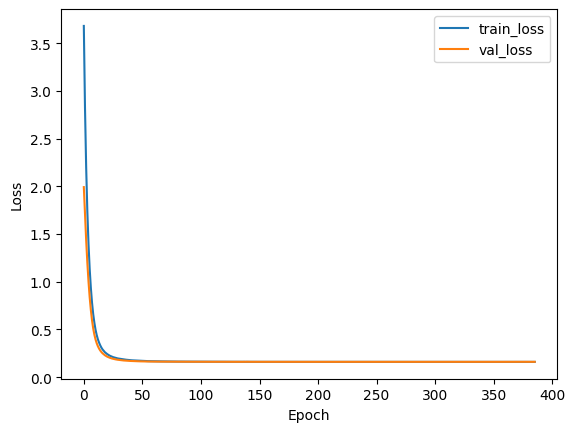

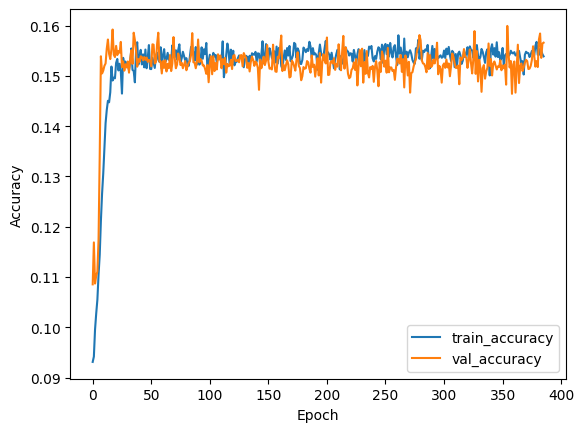

"\nplt.plot(history.history['mean_absolute_percentage_error'], label='train_MAPE')\nplt.plot(history.history['val_mean_absolute_percentage_error'], label='val_MAPE')\nplt.xlabel('Epoch')\nplt.ylabel('MAPE')\nplt.legend()\nplt.show()\n"

In [ ]:
import matplotlib.pyplot as plt
# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plot accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

"""
plt.plot(history.history['mean_absolute_percentage_error'], label='train_MAPE')
plt.plot(history.history['val_mean_absolute_percentage_error'], label='val_MAPE')
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend()
plt.show()
"""


In [ ]:
# Make predictions on the test dataset
predictions = model.predict(X_test)
#predictions2 = model2.predict(X_test)

495/495 [==============================] - 1s 1ms/step


[[0.46272784 0.46474266 0.46287787 ... 0.46692914 0.47080463 0.46877414]
 [0.47133622 0.47510844 0.47274628 ... 0.47303358 0.47701988 0.47678816]
 [0.40259975 0.39291918 0.39492816 ... 0.4236202  0.42636937 0.41359437]
 ...
 [0.40168843 0.3915153  0.39368397 ... 0.422989   0.42573845 0.41266888]
 [0.46776643 0.47077802 0.46858045 ... 0.470538   0.47433504 0.4735181 ]
 [0.47221604 0.47633627 0.47348514 ... 0.47348058 0.4775839  0.47738147]]
0        0.471847
1        0.738640
2        0.101613
3        0.908082
4        0.788041
           ...   
15808    0.798025
15809    0.419768
15810    0.588695
15811    0.682185
15812    0.333849
Name: lambda1_rescaled, Length: 15813, dtype: float64
0.89216864
0.9998169808120171


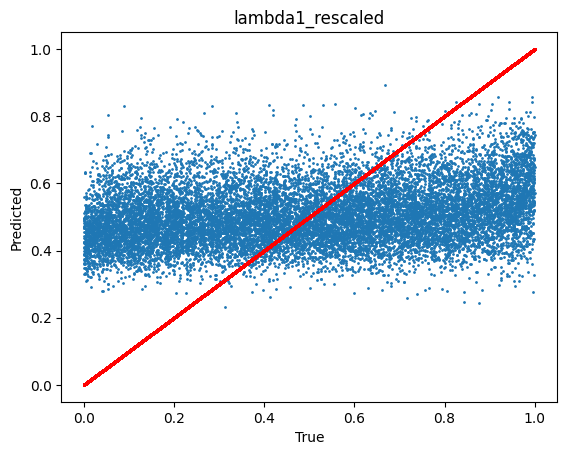

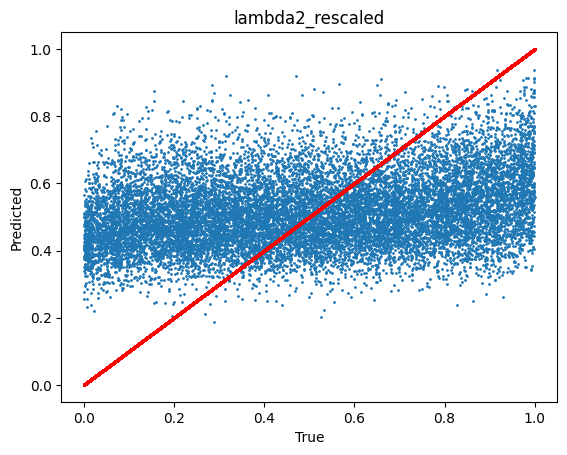

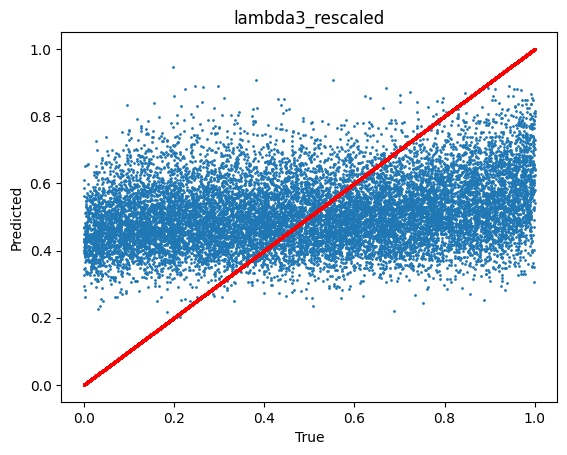

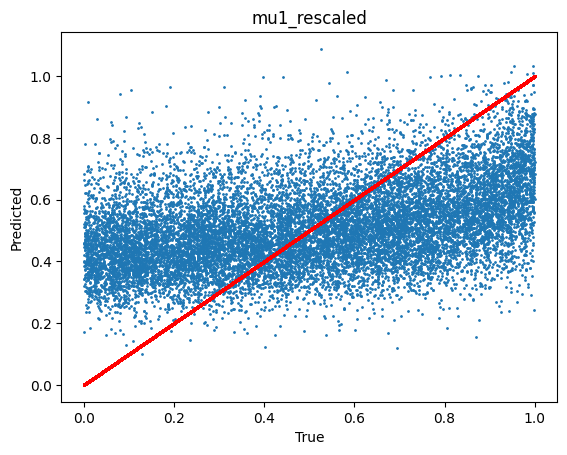

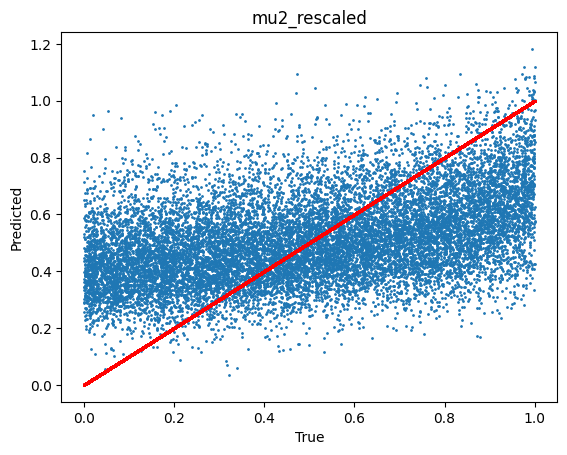

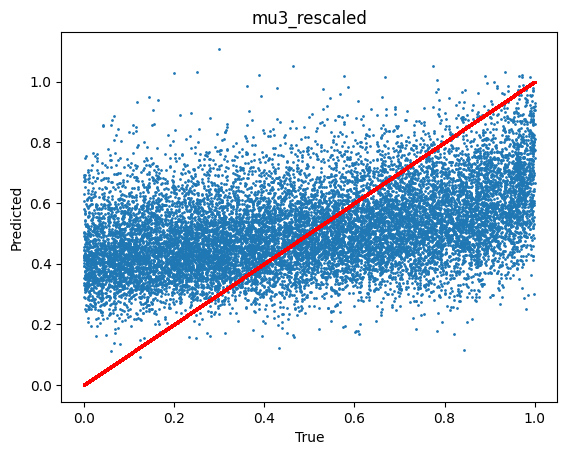

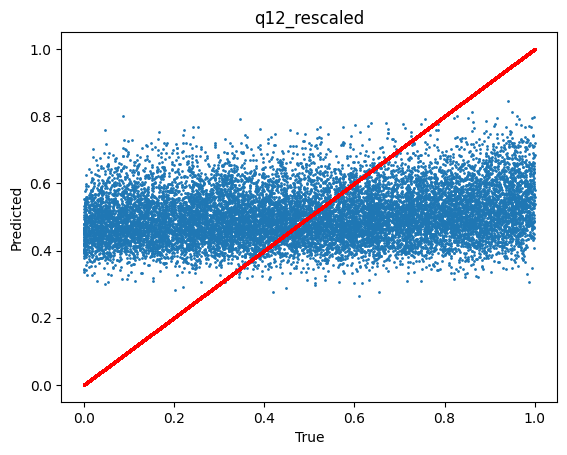

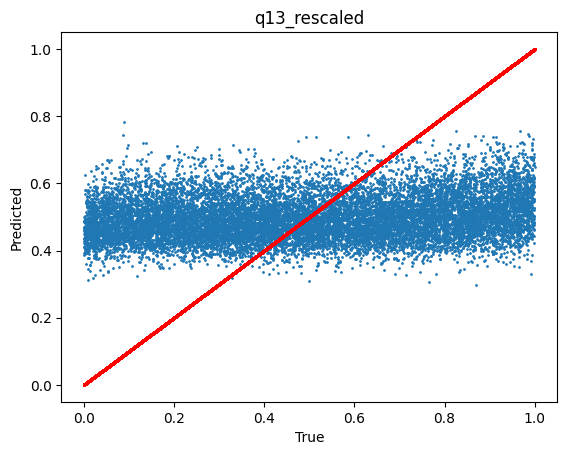

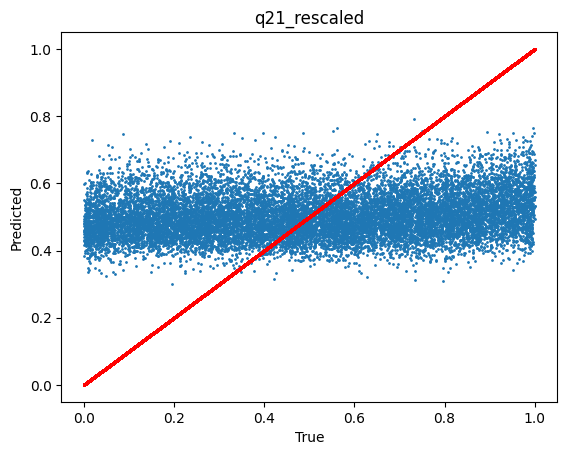

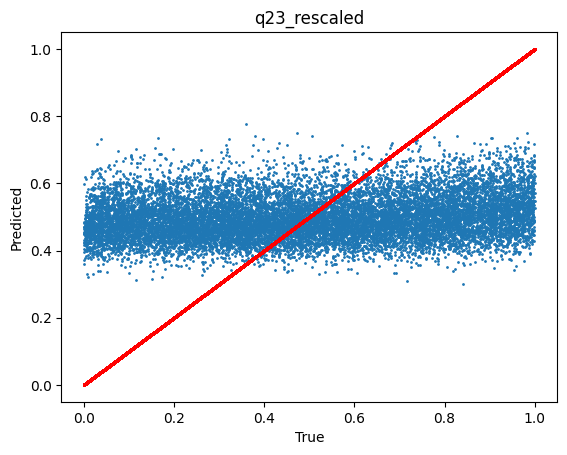

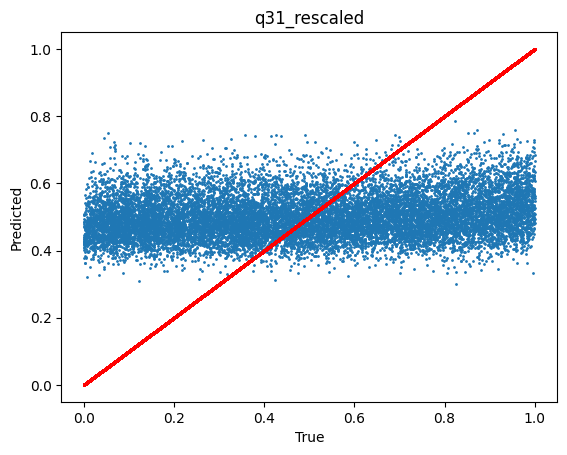

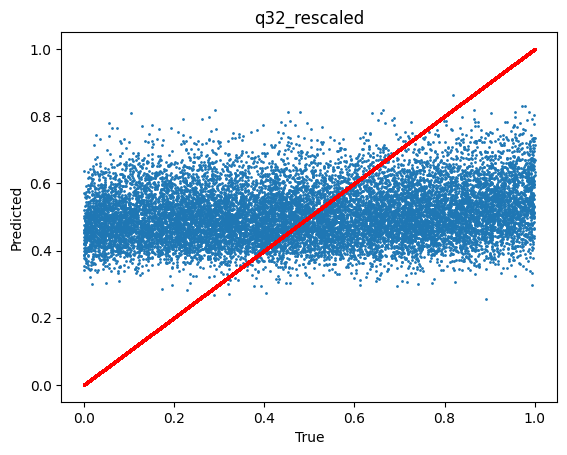

In [ ]:
import matplotlib.pyplot as plt

print(predictions)
print(Y_test.iloc[:, 0])

print(max(predictions[:, 0]))
print(max(Y_test.iloc[:, 0]))

# plot predictions vs true values for each parameter in the training set
for i in range(predictions.shape[1]):
    plt.scatter(Y_test.iloc[:, i], predictions[:, i], s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(Y_test.columns[i])
    # add a diagonal line
    plt.scatter(Y_test, Y_test, color='red', s =1)
    plt.show()


In [ ]:
# Predict the training set
predictions_train = model.predict(X)
#predictions_train2 = model2.predict(X)

# plot predictions vs true values for each parameter in the training set
for i in range(predictions_train.shape[1]):
    plt.scatter(Y.iloc[:, i], predictions_train[:, i], s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(Y.columns[i] + ' (training set)')
    # add a diagonal line
    plt.plot(Y.iloc[:,i], Y.iloc[:,i], color='red')
    plt.show()

NameError: name 'model' is not defined

In [ ]:
if model_name == "musse" and len(targets.columns) <= 6:
    for i in range(predictions2.shape[1]):
        plt.scatter(Y_test2.iloc[:, i], predictions2[:, i], s=1)
        plt.xlabel('True')
        plt.ylabel('Predicted')
        plt.title(Y_test2.columns[i])
        # add a diagonal line
        plt.plot([Y_test2.iloc[:, i].min(), Y_test2.iloc[:, i].max()], [Y_test2.iloc[:, i].min(), Y_test2.iloc[:, i].max()], color='red')
        plt.show()
        plt.savefig(chemin + '/prediction2_' + Y_test2.columns[i] + '.png')

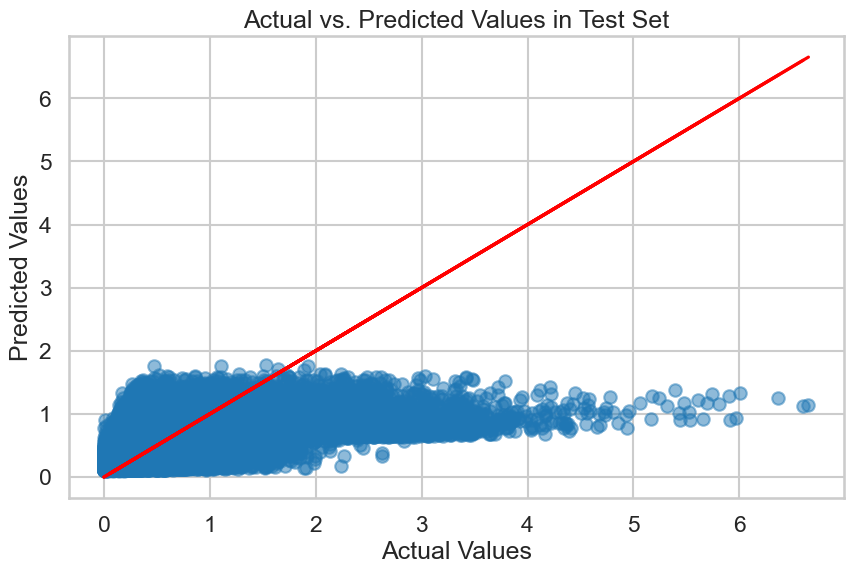

Mean Absolute Error (MAE):
 0.2929202343452109
Mean Absolute Percentage Error (MAPE):
 223.28542928972968


<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot predictions vs. actuals
plt.figure(figsize=(10, 6))
# small size points
plt.scatter(Y_test, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values in Test Set')
# add perfect fit line
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red')
plt.show()
plt.savefig(chemin + '/prediction_all.png')

# Calculate performance metrics
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(Y_test, predictions)
print("Mean Absolute Error (MAE):\n", mae)

# If your Y values are in a wide range, it's useful to normalize them before computing MAPE
mape = np.mean(np.abs((Y_test - predictions) / Y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):\n", mape)

In [ ]:
# plot absolute errors with respect to the tree size, the file is trees directory + model + ".sizes", text lines
sizes = []
sizes = pd.read_csv(trees_directory + model_name + '.sizes', sep='\t', header=None)
print(sizes.shape)
sizes = sizes.drop(lines_to_remove)

    

# take only the sizes that correspond to the test set
sizes = sizes[cutoff:][0]
errors = np.abs(Y_test - predictions)

print(sizes.shape)
print(errors.shape)

# for each parameter, plot the absolute error vs. tree size
for i in range(targets.shape[1]):
    plt.scatter(sizes, errors.iloc[:, i], s=1)
    # add trend line
    z = np.polyfit(sizes, errors.iloc[:, i], 1)
    p = np.poly1d(z)
    plt.plot(sizes, p(sizes), "r--")
    # add 95% confidence interval
    plt.fill_between(sizes, p(sizes) - 1.96 * np.std(errors.iloc[:, i]), p(sizes) + 1.96 * np.std(errors.iloc[:, i]), color='r', alpha=0.2)
    plt.xlabel('Tree Size')
    plt.ylabel('Absolute Error')
    plt.title(targets.columns[i])
    # start from 0, set ylim to be the max value of the parameter
    maxval = Y_test.iloc[:, i].max()
    plt.ylim([0, maxval])
    plt.show()


In [ ]:
%pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.


561/561 [==============================] - 2s 4ms/step


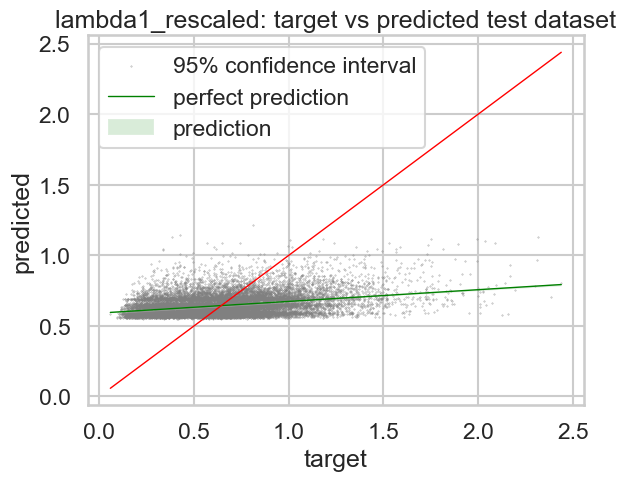

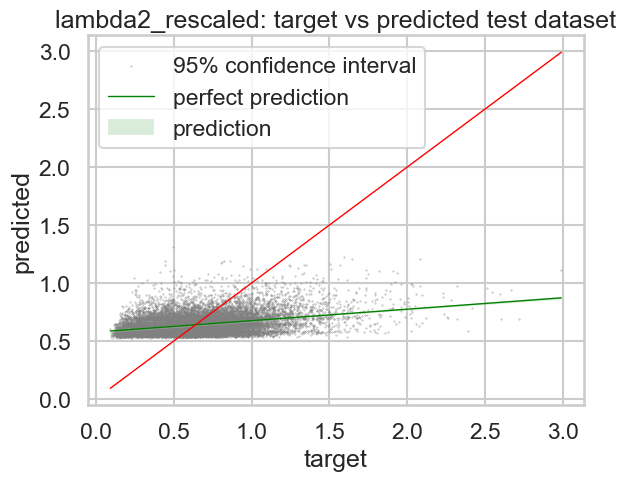

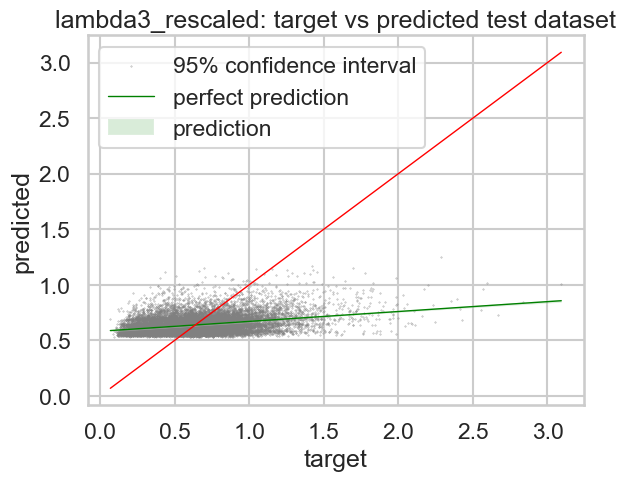

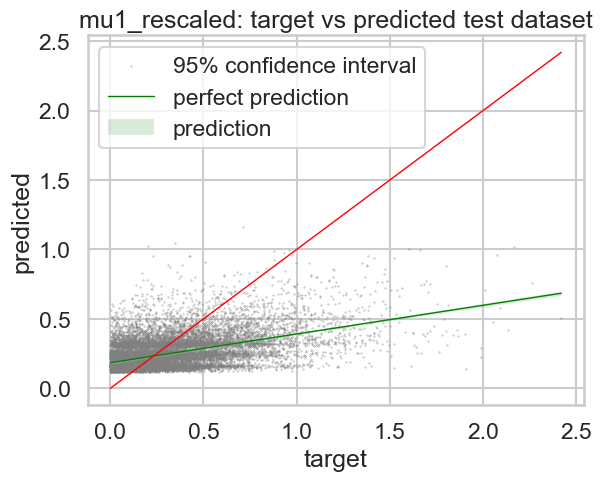

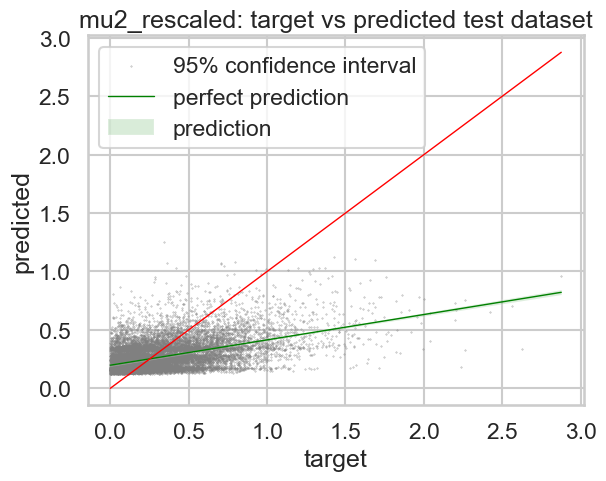

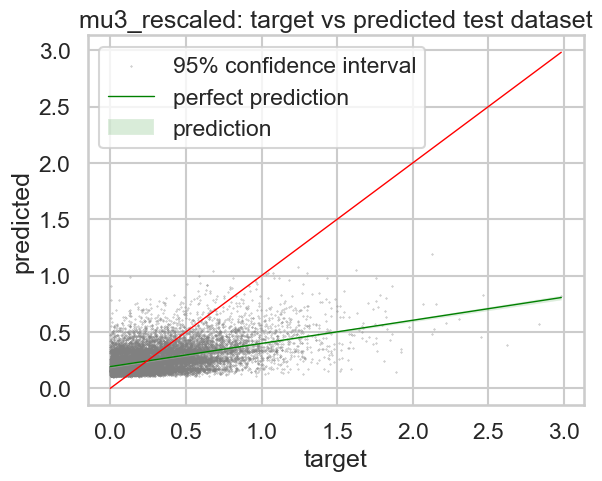

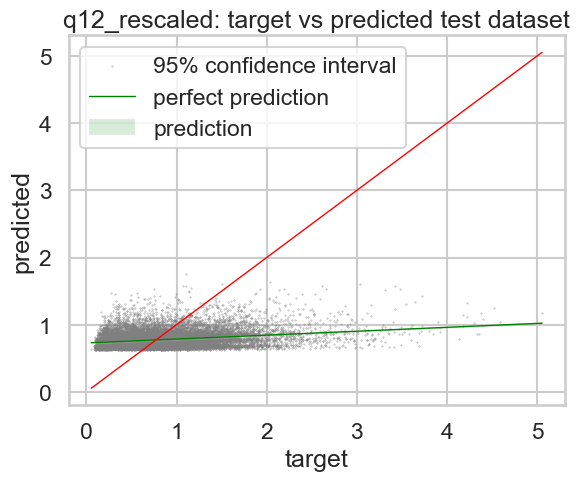

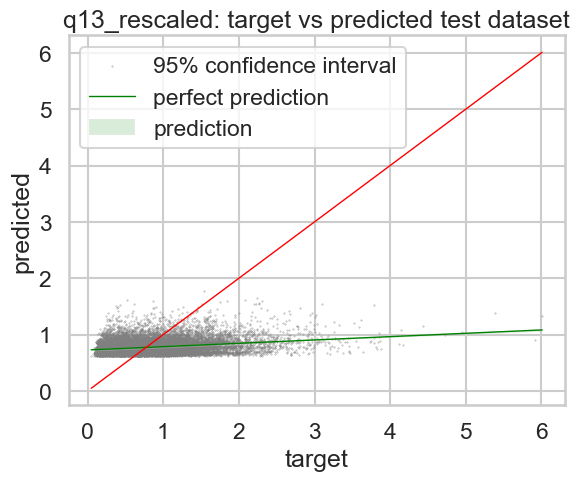

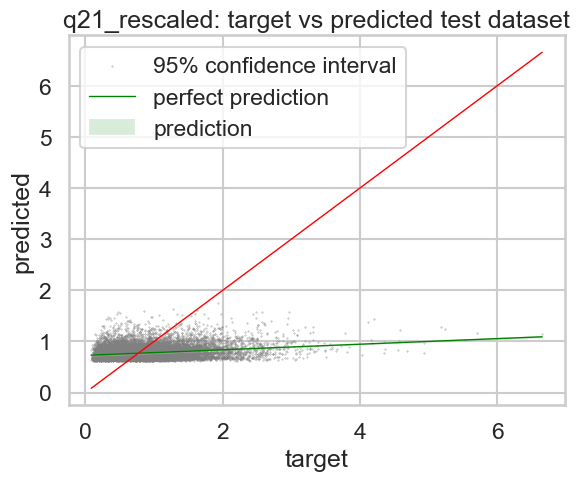

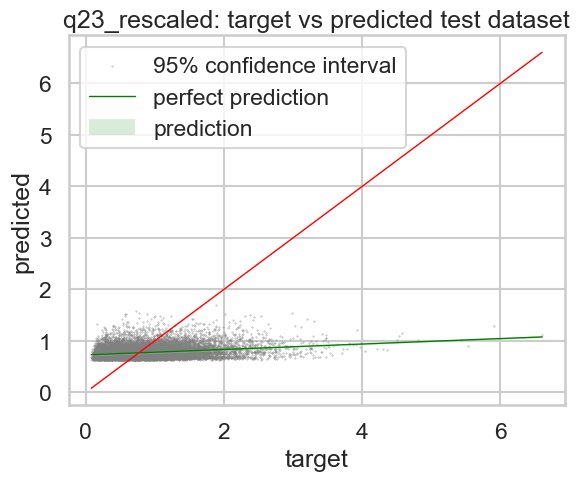

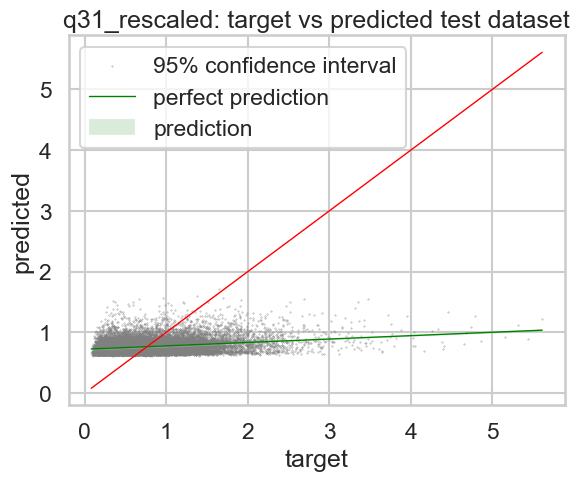

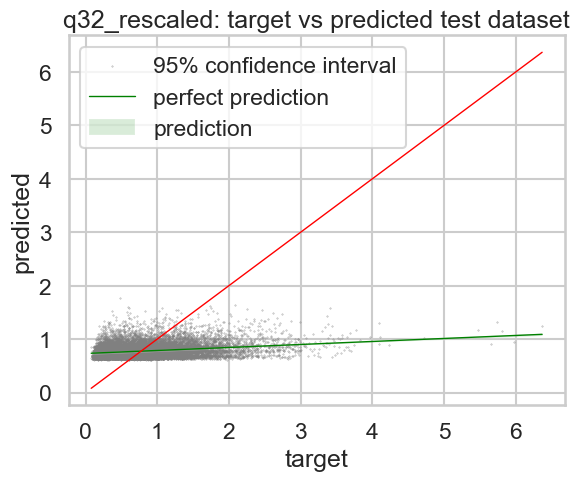

In [ ]:
#import statsmodel.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

#Plot test vs predicted
# predict values for the test set
predicted_test = pd.DataFrame(model.predict(X_test))
predicted_test.columns = Y_test.columns # rename correctly the columns
predicted_test.index = Y_test.index # rename indexes for correspondence

elts = []

# just for subsetting columns more automatically + naming output plots
for elt in Y_test.columns:
    elts.append(elt)

for elt in elts:
    sub_df = pd.DataFrame({'predicted_minus_target_' + elt: predicted_test[elt] - Y_test[elt], 'target_'+elt: Y_test[elt], 'predicted_'+elt: predicted_test[elt]})
    if elt == elts[0]:
        df = sub_df
    else:
        sub_df.index = df.index
        df = pd.concat([df, sub_df], axis=1)
    

# fast plotting for analysis (with seaborn):
def target_vs_predicted(target_name, predicted_name, param_name, file_name_beg) : 
    sns.set_style('whitegrid')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=predicted_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':1})
    plt.title(param_name + ': target vs predicted test dataset')
    plt.xlabel('target')
    plt.ylabel('predicted')
    innerlimit = min(df[target_name])
    outerlimit = max(df[target_name])
    plt.plot([innerlimit, outerlimit], [innerlimit, outerlimit], linewidth=1, color='red', label='perfect prediction')
    plt.legend(['95% confidence interval', 'perfect prediction', 'prediction'])
    
    plt.savefig(chemin + '/' + file_name_beg + '_target_vs_predicted.png')
    plt.show()
    return None

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    


for elt in elts:
    target_vs_predicted('target_'+elt, 'predicted_'+elt, elt, file_name_beg=elt)


    
    

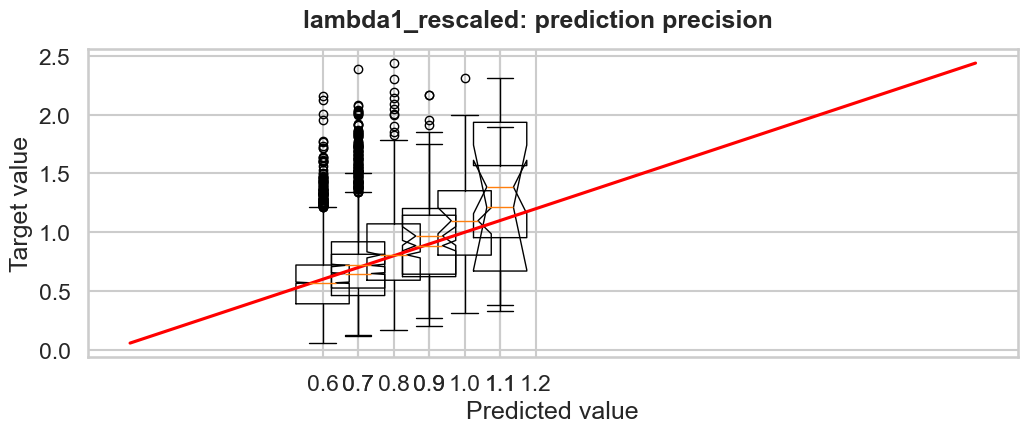

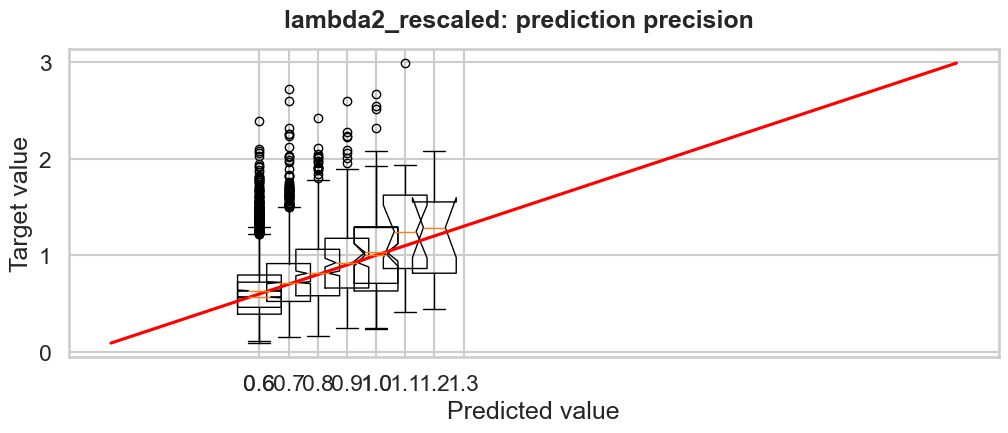

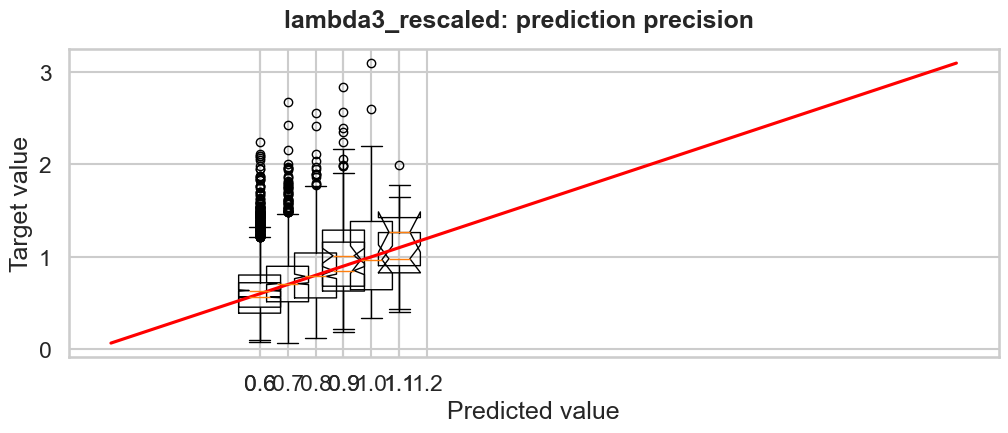

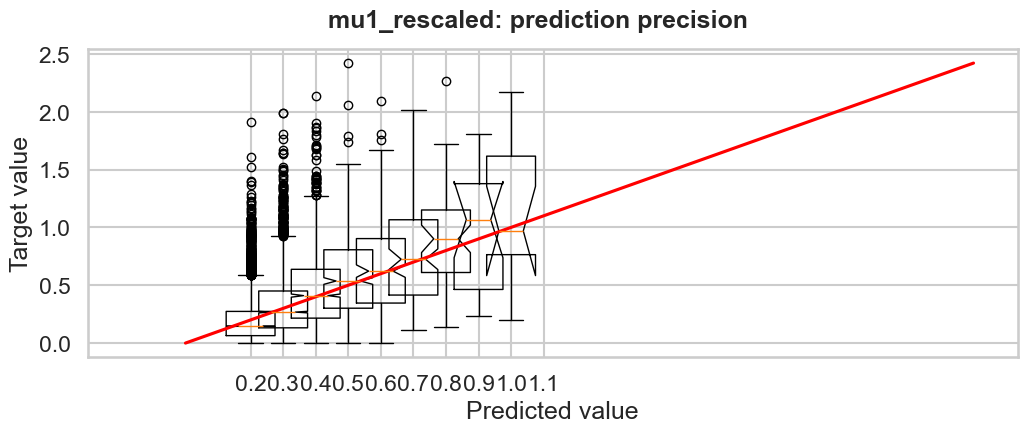

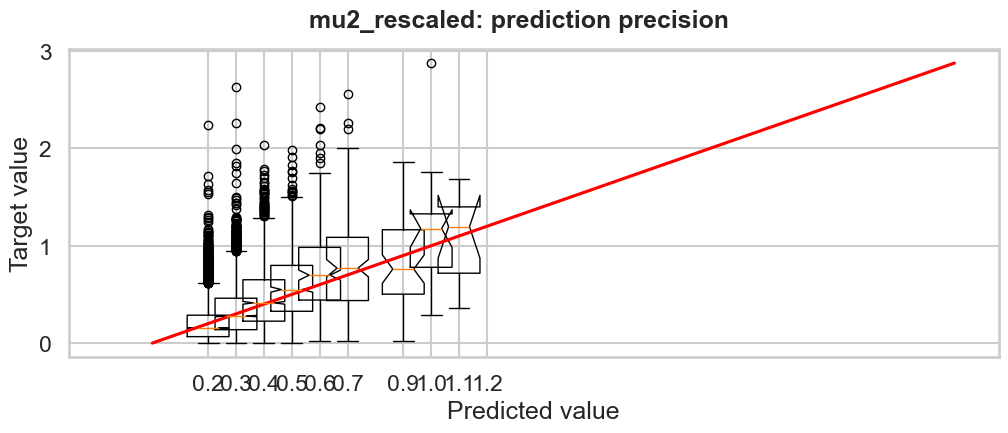

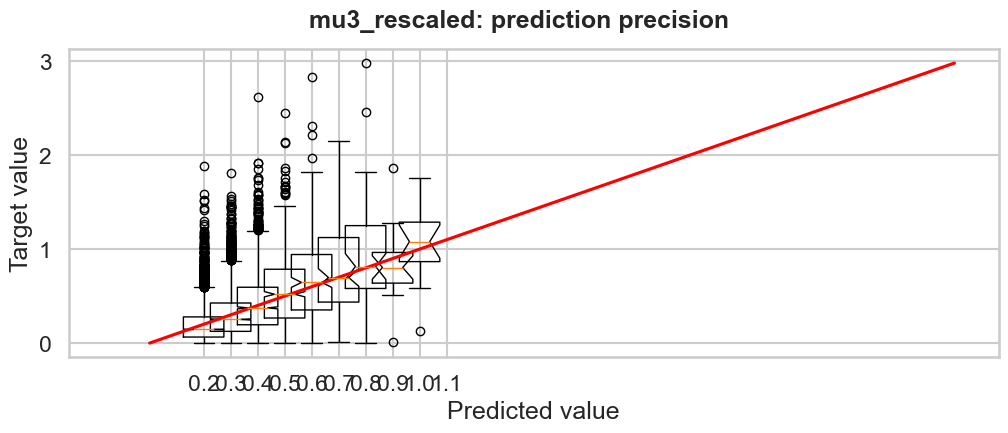

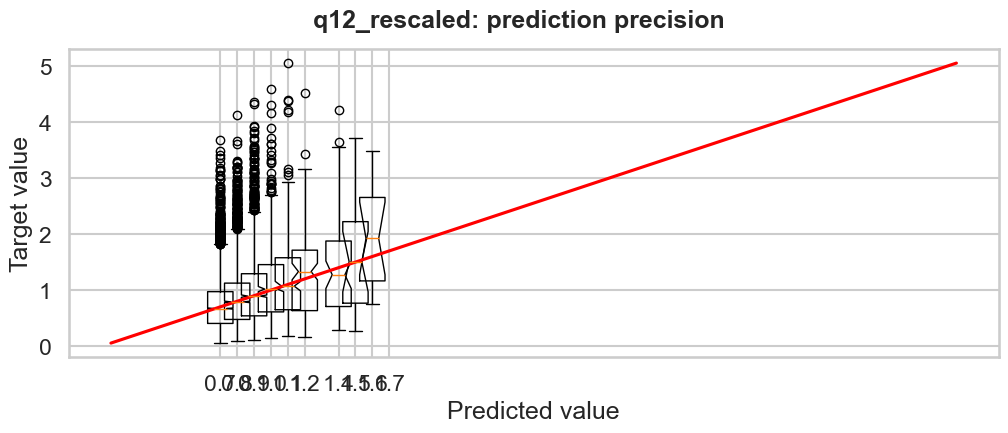

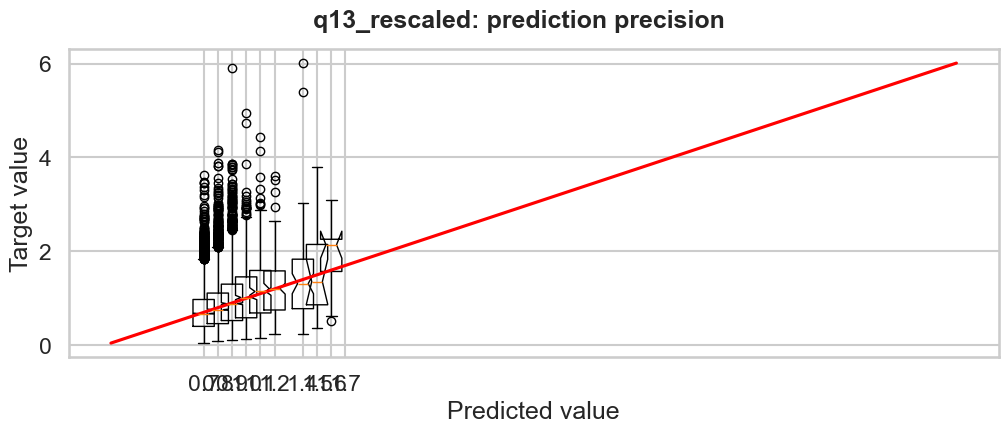

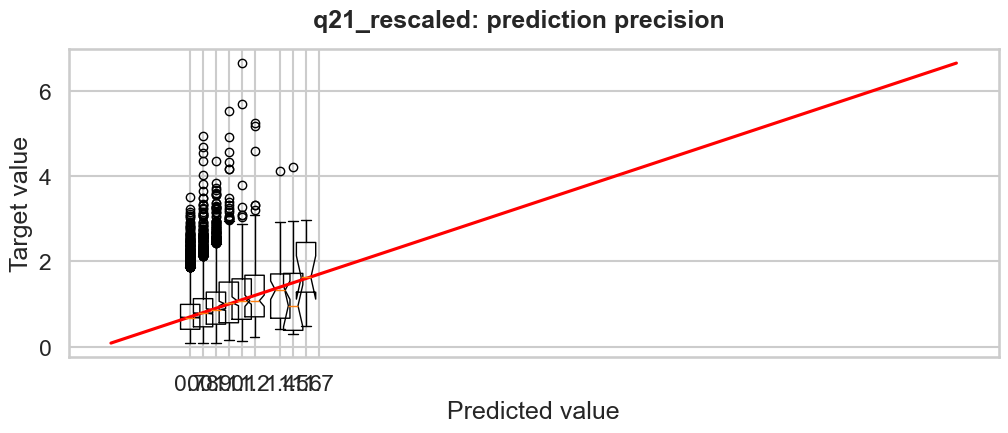

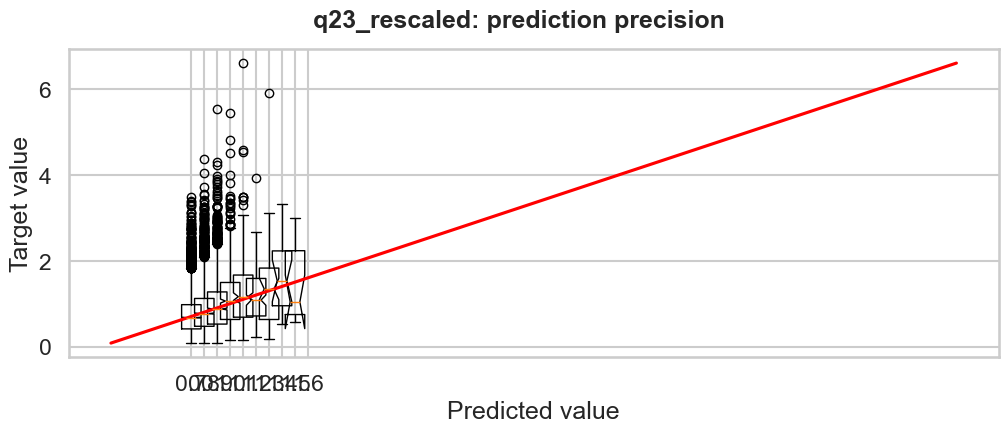

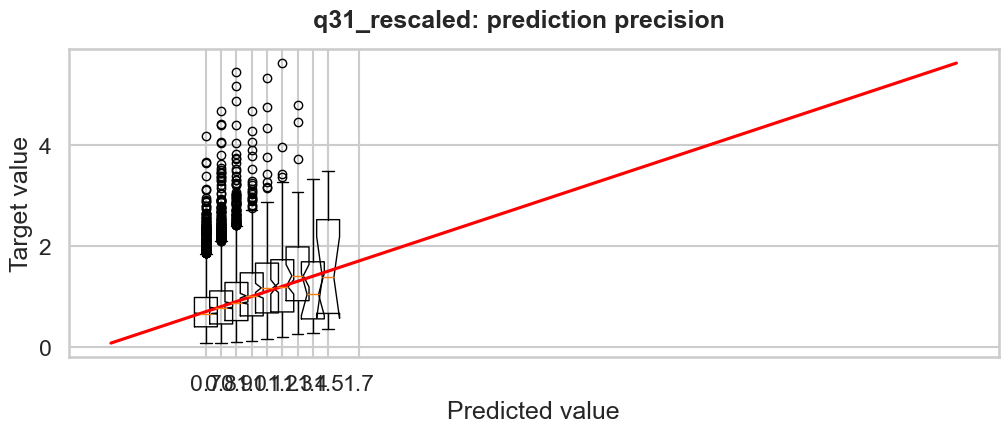

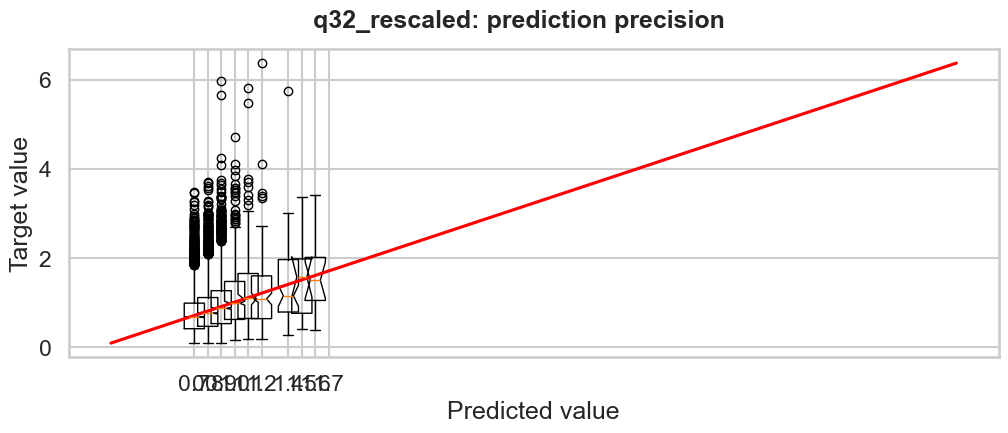

In [ ]:
###boxplots

from pylab import *

def sd_bins(name_target, name_predicted, nb_bins):
    b_indexes = np.digitize(df[name_predicted], bins=np.linspace(min(df[name_predicted]),max(df[name_predicted]),num=nb_bins))
    list_sd = []
    x_axis = []
    
    list_b = [[] for i in range(max(b_indexes)-1)]
    for i in range(1, nb_bins):
        list_b[i-1] = np.array(df[name_target][b_indexes == i])
        #print(df[name_target][b_indexes == i])
        #print(i)
        #print(len(df['predicted_minus_target_R_nought'][a_indexes == i]))
        if len(list_b[i-1]) > 1:
            list_sd.append(np.std(list_b[i-1]))
        else :
            list_sd.append([None])
    
    x_bins = np.linspace(min(df[name_predicted]), max(df[name_predicted]), num=nb_bins)
    
    for i in range(0,len(x_bins)-1):
        x_axis.append(float("{0:.1f}".format((x_bins[i]+x_bins[i+1])/2)))
        
    return list_b, list_sd, x_axis        

def plot_boxplot(name_target, name_predicted, nb_bin, maintitle, directory, file_name):
    min_val = min(df[name_target])
    
    max_val = max(df[name_target])
    
    arrays_target, array_sd, position_list = sd_bins(name_target, name_predicted, nb_bins=nb_bin)
    fig = plt.figure(figsize=(12,4))
    fig.suptitle(maintitle, fontsize=18, fontweight='bold')
    
    ax = fig.add_subplot(111)
    ax.boxplot(arrays_target, positions=position_list, notch=True)
    
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Target value')

    
    plt.plot(np.linspace(min_val, max_val, 5), np.linspace(min_val, max_val, 5), color='red')
    #plt.savefig('../Plots2/' + chemin + file_name + '.png')
    #plt.savefig('../Plots/' + directory + file_name + '.png')
    plt.show()
    return None
    
for elt in elts:
    plot_boxplot('target_'+elt, 'predicted_'+elt, 11, elt+': prediction precision', directory = chemin, file_name='boxplot_' + elt + '_pred_vs_target')

#plot_boxplot('target_sampling_proba','predicted_sampling_proba', 11 , 'Transmission rate: prediction precision', min_val=0, max_val=1, directory = chemin, file_name='boxplot_sampling_proba_pred_vs_target')


In [ ]:
# table with statistics on errors
errors_index = elts
errors_columns = ['MAE', 'RMSE', 'RME']
errors = pd.DataFrame(index=errors_index, columns=errors_columns)

def get_mae_rmse(name_var):
    predicted_vals = df['predicted_' + name_var]
    target_vals = df['target_' + name_var]
    diffs_abs = abs(target_vals - predicted_vals)
    diffs_rel = diffs_abs/target_vals
    diffs_abs_squared = diffs_abs**2
    mae = np.sum(diffs_abs)/len(diffs_abs)
    rmse = np.sqrt(sum(diffs_abs_squared)/len(diffs_abs_squared))
    rme = np.sum(diffs_rel)/len(diffs_rel)
    return mae, rmse, rme
    

#errors.loc['R_nought'] = np.array(get_mae_rmse('R_nought'))
for elt in errors_index:
    errors.loc[elt] = np.array(get_mae_rmse(elt))

print(errors)



# do the same with scaled values

# multiply the errors by the mean of the scaling factor
errors_scaled = errors.copy()
errors_scaled['MAE'] = errors['MAE']*param_test['norm_factor'].mean()
errors_scaled['RMSE'] = errors['RMSE']*param_test['norm_factor'].mean()
errors_scaled['RME'] = errors['RME']

                      MAE      RMSE       RME
lambda_rescaled  0.056909   0.08028    0.0853
mu_rescaled      0.083827  0.112448  2.041375


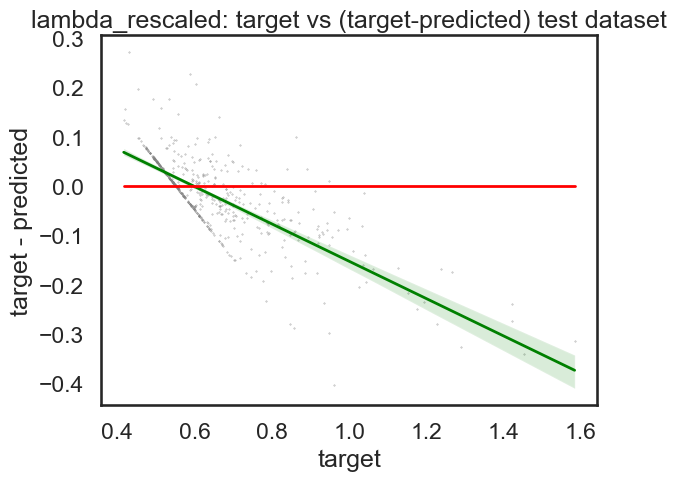

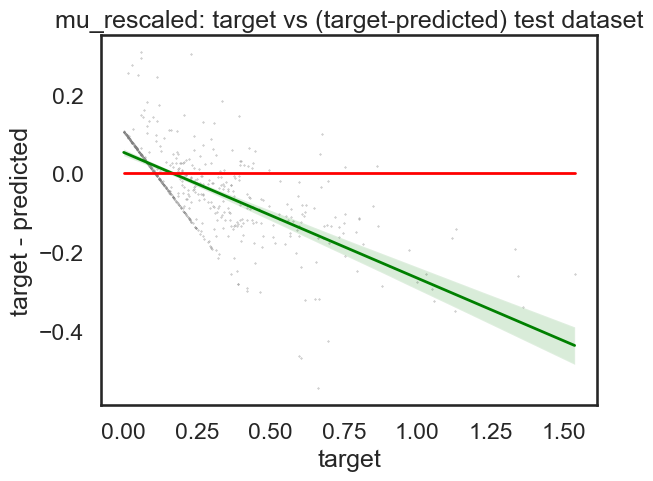

In [ ]:
#print differences between predicted and target as function of target: showing structural bias

def predicted_minus_target_vs_target(pr_m_tar_name, target_name, param_name, file_name_beg) : 
    sns.set_style('white')
    sns.set_context('talk')
    sns.regplot(x=target_name, y=pr_m_tar_name, data=df, ci=95, n_boot=500, 
                scatter_kws={'s':0.1, 'color':'grey'}, line_kws={ 'color':'green', 'linewidth':2})
    plt.title(param_name + ': target vs (target-predicted) test dataset')
    plt.xlabel('target')
    plt.ylabel('target - predicted')
    innerlimit = min(df[target_name])
    
    outerlimit = max(df[target_name])
    
    plt.plot([innerlimit, outerlimit], [0, 0], linewidth=2, color='red')
    plt.show()
    return None


for elt in elts:
    predicted_minus_target_vs_target('predicted_minus_target_'+elt, 'target_'+elt, elt, file_name_beg=elt)


In [ ]:
#measure of correlation: predicted vs target
from scipy.stats import spearmanr, pearsonr

from sklearn.metrics import r2_score

pearson_cors = []

for elt in elts:
    pearson_cors.append(pearsonr(Y_test[elt], predicted_test[elt])[0])

print("Global pearson correlation between predicted and effective parameter: ", Y_test.columns, pearson_cors)


Global pearson correlation between predicted and effective parameter:  Index(['lambda_rescaled', 'mu_rescaled'], dtype='object') [0.8849553556012479, 0.9021199087929893]


In [ ]:
###save the model, weights (and scaler for sumstats only)

from tensorflow.keras.models import model_from_json

# save model
model_trial_1000 = model.to_json()
with open(chemin + '/model_all' + expname + '.json','w') as json_file:
    json_file.write(model_trial_1000)

# save weights
model.save_weights(chemin + '/model_all_weights' + expname +'.h5')
print('model saved!')

'''
#load the model
json_file = open('../Model/' + chemin + 'model_all' + expname + '.json', 'r')
loaded_file = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_file)
#load weights
loaded_model.load_weights(../Model/' + chemin + 'model_all_weights' + expname +'.h5'5)
print('model loaded!')

'''

#save scaler when there is one (FFNN-SS)
"""
from sklearn.externals import joblib

scale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'
joblib.dump(scale, scale_filename)

print('scale saved!')
#load scaler:
#scale = joblib.load(scale_filename)
"""


model saved!


"\nfrom sklearn.externals import joblib\n\nscale_filename = '../../Model/' + chemin + 'all_standardscaler' + expname + '.pkl'\njoblib.dump(scale, scale_filename)\n\nprint('scale saved!')\n#load scaler:\n#scale = joblib.load(scale_filename)\n"

In [ ]:
####save the predicted and the target dataframes

Y_test.to_csv(chemin + expname + 'target_all.csv', header=True)

predicted_test.to_csv(chemin + expname + 'predicted_all.csv', header=True)

## Statistics and Visualization

In [ ]:
import pandas as pd
chemin = './trained_models/musse/'
expname='90k'

# Read the data
Y_test = pd.read_csv(chemin + expname + 'target_all.csv', index_col=0)
predicted_test = pd.read_csv(chemin + expname + 'predicted_all.csv', index_col=0)

In [ ]:
table = pd.concat([Y_test.iloc[0], predicted_test.iloc[0]], axis=1)
table['difference'] = table.iloc[:, 0] - table.iloc[:, 1]
table['difference'] = table['difference'].apply(lambda x: f"{x:.2f}")
# set column names
table.columns = ['target', 'predicted', 'difference']
table


target  predicted difference
lambda_rescaled  0.508806   0.625949      -0.12
mu_rescaled      0.202154   0.228801      -0.03

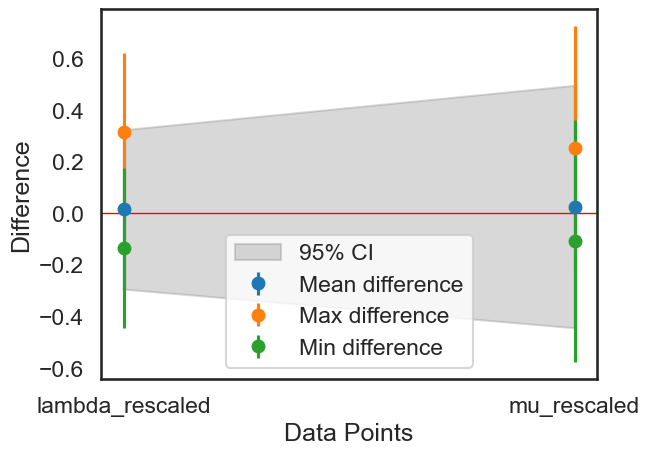

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming Y_test and predicted_test are already defined

table = pd.concat([Y_test.mean(), predicted_test.mean()], axis=1)
table['difference'] = table.iloc[:, 0] - table.iloc[:, 1]

# Calculate upper and lower bounds for 95% confidence interval
ci = 1.96 * Y_test.std()  # 1.96 is the z-value for 95% confidence interval in a standard normal distribution
upper_ci = table['difference'] + ci
lower_ci = table['difference'] - ci

# plot also points at max values and min values
max_vals = pd.concat([Y_test.max(), predicted_test.max()], axis=1)
max_vals['difference'] = max_vals.iloc[:, 0] - max_vals.iloc[:, 1]
min_vals = pd.concat([Y_test.min(), predicted_test.min()], axis=1)
min_vals['difference'] = min_vals.iloc[:, 0] - min_vals.iloc[:, 1]
plt.errorbar(table.index, table['difference'], yerr=ci, fmt='o', label='Mean difference')
plt.errorbar(max_vals.index, max_vals['difference'], yerr=ci, fmt='o', label='Max difference')
plt.errorbar(min_vals.index, min_vals['difference'], yerr=ci, fmt='o', label='Min difference')
plt.fill_between(table.index, lower_ci, upper_ci, color='grey', alpha=0.3, label='95% CI')

# Add horizontal line at y=0
plt.axhline(y=0, color='r', linestyle='-', linewidth=1)

# Add labels and legend
plt.xlabel('Data Points')
plt.ylabel('Difference')
plt.legend()

# Show plot
plt.show()


In [ ]:
# plot the absolute error with respect of the size of the tree
# compute the size of the tree
import numpy as np
import pandas as pd
import os
from ete3 import Tree

def get_tree_size(tree_file):
    with open(tree_file, 'r') as tree_file:
        forest = tree_file.read().replace("\n", "")
        trees = forest.split(";")
        sizes = []
        for i in range(0, len(trees)):
            print("\r" + "Processing tree " + str(i) + " of " + str(len(trees)))
            sys.stdout.flush()
            if len(trees[i]) > 0:
                tree = Tree(trees[i] + ";", format=1)
                size = len(tree.get_leaves())
                sizes.append(size)
        return sizes

# Load the tree files
trees_directory = "trees/"
tree_sizes = get_tree_size(trees_directory + model_name + ".nwk")

# Load the predicted and target values
Y_test = pd.read_csv(chemin + expname + 'target_all.csv', index_col=0)
predicted_test = pd.read_csv(chemin + expname + 'predicted_all.csv', index_col=0)

# Calculate the absolute error
absolute_error = abs(Y_test - predicted_test)

# Plot the absolute error with respect to the size of the tree
plt.scatter(tree_sizes, absolute_error.mean(axis=1))
plt.xlabel('Tree Size')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Tree Size')
plt.show()

    

Processing tree 0 of 2965
Processing tree 1 of 2965
Processing tree 2 of 2965
Processing tree 3 of 2965
Processing tree 4 of 2965
Processing tree 5 of 2965
Processing tree 6 of 2965
Processing tree 7 of 2965
Processing tree 8 of 2965
Processing tree 9 of 2965
Processing tree 10 of 2965
Processing tree 11 of 2965
Processing tree 12 of 2965
Processing tree 13 of 2965
Processing tree 14 of 2965
Processing tree 15 of 2965
Processing tree 16 of 2965
Processing tree 17 of 2965
Processing tree 18 of 2965
Processing tree 19 of 2965
Processing tree 20 of 2965
Processing tree 21 of 2965
Processing tree 22 of 2965
Processing tree 23 of 2965
Processing tree 24 of 2965
Processing tree 25 of 2965
Processing tree 26 of 2965
Processing tree 27 of 2965
Processing tree 28 of 2965
Processing tree 29 of 2965
Processing tree 30 of 2965
Processing tree 31 of 2965
Processing tree 32 of 2965
Processing tree 33 of 2965
Processing tree 34 of 2965
Processing tree 35 of 2965
Processing tree 36 of 2965
Processing 

KeyboardInterrupt: 

## Tree plotting

In [ ]:
import subprocess
import os
import matplotlib.pyplot as plt
from PIL import Image


# select from 

# Iterate over the first ten rows of Y_test and predicted_test
for i in range(1):
    # Define your Python lists
    y_test_list = Y_test.iloc[i].values.tolist()
    predicted_test_list = predicted_test.iloc[i].values.tolist()

    # Convert lists to strings
    y_test_str = ",".join(map(str, y_test_list))
    predicted_test_str = ",".join(map(str, predicted_test_list))
    
    max_taxa = str(30)

    try:
        # Start the R script using subprocess and pass the lists as arguments
        process = subprocess.Popen(["Rscript", "plot_trees.R", y_test_str, predicted_test_str, max_taxa],
                                   stdout=subprocess.PIPE,
                                   stderr=subprocess.PIPE,
                                   universal_newlines=True)

        # Capture and print the standard output of the R process
        stdout, stderr = process.communicate()
        print("R script output:", stdout)

        # Check if there were any errors
        if process.returncode == 0:
            print("R script executed successfully.")
        else:
            print("R script execution failed with error code:", process.returncode)
            print("Error output:", stderr)
    except FileNotFoundError:
        print("Rscript command not found. Make sure R is installed and added to the system PATH.")
    except subprocess.CalledProcessError as e:
        print("R script execution failed:", e)
    except Exception as e:
        print("An error occurred:", e)
            


Rscript command not found. Make sure R is installed and added to the system PATH.


In [ ]:
# quiet mode install of PyQt5
%pip install -q pyqt5

Note: you may need to restart the kernel to use updated packages.


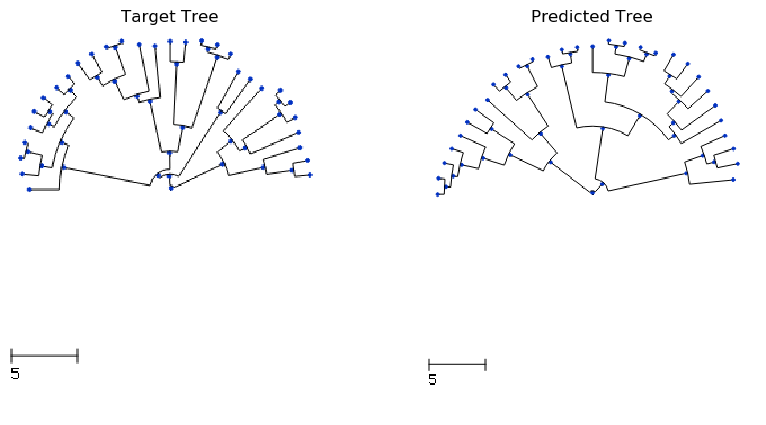

In [ ]:
from ete3 import Tree, faces, TreeStyle

# read the tree from the file
target_tree = Tree("target.nwk", format=1)
predicted_tree = Tree("predicted.nwk", format=1)

# render the target tree
ts = TreeStyle()
ts.show_leaf_name = False
ts.show_branch_length = False
ts.show_branch_support = False
ts.scale = 10
ts.mode = "c"
ts.arc_start = -180 # 0 degrees = 3 o'clock
ts.arc_span = 180

# save the trees as images
target_tree.render("target_tree.png", tree_style=ts)
predicted_tree.render("predicted_tree.png", tree_style=ts)

# plot the trees side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open("target_tree.png"))
ax[0].axis("off")
ax[0].set_title("Target Tree")
ax[1].imshow(Image.open("predicted_tree.png"))
ax[1].axis("off")
ax[1].set_title("Predicted Tree")
plt.show()



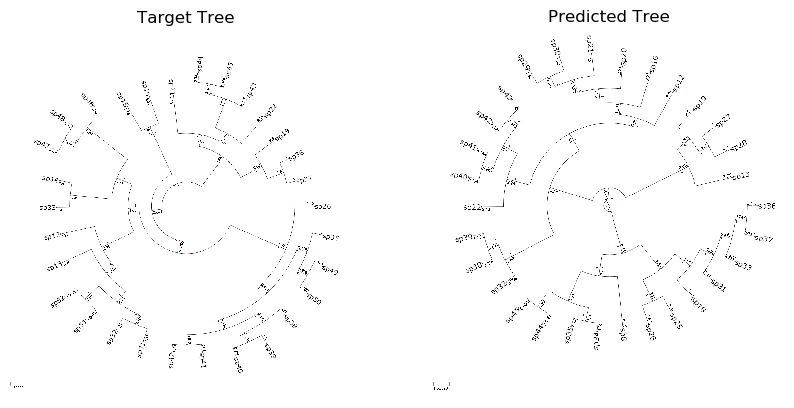

In [ ]:
import random
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace

def layout(node):
    if node.is_leaf():
        # Add node name to laef nodes
        N = AttrFace("name", fsize=14, fgcolor="black")
        faces.add_face_to_node(N, node, 0)
    if "weight" in node.features:
        # Creates a sphere face whose size is proportional to node's
        # feature "weight"
        C = CircleFace(radius=node.weight, color="RoyalBlue", style="sphere")
        # Let's make the sphere transparent
        C.opacity = 0.3
        # And place as a float face over the tree
        faces.add_face_to_node(C, node, 0, position="float")

def get_example_tree():
    # Random tree
    t = Tree()
    t.populate(20, random_branches=True)

    # Some random features in all nodes
    for n in t.traverse():
        n.add_features(weight=random.randint(0, 50))

    # Create an empty TreeStyle
    ts = TreeStyle()

    # Set our custom layout function
    ts.layout_fn = layout

    # Draw a tree
    ts.mode = "c"

    # We will add node names manually
    ts.show_leaf_name = False
    # Show branch data
    ts.show_branch_length = True
    ts.show_branch_support = True

    return t, ts

t, ts = get_example_tree()

# save the trees as images
target_tree.render("target_tree.png", tree_style=ts)
predicted_tree.render("predicted_tree.png", tree_style=ts)

# plot the trees side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Image.open("target_tree.png"))
ax[0].axis("off")
ax[0].set_title("Target Tree")
ax[1].imshow(Image.open("predicted_tree.png"))
ax[1].axis("off")
ax[1].set_title("Predicted Tree")
plt.show()